In [13]:
import os
import shap
from shap.plots import colors  
import wandb
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import lang2vec.lang2vec as l2v
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.tree import plot_tree
from joblib import Parallel, delayed
from scipy.stats import pearsonr, zscore
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics.pairwise import euclidean_distances

# For plots with LaTeX, might give issues depending on your local LaTeX installation
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath} \usepackage{bm}',
    'font.family': 'serif',
})

In [14]:
language_map = {
    "same": "English",
    "avg": "Average",
    "af": "Afrikaans",
    "ar": "Arabic",
    "bg": "Bulgarian",
    "ca": "Catalan",
    "cs": "Czech",
    "da": "Danish",
    "de": "German",
    "el": "Greek",
    "es": "Spanish",
    "fa": "Persian",
    "fi": "Finnish",
    "fr": "French",
    "he": "Hebrew",
    "hi": "Hindi",
    "hu": "Hungarian",
    "it": "Italian",
    "ja": "Japanese",
    "ko": "Korean",
    "lt": "Lithuanian",
    "lv": "Latvian",
    "no": "Norwegian",
    "pl": "Polish",
    "pt": "Portuguese",
    "ro": "Romanian",
    "ru": "Russian",
    "sk": "Slovak",
    "sl": "Slovenian",
    "sv": "Swedish",
    "ta": "Tamil",
    "th": "Thai",
    "tr": "Turkish",
    "uk": "Ukrainian",
    "vi": "Vietnamese",
    "zh": "Chinese",
    "sw": "Swahili",
    "ur": "Urdu",
    "en": "English"
}

In [15]:
method_names = {
    'baseline': 'Fine-tuning Only',
    'before_fastalign': 'Before FastAlign',
    'before_awesome': 'Before Awesome',
    'before_dico': 'Before Dict',
    'during_fastalign': 'During FastAlign',
    'during_awesome': 'During Awesome',
    'during_dico': 'During Dict',
    'freeze_realign_unfreeze_fastalign': 'Before - Front Freeze FastAlign',
    'freeze_realign_unfreeze_awesome': 'Before - Front Freeze Awesome',
    'freeze_realign_unfreeze_dico': 'Before - Front Freeze Dict',
    'freeze_realign_unfreeze_last_6_fastalign': 'Before - Back Freeze FastAlign',
    'freeze_realign_unfreeze_last_half_fastalign': 'Before - Back Freeze FastAlign',
    
    'freeze_realign_unfreeze_last_6_awesome': 'Before - Back Freeze Awesome',
    'freeze_realign_unfreeze_last_half_awesome': 'Before - Back Freeze Awesome',

    'freeze_realign_unfreeze_last_6_dico': 'Before - Back Freeze Dict',
    'freeze_realign_unfreeze_last_half_dico': 'Before - Back Freeze Dict',

    'during_partial_freeze_front_fastalign': 'During Front Freeze FastAlign',
    'during_partial_freeze_front_awesome': 'During Front Freeze Awesome',
    'during_partial_freeze_front_dico': 'During Front Freeze Dict',
    'during_partial_freeze_back_fastalign': 'During Back Freeze FastAlign',
    'during_partial_freeze_back_awesome': 'During Back Freeze Awesome',
    'during_partial_freeze_back_dico': 'During Back Freeze Dict',
}

In [16]:
lang2vec_mapping = {
    "English": "eng",
    "Afrikaans": "afr",
    "Arabic": "arb",
    "Bulgarian": "bul",
    "Catalan": "cat",
    "Czech": "ces",
    "Danish": "dan",
    "German": "deu",
    "Greek": "ell",
    "Spanish": "spa",
    "Persian": "fas",
    "Finnish": "fin",
    "French": "fra",
    "Hebrew": "heb",
    "Hindi": "hin",
    "Hungarian": "hun",
    "Italian": "ita",
    "Japanese": "jpn",
    "Korean": "kor",
    "Lithuanian": "lit",
    "Latvian": "lav",
    "Norwegian": "nob",
    "Polish": "pol",
    "Portuguese": "por",
    "Romanian": "ron",
    "Russian": "rus",
    "Slovak": "slk",
    "Slovenian": "slv",
    "Swedish": "swe",
    "Tamil": "tam",
    "Thai": "tha",
    "Turkish": "tur",
    "Ukrainian": "ukr",
    "Vietnamese": "vie",
    "Chinese": "cmn"
}

In [17]:
def get_lang_distances(lang1, lang2, mapping):
    if lang1 == 'English' and lang2 == 'English':
        return {'syntactic': 0, 'geographic': 0, 'phonological': 0, 'genetic': 0, 'inventory': 0, 'featural': 0}
    lang2_code = mapping.get(lang2)
    
    if not lang2_code:
        print(f"Error: {lang2} is not in the language mapping.")
        return {k: np.nan for k in ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']}
    
    try:
        distances = {
            'syntactic': l2v.distance('syntactic', lang1, lang2_code),
            'geographic': l2v.distance('geographic', lang1, lang2_code),
            'phonological': l2v.distance('phonological', lang1, lang2_code),
            'genetic': l2v.distance('genetic', lang1, lang2_code),
            'inventory': l2v.distance('inventory', lang1, lang2_code),
            'featural': l2v.distance('featural', lang1, lang2_code),
        }
    except Exception as e:
        print(f"Error calculating distances between {lang1} and {lang2_code}: {e}")
        distances = {k: np.nan for k in ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']}
    
    return distances

In [18]:
def add_language_distances_to_df(df, target_lang='eng', lang_col='language'):
    # Initialize distance columns
    distance_cols = ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']
    for col in distance_cols:
        df[col] = np.nan

    for lang in df[lang_col].unique():
        distances = get_lang_distances(target_lang, lang, lang2vec_mapping)
        for col, value in distances.items():
            df.loc[df[lang_col] == lang, col] = value
    
    return df

In [19]:
csv_file_path = './distilMBERT_percentile_data/distilbert-base-multilingual-cased__opus100.csv'

def read_and_process_csv(file_path, model_name):
    df = pd.read_csv(file_path)
    records = []
    
    for idx, row in df.iterrows():
        method = row['method']
        seed = row['seed']
        for lang, lang_name in language_map.items():
            if lang_name.lower() == 'average':
                continue  # Skip the 'average' language
            accuracy_key = f'eval_{lang}_accuracy'
            if accuracy_key in df.columns:
                accuracy = row[accuracy_key]
                record = {
                    'model': model_name,
                    'method': method_names.get(method, method),
                    'language': lang_name,
                    'seed': seed,
                    'accuracy': accuracy if not pd.isna(accuracy) else None
                }
                records.append(record)
    
    df_records = pd.DataFrame(records)
    return df_records

distilmbert_df = read_and_process_csv(csv_file_path, model_name='distilMBERT')


In [20]:
def calculate_delta_accuracy(group):
    baseline = group[group['method'] == 'Fine-tuning Only']
    methods = group[group['method'] != 'Fine-tuning Only']
    
    if len(baseline) > 0:
        baseline_accuracy = baseline['accuracy'].values
        
        for method in methods['method'].unique():
            method_indices = methods['method'] == method
            baseline_subset = baseline_accuracy[:sum(method_indices)]
            methods.loc[method_indices, 'delta_accuracy'] = methods.loc[method_indices, 'accuracy'].values - baseline_subset

    return pd.concat([baseline, methods])

def process_dataframe(df, group_by_columns):
    result = df.groupby(group_by_columns, group_keys=False).apply(calculate_delta_accuracy)
    return result.reset_index(drop=True)

In [21]:
with open("token_counts.txt") as f:
    distilmbert_counts = f.readlines()

# Process distilmbert token data
distilmbert_token_data = {}
for line in distilmbert_counts:
    parts = line.split(':')
    if len(parts) == 2:
        language = parts[0].split('(')[0].strip()
        count = int(parts[1].strip())
        distilmbert_token_data[language] = count

def bin_token_counts(tokens):
    if tokens < 300_000_000:
        return 'Very Low (Less Than 300M)'
    elif tokens < 1_000_000_000:
        return 'Low (300M-1B)'
    elif tokens < 2_000_000_000:
        return 'Medium (1B-2B)'
    elif tokens < 5_000_000_000:
        return 'High (2B-5B)'
    else:
        return 'Very High (More Than 5B)'

def add_token_counts(df):
    df = df.copy()
    df['token_count'] = df['language'].map(distilmbert_token_data)
    df['token_bin'] = df['token_count'].apply(bin_token_counts)
    
    nan_rows = df[df['token_bin'].isna()]
    if not nan_rows.empty:
        print("Languages with NaN token bins:")
        for _, row in nan_rows.iterrows():
            print(f"Model: {row['model']}, Language: {row['language']}")
    
    return df

In [22]:
df = process_dataframe(distilmbert_df, group_by_columns=['model', 'seed', 'language'])
df

C:\Users\alith\AppData\Local\Temp\ipykernel_63724\2421398949.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(group_by_columns, group_keys=False).apply(calculate_delta_accuracy)


,model,method,language,seed,accuracy,delta_accuracy
0,distilMBERT,Fine-tuning Only,Afrikaans,17,0.852558,NaN
1,distilMBERT,Before FastAlign,Afrikaans,17,0.866965,0.014406
2,distilMBERT,Before Awesome,Afrikaans,17,0.865176,0.012618
3,distilMBERT,Before Dict,Afrikaans,17,0.854645,0.002086
4,distilMBERT,During FastAlign,Afrikaans,17,0.862394,0.009836
...,...,...,...,...,...,...
3320,distilMBERT,During Back Freeze Awesome,Vietnamese,66,0.569218,-0.010874
3321,distilMBERT,During Back Freeze Dict,Vietnamese,66,0.586951,0.006859
3322,distilMBERT,Before - Back Freeze FastAlign,Vietnamese,66,0.570724,-0.009368
3323,distilMBERT,Before - Back Freeze Awesome,Vietnamese,66,0.576746,-0.003346


In [23]:
# Drop rows with NaNs in 'accuracy' column
df.dropna(subset=['accuracy'], inplace=True)

# Drop rows with NaNs in 'delta_accuracy' column (if applicable)
df.dropna(subset=['delta_accuracy'], inplace=True)

df.drop('model', axis=1, inplace=True)

df.drop('accuracy', axis=1, inplace=True)

df.drop('seed', axis=1, inplace=True)

df

,method,language,delta_accuracy
1,Before FastAlign,Afrikaans,0.014406
2,Before Awesome,Afrikaans,0.012618
3,Before Dict,Afrikaans,0.002086
4,During FastAlign,Afrikaans,0.009836
5,During Awesome,Afrikaans,0.011823
...,...,...,...
3320,During Back Freeze Awesome,Vietnamese,-0.010874
3321,During Back Freeze Dict,Vietnamese,0.006859
3322,Before - Back Freeze FastAlign,Vietnamese,-0.009368
3323,Before - Back Freeze Awesome,Vietnamese,-0.003346


In [24]:
df = df[~df['method'].str.contains('During', na=False)]
df['method'].value_counts()

method
Before FastAlign                   175
Before Awesome                     175
Before Dict                        175
Before - Front Freeze FastAlign    175
Before - Front Freeze Awesome      175
Before - Front Freeze Dict         175
Before - Back Freeze FastAlign     175
Before - Back Freeze Awesome       175
Before - Back Freeze Dict          175
Name: count, dtype: int64

In [25]:
df['language'].value_counts()

language
Afrikaans     45
Arabic        45
Bulgarian     45
Catalan       45
Chinese       45
Czech         45
Danish        45
English       45
Finnish       45
French        45
German        45
Greek         45
Hebrew        45
Hindi         45
Hungarian     45
Italian       45
Japanese      45
Korean        45
Latvian       45
Lithuanian    45
Norwegian     45
Persian       45
Polish        45
Portuguese    45
Romanian      45
Russian       45
Slovak        45
Slovenian     45
Spanish       45
Swedish       45
Tamil         45
Thai          45
Turkish       45
Ukrainian     45
Vietnamese    45
Name: count, dtype: int64

In [26]:
df

,method,language,delta_accuracy
1,Before FastAlign,Afrikaans,0.014406
2,Before Awesome,Afrikaans,0.012618
3,Before Dict,Afrikaans,0.002086
7,Before - Front Freeze FastAlign,Afrikaans,0.011128
8,Before - Front Freeze Awesome,Afrikaans,0.011227
...,...,...,...
3314,Before - Front Freeze Awesome,Vietnamese,0.004768
3315,Before - Front Freeze Dict,Vietnamese,0.017148
3322,Before - Back Freeze FastAlign,Vietnamese,-0.009368
3323,Before - Back Freeze Awesome,Vietnamese,-0.003346


In [14]:
def split_method_column(df):
    # Create new columns
    df['aligner'] = ''
    df['frozen_status'] = ''
    df['freeze_location'] = 'None'  # Default to 'None'

    # Define mapping for aligners
    aligner_map = {
        'FastAlign': 'FastAlign',
        'Awesome': 'Awesome',
        'Dict': 'Dict'
    }

    # Split the method column
    for idx, row in df.iterrows():
        method = row['method']
        
        # Extract aligner
        for key, value in aligner_map.items():
            if key in method:
                df.at[idx, 'aligner'] = value
                break
        
        # Determine frozen status and location
        if 'Freeze' in method:
            df.at[idx, 'frozen_status'] = 'Frozen'
            if 'Front' in method:
                df.at[idx, 'freeze_location'] = 'Front'
            elif 'Back' in method:
                df.at[idx, 'freeze_location'] = 'Back'
        else:
            df.at[idx, 'frozen_status'] = 'Vanilla'
            # freeze_location remains 'None' for non-frozen methods
    
    # Drop the original 'method' column
    df = df.drop('method', axis=1)
    
    return df

# Apply the function to the main dataframe
df = split_method_column(df)

# Display the updated dataframe
df.head()

C:\Users\alith\AppData\Local\Temp\ipykernel_181880\3144977145.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligner'] = ''
C:\Users\alith\AppData\Local\Temp\ipykernel_181880\3144977145.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['frozen_status'] = ''
C:\Users\alith\AppData\Local\Temp\ipykernel_181880\3144977145.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

,language,delta_accuracy,aligner,frozen_status,freeze_location
1,Afrikaans,0.014406,FastAlign,Vanilla,None
2,Afrikaans,0.012618,Awesome,Vanilla,None
3,Afrikaans,0.002086,Dict,Vanilla,None
7,Afrikaans,0.011128,FastAlign,Frozen,Front
8,Afrikaans,0.011227,Awesome,Frozen,Front


In [29]:
df[df['language'] == 'English'].describe()


,delta_accuracy
count,45.000000
mean,-0.000018
std,0.001334
min,-0.002595
25%,-0.001062
50%,0.000039
75%,0.000944
max,0.003106


In [15]:
from sklearn.model_selection import train_test_split
import numpy as np

np.random.seed(42)


def split_train_val_test(df, test_size=0.2, val_size=0.1, random_state=42):
    # First, split into train+val and test
    train_val, test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # Then split train+val into train and val
    val_size_adjusted = val_size / (1 - test_size)
    train, val = train_test_split(train_val, test_size=val_size_adjusted, random_state=random_state)
    
    return train, val, test

# df = add_token_counts(df)
# df.drop('token_count', axis=1, inplace=True)

# Usage
train_data, val_data, test_data = split_train_val_test(df)

print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)


# def split_train_val_test(combined_data, use_standard_split=False, exclude_languages=False, test_size=0.2, val_size=0.1, random_state=42):
#     combined_data = combined_data.drop(columns=['accuracy'])

#     if use_standard_split:
#         if exclude_languages:
#             # Get a list of unique languages
#             languages = combined_data['language'].unique()
#             # Randomly choose languages to exclude from the training set
#             val_test_languages = np.random.choice(languages, size=int(len(languages) * (val_size + test_size)), replace=False)
#             val_languages = val_test_languages[:int(len(val_test_languages) * (val_size / (val_size + test_size)))]
#             test_languages = val_test_languages[int(len(val_test_languages) * (val_size / (val_size + test_size))):]
            
#             # Split data accordingly
#             train_data = combined_data[~combined_data['language'].isin(val_test_languages)]
#             val_data = combined_data[combined_data['language'].isin(val_languages)]
#             test_data = combined_data[combined_data['language'].isin(test_languages)]
#         else:
#             # Perform a standard train-validation-test split
#             train_data, temp_data = train_test_split(combined_data, test_size=(test_size + val_size), random_state=random_state)
#             val_data, test_data = train_test_split(temp_data, test_size=(test_size / (test_size + val_size)), random_state=random_state)
#     else:
#         # Perform the split based on seeds
#         seeds = combined_data['seed'].unique()
#         if len(seeds) < 5:
#             raise ValueError("There should be at least 5 unique seeds in the data.")
        
#         train_seeds = seeds[:3]
#         val_seed = seeds[3]
#         test_seed = seeds[4]
        
#         train_data = combined_data[combined_data['seed'].isin(train_seeds)]
#         val_data = combined_data[combined_data['seed'] == val_seed]
#         test_data = combined_data[combined_data['seed'] == test_seed]
    
#     train_data = train_data.drop(columns=['seed'])
#     val_data = val_data.drop(columns=['seed'])
#     test_data = test_data.drop(columns=['seed'])
    
#     return train_data.reset_index(drop=True), val_data.reset_index(drop=True), test_data.reset_index(drop=True)

# train_data, val_data, test_data = split_train_val_test(df, use_standard_split=True, exclude_languages=True)

# train_data


Train data shape: (1102, 5)
Validation data shape: (158, 5)
Test data shape: (315, 5)


In [16]:
val_data

,language,delta_accuracy,aligner,frozen_status,freeze_location
2829,Finnish,0.003729,Awesome,Frozen,Back
2472,Russian,0.025722,Awesome,Vanilla,None
3075,Persian,0.009047,FastAlign,Frozen,Back
312,Japanese,0.003913,Awesome,Frozen,Front
248,Hindi,0.054530,FastAlign,Vanilla,None
...,...,...,...,...,...
873,German,0.011746,Dict,Frozen,Back
948,Hungarian,0.017131,Awesome,Frozen,Back
1865,Spanish,0.009863,Dict,Vanilla,None
2516,Slovenian,0.034877,Awesome,Frozen,Front


In [17]:
test_data

,language,delta_accuracy,aligner,frozen_status,freeze_location
2630,Ukrainian,0.028969,Awesome,Frozen,Front
1717,Norwegian,0.015351,FastAlign,Frozen,Front
2477,Russian,0.027741,FastAlign,Frozen,Front
1128,Romanian,0.023888,FastAlign,Frozen,Front
1085,Polish,0.035905,Awesome,Vanilla,None
...,...,...,...,...,...
1728,Norwegian,0.017753,Dict,Frozen,Back
2338,Latvian,0.105400,FastAlign,Vanilla,None
2555,Swedish,0.012942,Dict,Frozen,Front
2909,Hindi,0.065453,Awesome,Vanilla,None


In [18]:
def plot_loss_curve(errors, save_path=None, start=1, end=None, title=""):
    if end is None:
        end = len(errors)
    plt.figure(figsize=(10, 6))
    plt.plot(range(start, end + 1), errors[start - 1:end], marker='o')
    plt.title(f'Model Loss Over Time - {title}')
    plt.xlabel('Number of Trees')
    plt.ylabel('Mean Squared Error')
    plt.grid(True)
    if save_path:
        plt.savefig(os.path.join(save_path, f'loss_curve_{title.replace(" ", "_")}.png'))
    else:
        plt.show()
    plt.close()

In [19]:
def plot_feature_importances(coefficients, encoded_columns, title=""):
    # Create a DataFrame from coefficients and encoded columns
    importances_df = pd.DataFrame({'Feature': encoded_columns, 'Importance': coefficients})
    importances_df = importances_df.sort_values(by='Importance', ascending=False)
    
    # Define groups and colors
    group_colors = {
        'Language': '#1f77b4',
        'Aligner': '#ff7f0e',
        'Freezing Status': '#2ca02c',
        'Freeze Location': '#d62728',
        'Script Type': '#9467bd',
        'Word Order': '#8c564b',
        'Morphological Complexity': '#e377c2',
        'Token Bin': '#17becf',
        'Distance': '#7f7f7f',
        'Other': '#bcbd22'
    }
    
    def get_group(feature):
        if feature.startswith('language_'):
            return 'Language'
        elif feature.startswith('aligner_'):
            return 'Aligner'
        elif feature.startswith('frozen_status_'):
            return 'Freezing Status'
        elif feature.startswith('freeze_location_'):
            return 'Freeze Location'
        elif feature.startswith('script_type_'):
            return 'Script Type'
        elif feature.startswith('word_order_'):
            return 'Word Order'
        elif feature.startswith('morphological_complexity_'):
            return 'Morphological Complexity'
        elif feature.startswith('token_bin_'):
            return 'Token Bin'
        elif feature in ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']:
            return 'Distance'
        else:
            return 'Other'

    importances_df['Group'] = importances_df['Feature'].apply(get_group)
    
    plt.figure(figsize=(12, 10))
    ax = sns.barplot(x='Importance', y='Feature', hue='Group', data=importances_df, dodge=False, palette=group_colors)
    
    # Clean up feature names for display
    def clean_feature_name(name):
        prefixes = ['language_', 'aligner_', 'frozen_status_', 'freeze_location_', 
                    'script_type_', 'word_order_', 'morphological_complexity_', 'token_bin_']
        for prefix in prefixes:
            if name.startswith(prefix):
                return name[len(prefix):].replace('_', ' ').title()
        return name.title()

    new_labels = [clean_feature_name(label.get_text()) for label in ax.get_yticklabels()]
    ax.set_yticklabels(new_labels, fontsize=14)  # Increased font size for y-axis labels
    
    plt.xlabel('Importance', fontsize=18)  # Increased font size for x-axis label
    plt.ylabel('Feature', fontsize=18)  # Increased font size for y-axis label
    plt.legend(title='Group', loc='lower right', fontsize=14, title_fontsize=16)  # Increased font sizes for legend
    plt.grid(True)
    
    # Increase font size for x-axis tick labels
    plt.xticks(fontsize=14)
    
    plt.tight_layout()
    plt.show()

In [20]:
def plot_actual_vs_predicted(y_true, y_pred, title=""):
    # Calculate R2 score and MSE
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, label='Predicted vs Actual')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ideal Fit')
    plt.xlabel('Actual Values', fontsize=18)
    plt.ylabel('Predicted Values', fontsize=18)
    
    # Increase tick label size
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Move the legend to the lower right and increase font size
    plt.legend(loc='lower right', fontsize=14)
    
    # Place the R2 and MSE scores in the top left corner of the plot
    plt.text(0.05, 0.95, f'R²: {r2:.4f}\nMSE: {mse:.4f}', 
             transform=plt.gca().transAxes, 
             verticalalignment='top', 
             fontsize=14,
             bbox=dict(boxstyle='round,pad=0.5', edgecolor='gray', facecolor='white'))
    
    plt.grid(True)
    plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
    plt.show()

In [21]:
def plot_and_tabulate_feature_importances(coefficients, encoded_columns, title=""):
    # Create a DataFrame from coefficients and encoded columns
    importances_df = pd.DataFrame({'Feature': encoded_columns, 'Importance': coefficients})
    
    # Print unique feature names
    print("Unique feature names:")
    print(importances_df['Feature'].unique())
    
    # Define groups and colors (ensuring consistency with the other function)
    group_colors = {
        'Language': '#1f77b4',
        'Aligner': '#ff7f0e',
        'Freezing Status': '#2ca02c',
        'Freeze Location': '#d62728',
        'Script Type': '#9467bd',
        'Word Order': '#8c564b',
        'Morphological Complexity': '#e377c2',
        'Token Bin': '#17becf',
        'Lang2Vec Distances': '#7f7f7f',
        'Other': '#bcbd22'
    }
    
    def get_group(feature):
        if feature.startswith('language_'):
            return 'Language'
        elif feature.startswith('aligner_'):
            return 'Aligner'
        elif feature.startswith('frozen_status_'):
            return 'Freezing Status'
        elif feature.startswith('freeze_location_'):
            return 'Freeze Location'
        elif feature.startswith('script_type_'):
            return 'Script Type'
        elif feature.startswith('word_order_'):
            return 'Word Order'
        elif feature.startswith('morphological_complexity_'):
            return 'Morphological Complexity'
        elif feature.startswith('token_bin_'):
            return 'Token Bin'
        elif feature in ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']:
            return 'Lang2Vec Distances'
        else:
            return 'Other'

    importances_df['Group'] = importances_df['Feature'].apply(get_group)
    
    # Print unique groups
    print("\nUnique groups:")
    print(importances_df['Group'].unique())
    
    # Aggregate importances by group
    aggregated_importances = importances_df.groupby('Group')['Importance'].sum().abs().sort_values(ascending=False)
    
    # Plot aggregated importances
    plt.figure(figsize=(16, 10))  # Increased figure size for better readability
    ax = aggregated_importances.plot(kind='bar', color=[group_colors[group] for group in aggregated_importances.index])
    plt.xlabel('Feature Group', fontsize=24)  # Increased font size
    plt.ylabel('Absolute Importance', fontsize=24)  # Increased font size
    plt.xticks(rotation=45, ha='right', fontsize=20)  # Increased font size
    plt.yticks(fontsize=20)  # Increased font size
    
    # Add value labels on top of each bar
    for i, v in enumerate(aggregated_importances):
        ax.text(i, v, f'{v:.3f}', ha='center', va='bottom', fontsize=18,  # Increased font size
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=3))  # Added background to numbers
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Create a ranked table of aggregated importances
    table_df = aggregated_importances.reset_index()
    table_df['Rank'] = range(1, len(table_df) + 1)
    table_df = table_df[['Rank', 'Group', 'Importance']]
    table_df = table_df.sort_values('Importance', ascending=False).reset_index(drop=True)

    print(f"\nRanked Aggregated Feature Importances")
    print(table_df.to_string(index=False))

    # Create a ranked table of individual feature importances
    individual_table_df = importances_df.copy()
    individual_table_df['Importance'] = individual_table_df['Importance'].abs()
    individual_table_df = individual_table_df.sort_values('Importance', ascending=False).reset_index(drop=True)
    individual_table_df['Rank'] = range(1, len(individual_table_df) + 1)
    individual_table_df = individual_table_df[['Rank', 'Feature', 'Group', 'Importance']]

    print(f"\nRanked Individual Feature Importances")
    print(individual_table_df.head(20).to_string(index=False))  # Print top 20 features

    # Create styled DataFrames for better visualization
    def style_dataframe(df, group_colors):
        return df.style.apply(lambda x: [f'background-color: {group_colors[val]};' 
                                         f'color: {"white" if val in ["Language", "Aligner", "Freezing Status", "Freeze Location", "Token Bin"] else "black"};'
                                         'font-weight: bold' for val in x], 
                              subset=['Group'])

    styled_table_df = style_dataframe(table_df, group_colors)
    styled_individual_table_df = style_dataframe(individual_table_df, group_colors)

    return styled_table_df, styled_individual_table_df

In [22]:
def perform_regression(train_data, val_data, test_data, n_estimators=30, save_path=None, title=""):
    # Encode categorical variables
    encoded_train_df = pd.get_dummies(train_data, drop_first=False)
    encoded_val_df = pd.get_dummies(val_data, drop_first=False)
    encoded_test_df = pd.get_dummies(test_data, drop_first=False)
    
    # Ensure the encoded validation and test sets have the same columns as the training set
    encoded_val_df = encoded_val_df.reindex(columns=encoded_train_df.columns, fill_value=0)
    encoded_test_df = encoded_test_df.reindex(columns=encoded_train_df.columns, fill_value=0)
    
    X_train = encoded_train_df.drop('delta_accuracy', axis=1)
    y_train = encoded_train_df['delta_accuracy']
    X_val = encoded_val_df.drop('delta_accuracy', axis=1)
    y_val = encoded_val_df['delta_accuracy']
    X_test = encoded_test_df.drop('delta_accuracy', axis=1)
    y_test = encoded_test_df['delta_accuracy']
    
    regression_model = RandomForestRegressor(n_estimators=1, warm_start=True, random_state=42)
    errors = []
    
    for i in tqdm(range(1, n_estimators + 30)):
        regression_model.n_estimators = i
        regression_model.fit(X_train, y_train)
        y_pred = regression_model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        errors.append(mse)
    
    importances = regression_model.feature_importances_
    coefficients = pd.Series(importances, index=X_train.columns)
    
    # Perform final evaluation on the test set
    y_test_pred = regression_model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    print(f"\nFinal Test MSE for {title} (Random Forest): {test_mse}")
    
    # Plot the loss curve
    plot_loss_curve(errors, save_path, title=title)
 
    plot_feature_importances(coefficients, X_train.columns, title=title)
    
    # Plot actual vs. predicted values
    plot_actual_vs_predicted(y_test, y_test_pred, title=title)

    plot_and_tabulate_feature_importances(coefficients, X_train.columns, title=title)
    
    return coefficients, X_train.columns

100%|██████████| 59/59 [00:00<00:00, 236.01it/s]



Final Test MSE for Full Data (Random Forest): 0.0003169015576359327


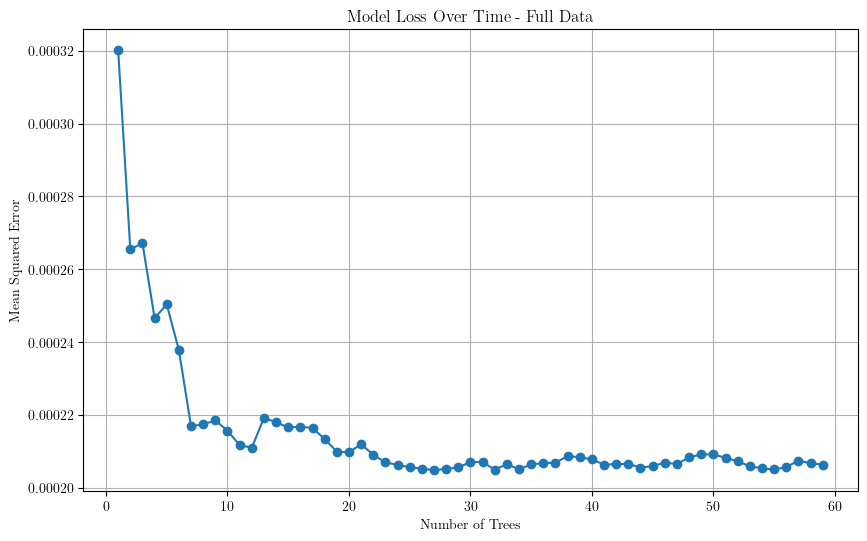

C:\Users\alith\AppData\Local\Temp\ipykernel_181880\3614062542.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels, fontsize=14)  # Increased font size for y-axis labels


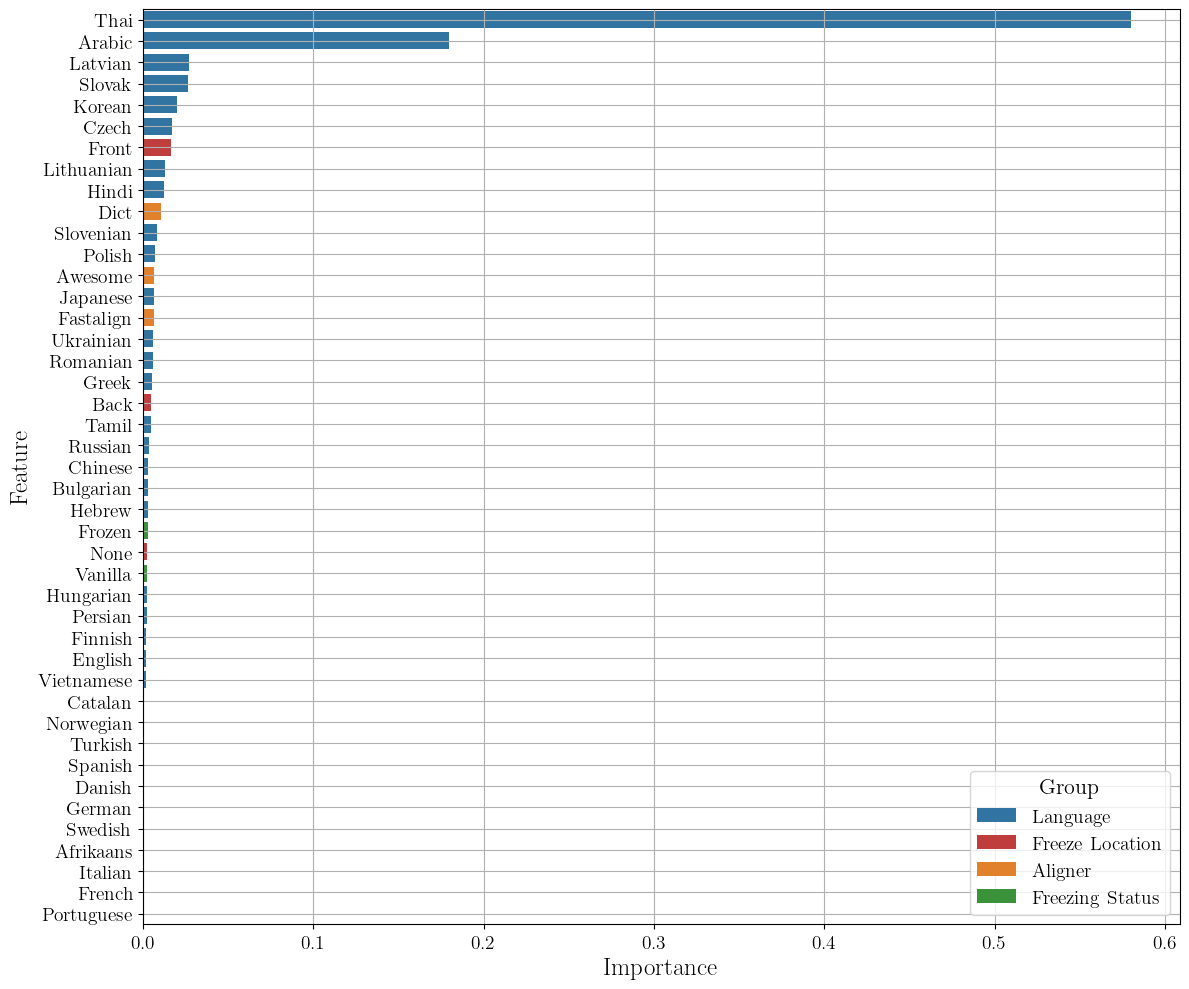

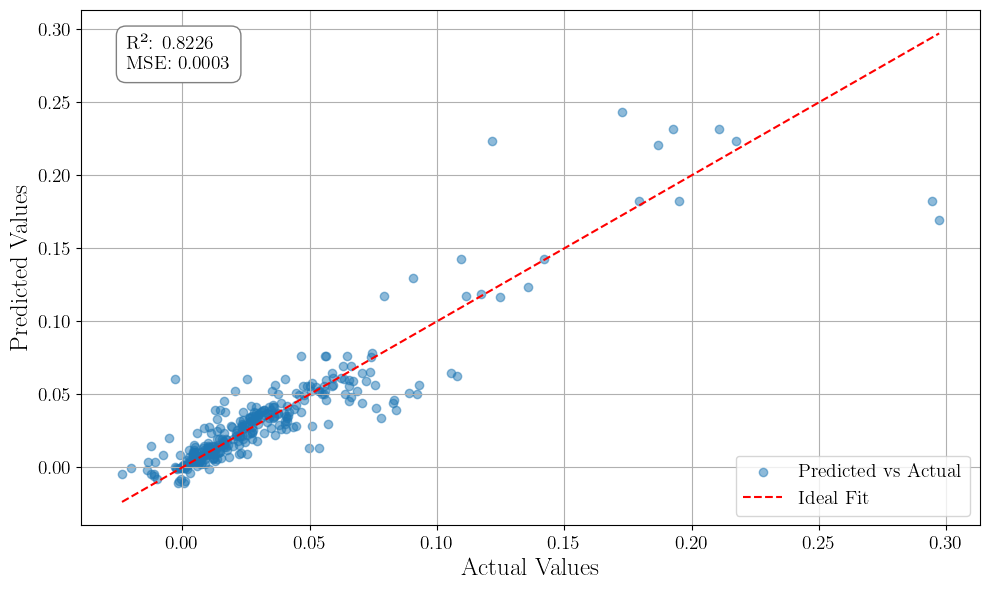

Unique feature names:
['language_Afrikaans' 'language_Arabic' 'language_Bulgarian'
 'language_Catalan' 'language_Chinese' 'language_Czech' 'language_Danish'
 'language_English' 'language_Finnish' 'language_French' 'language_German'
 'language_Greek' 'language_Hebrew' 'language_Hindi' 'language_Hungarian'
 'language_Italian' 'language_Japanese' 'language_Korean'
 'language_Latvian' 'language_Lithuanian' 'language_Norwegian'
 'language_Persian' 'language_Polish' 'language_Portuguese'
 'language_Romanian' 'language_Russian' 'language_Slovak'
 'language_Slovenian' 'language_Spanish' 'language_Swedish'
 'language_Tamil' 'language_Thai' 'language_Turkish' 'language_Ukrainian'
 'language_Vietnamese' 'aligner_Awesome' 'aligner_Dict'
 'aligner_FastAlign' 'frozen_status_Frozen' 'frozen_status_Vanilla'
 'freeze_location_Back' 'freeze_location_Front' 'freeze_location_None']

Unique groups:
['Language' 'Aligner' 'Freezing Status' 'Freeze Location']


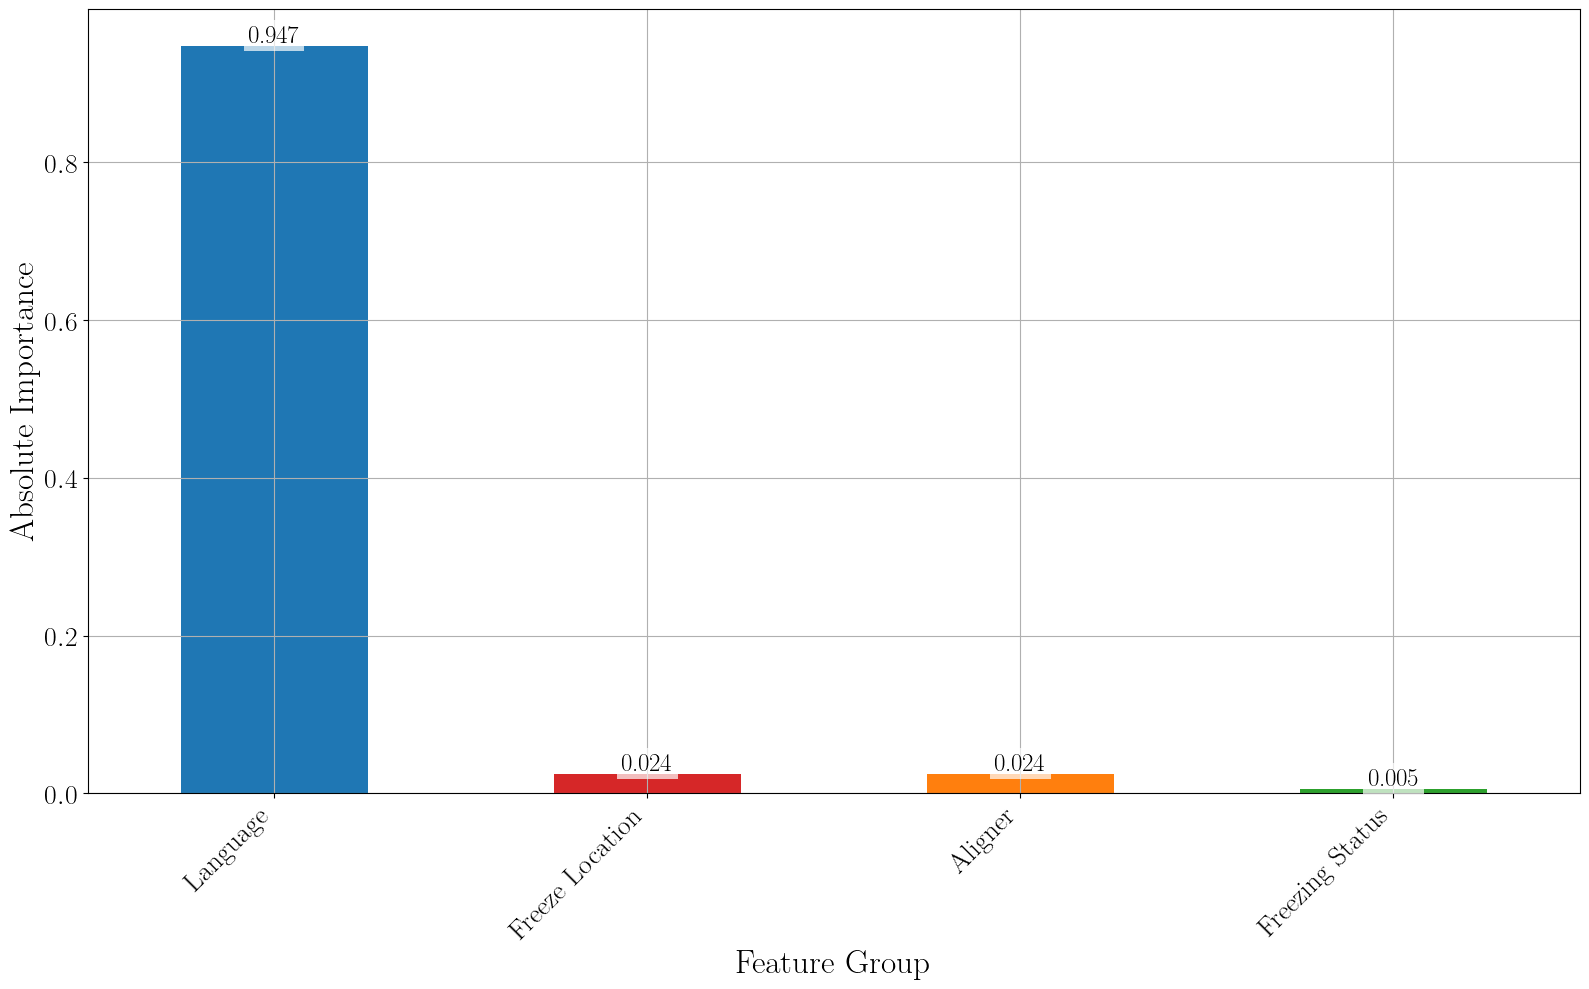


Ranked Aggregated Feature Importances
 Rank           Group  Importance
    1        Language    0.946713
    2 Freeze Location    0.024181
    3         Aligner    0.024046
    4 Freezing Status    0.005060

Ranked Individual Feature Importances
 Rank               Feature           Group  Importance
    1         language_Thai        Language    0.579898
    2       language_Arabic        Language    0.179735
    3      language_Latvian        Language    0.027079
    4       language_Slovak        Language    0.026721
    5       language_Korean        Language    0.020132
    6        language_Czech        Language    0.016860
    7 freeze_location_Front Freeze Location    0.016472
    8   language_Lithuanian        Language    0.012945
    9        language_Hindi        Language    0.012232
   10          aligner_Dict         Aligner    0.010897
   11    language_Slovenian        Language    0.008346
   12       language_Polish        Language    0.007003
   13       aligner_Awes

In [23]:
coefficients, encoded_columns = perform_regression(train_data, val_data, test_data, title='Full Data')

print("Feature Importances:")
print(coefficients)

In [24]:
train_data[train_data['language'] == 'Thai']

,language,delta_accuracy,aligner,frozen_status,freeze_location
1256,Thai,0.125599,Awesome,Vanilla,None
3265,Thai,0.192158,FastAlign,Frozen,Back
1926,Thai,0.184683,FastAlign,Frozen,Front
607,Thai,0.241395,Dict,Frozen,Back
591,Thai,0.227116,Awesome,Vanilla,None
2586,Thai,0.325276,Awesome,Vanilla,None
2601,Thai,0.314041,Awesome,Frozen,Back
2591,Thai,0.278546,FastAlign,Frozen,Front
2602,Thai,0.336332,Dict,Frozen,Back
3257,Thai,0.157916,Awesome,Frozen,Front


In [25]:
val_data[val_data['language'] == 'Thai']

,language,delta_accuracy,aligner,frozen_status,freeze_location
3256,Thai,0.150933,FastAlign,Frozen,Front
1927,Thai,0.198380,Awesome,Frozen,Front
1270,Thai,0.123003,FastAlign,Frozen,Back


In [26]:
test_data[test_data['language'] == 'Thai']

,language,delta_accuracy,aligner,frozen_status,freeze_location
3258,Thai,0.179356,Dict,Frozen,Front
1272,Thai,0.172687,Dict,Frozen,Back
2593,Thai,0.294257,Dict,Frozen,Front
1928,Thai,0.195202,Dict,Frozen,Front
3250,Thai,0.192874,FastAlign,Vanilla,None
1271,Thai,0.121749,Awesome,Frozen,Back
1920,Thai,0.210823,FastAlign,Vanilla,None
3251,Thai,0.186742,Awesome,Vanilla,None
2592,Thai,0.297211,Awesome,Frozen,Front
606,Thai,0.217582,Awesome,Frozen,Back


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def analyze_and_remove_outliers(df, column='delta_accuracy', threshold=1.5):
    def remove_outliers(df, column, threshold):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        
        return df_clean, outliers

    # Before removing outliers
    plt.figure(figsize=(10, 6))
    plt.hist(df[column], bins=50)
    plt.xlabel('Delta Accuracy', fontsize=18)
    plt.ylabel('Frequency', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Remove outliers
    df_clean, outliers = remove_outliers(df, column, threshold)

    print(f"Number of outliers removed: {len(outliers)}")
    print(f"Shape of data before removing outliers: {df.shape}")
    print(f"Shape of data after removing outliers: {df_clean.shape}")

    # After removing outliers
    plt.figure(figsize=(10, 6))
    plt.hist(df_clean[column], bins=50)
    plt.xlabel('Delta Accuracy', fontsize=18)
    plt.ylabel('Frequency', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Display some statistics
    print("\nStatistics before removing outliers:")
    print(df[column].describe())
    print("\nStatistics after removing outliers:")
    print(df_clean[column].describe())

    # Analyze outliers
    print("\nOutlier Analysis:")

    # Languages
    print("\nTop 10 Languages in Outliers:")
    language_counts = outliers['language'].value_counts()
    print(language_counts.head(10))

    # Word Aligners
    print("\nWord Aligners in Outliers:")
    aligner_counts = outliers['aligner'].value_counts()
    print(aligner_counts)

    # Freezing Status
    print("\nFreezing Status in Outliers:")
    freeze_counts = outliers['frozen_status'].value_counts()
    print(freeze_counts)

    # Freeze Location
    print("\nFreeze Location in Outliers:")
    location_counts = outliers['freeze_location'].value_counts()
    print(location_counts)

    # Consolidated view of extreme outliers
    print("\nTop 10 Highest Delta Accuracy Outliers:")
    print(outliers.sort_values(column, ascending=False).head(10)[['language', 'aligner', 'frozen_status', 'freeze_location', column]])

    print("\nTop 10 Lowest Delta Accuracy Outliers:")
    print(outliers.sort_values(column, ascending=True).head(10)[['language', 'aligner', 'frozen_status', 'freeze_location', column]])

    # Percentage of outliers by category
    def percentage_outliers(feature):
        total = len(df[feature].unique())
        outlier = len(outliers[feature].unique())
        return (outlier / total) * 100

    print("\nPercentage of categories that appear in outliers:")
    print(f"Languages: {percentage_outliers('language'):.2f}%")
    print(f"Aligners: {percentage_outliers('aligner'):.2f}%")
    print(f"Freezing Status: {percentage_outliers('frozen_status'):.2f}%")
    print(f"Freeze Location: {percentage_outliers('freeze_location'):.2f}%")

    # Visualize outliers distribution
    plt.figure(figsize=(24, 16))  # Even larger figure size

    # Sort languages by median delta accuracy
    language_order = outliers.groupby('language')[column].median().sort_values(ascending=False).index

    # Create the boxplot
    ax = sns.boxplot(x='language', y=column, data=outliers, order=language_order)

    plt.xlabel('Language', fontsize=36)
    plt.ylabel('Delta Accuracy', fontsize=36)
    plt.xticks(rotation=45, ha='right', fontsize=32)
    plt.yticks(fontsize=32)

    # Increase tick label padding
    ax.tick_params(axis='x', which='major', pad=15)
    ax.tick_params(axis='y', which='major', pad=15)

    # Add number of outliers for each language above the plot
    for i, language in enumerate(language_order):
        count = outliers[outliers['language'] == language].shape[0]
        plt.text(i, plt.ylim()[1], f'n={count}', ha='center', va='bottom', fontsize=32, 
                 bbox=dict(facecolor='white', edgecolor='black', alpha=0.7, pad=5))

    # Remove top and right spines
    sns.despine()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nSummary Statistics for Outliers:")
    print(outliers.groupby('language')[column].describe())

    return df_clean, outliers

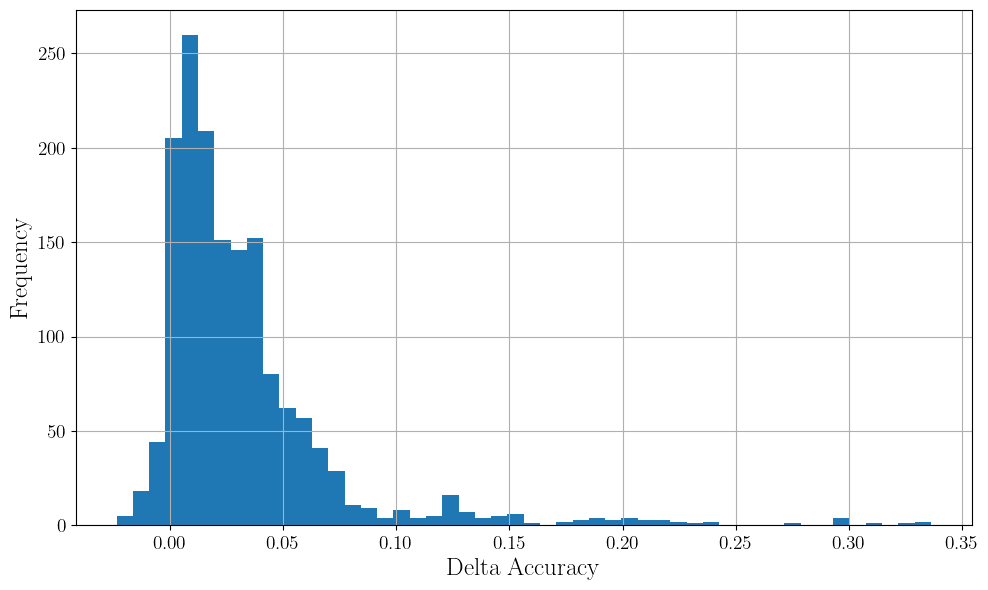

Number of outliers removed: 101
Shape of data before removing outliers: (1575, 5)
Shape of data after removing outliers: (1474, 5)


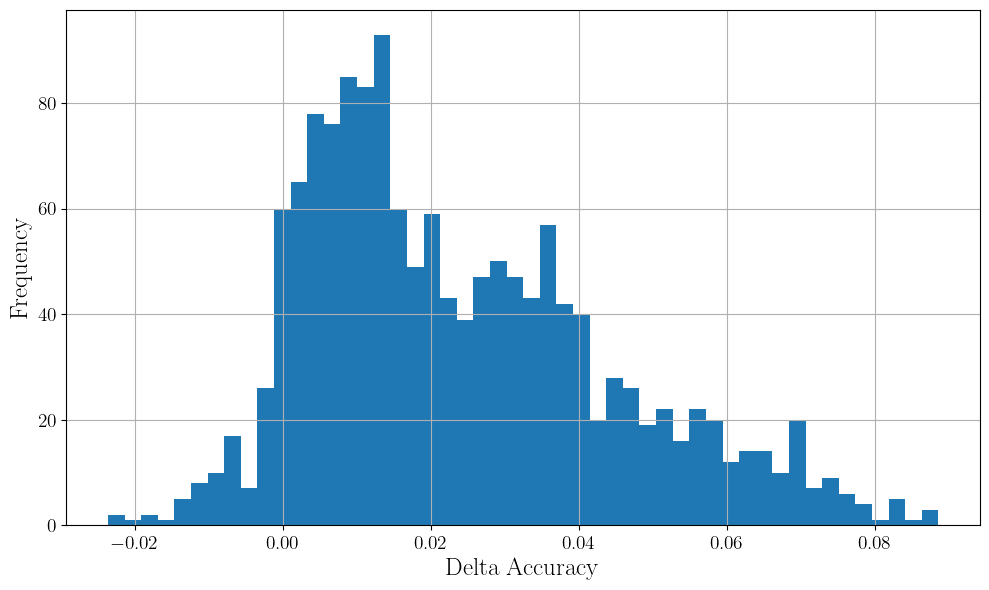


Statistics before removing outliers:
count    1575.000000
mean        0.032609
std         0.041963
min        -0.023672
25%         0.008656
50%         0.021235
75%         0.040714
max         0.336332
Name: delta_accuracy, dtype: float64

Statistics after removing outliers:
count    1474.000000
mean        0.023848
std         0.020687
min        -0.023672
25%         0.007967
50%         0.019392
75%         0.036592
max         0.088550
Name: delta_accuracy, dtype: float64

Outlier Analysis:

Top 10 Languages in Outliers:
language
Thai          45
Arabic        40
Latvian        9
Korean         3
Hindi          2
Lithuanian     2
Name: count, dtype: int64

Word Aligners in Outliers:
aligner
Dict         38
Awesome      32
FastAlign    31
Name: count, dtype: int64

Freezing Status in Outliers:
frozen_status
Frozen     66
Vanilla    35
Name: count, dtype: int64

Freeze Location in Outliers:
freeze_location
None     35
Back     34
Front    32
Name: count, dtype: int64

Top 10 High

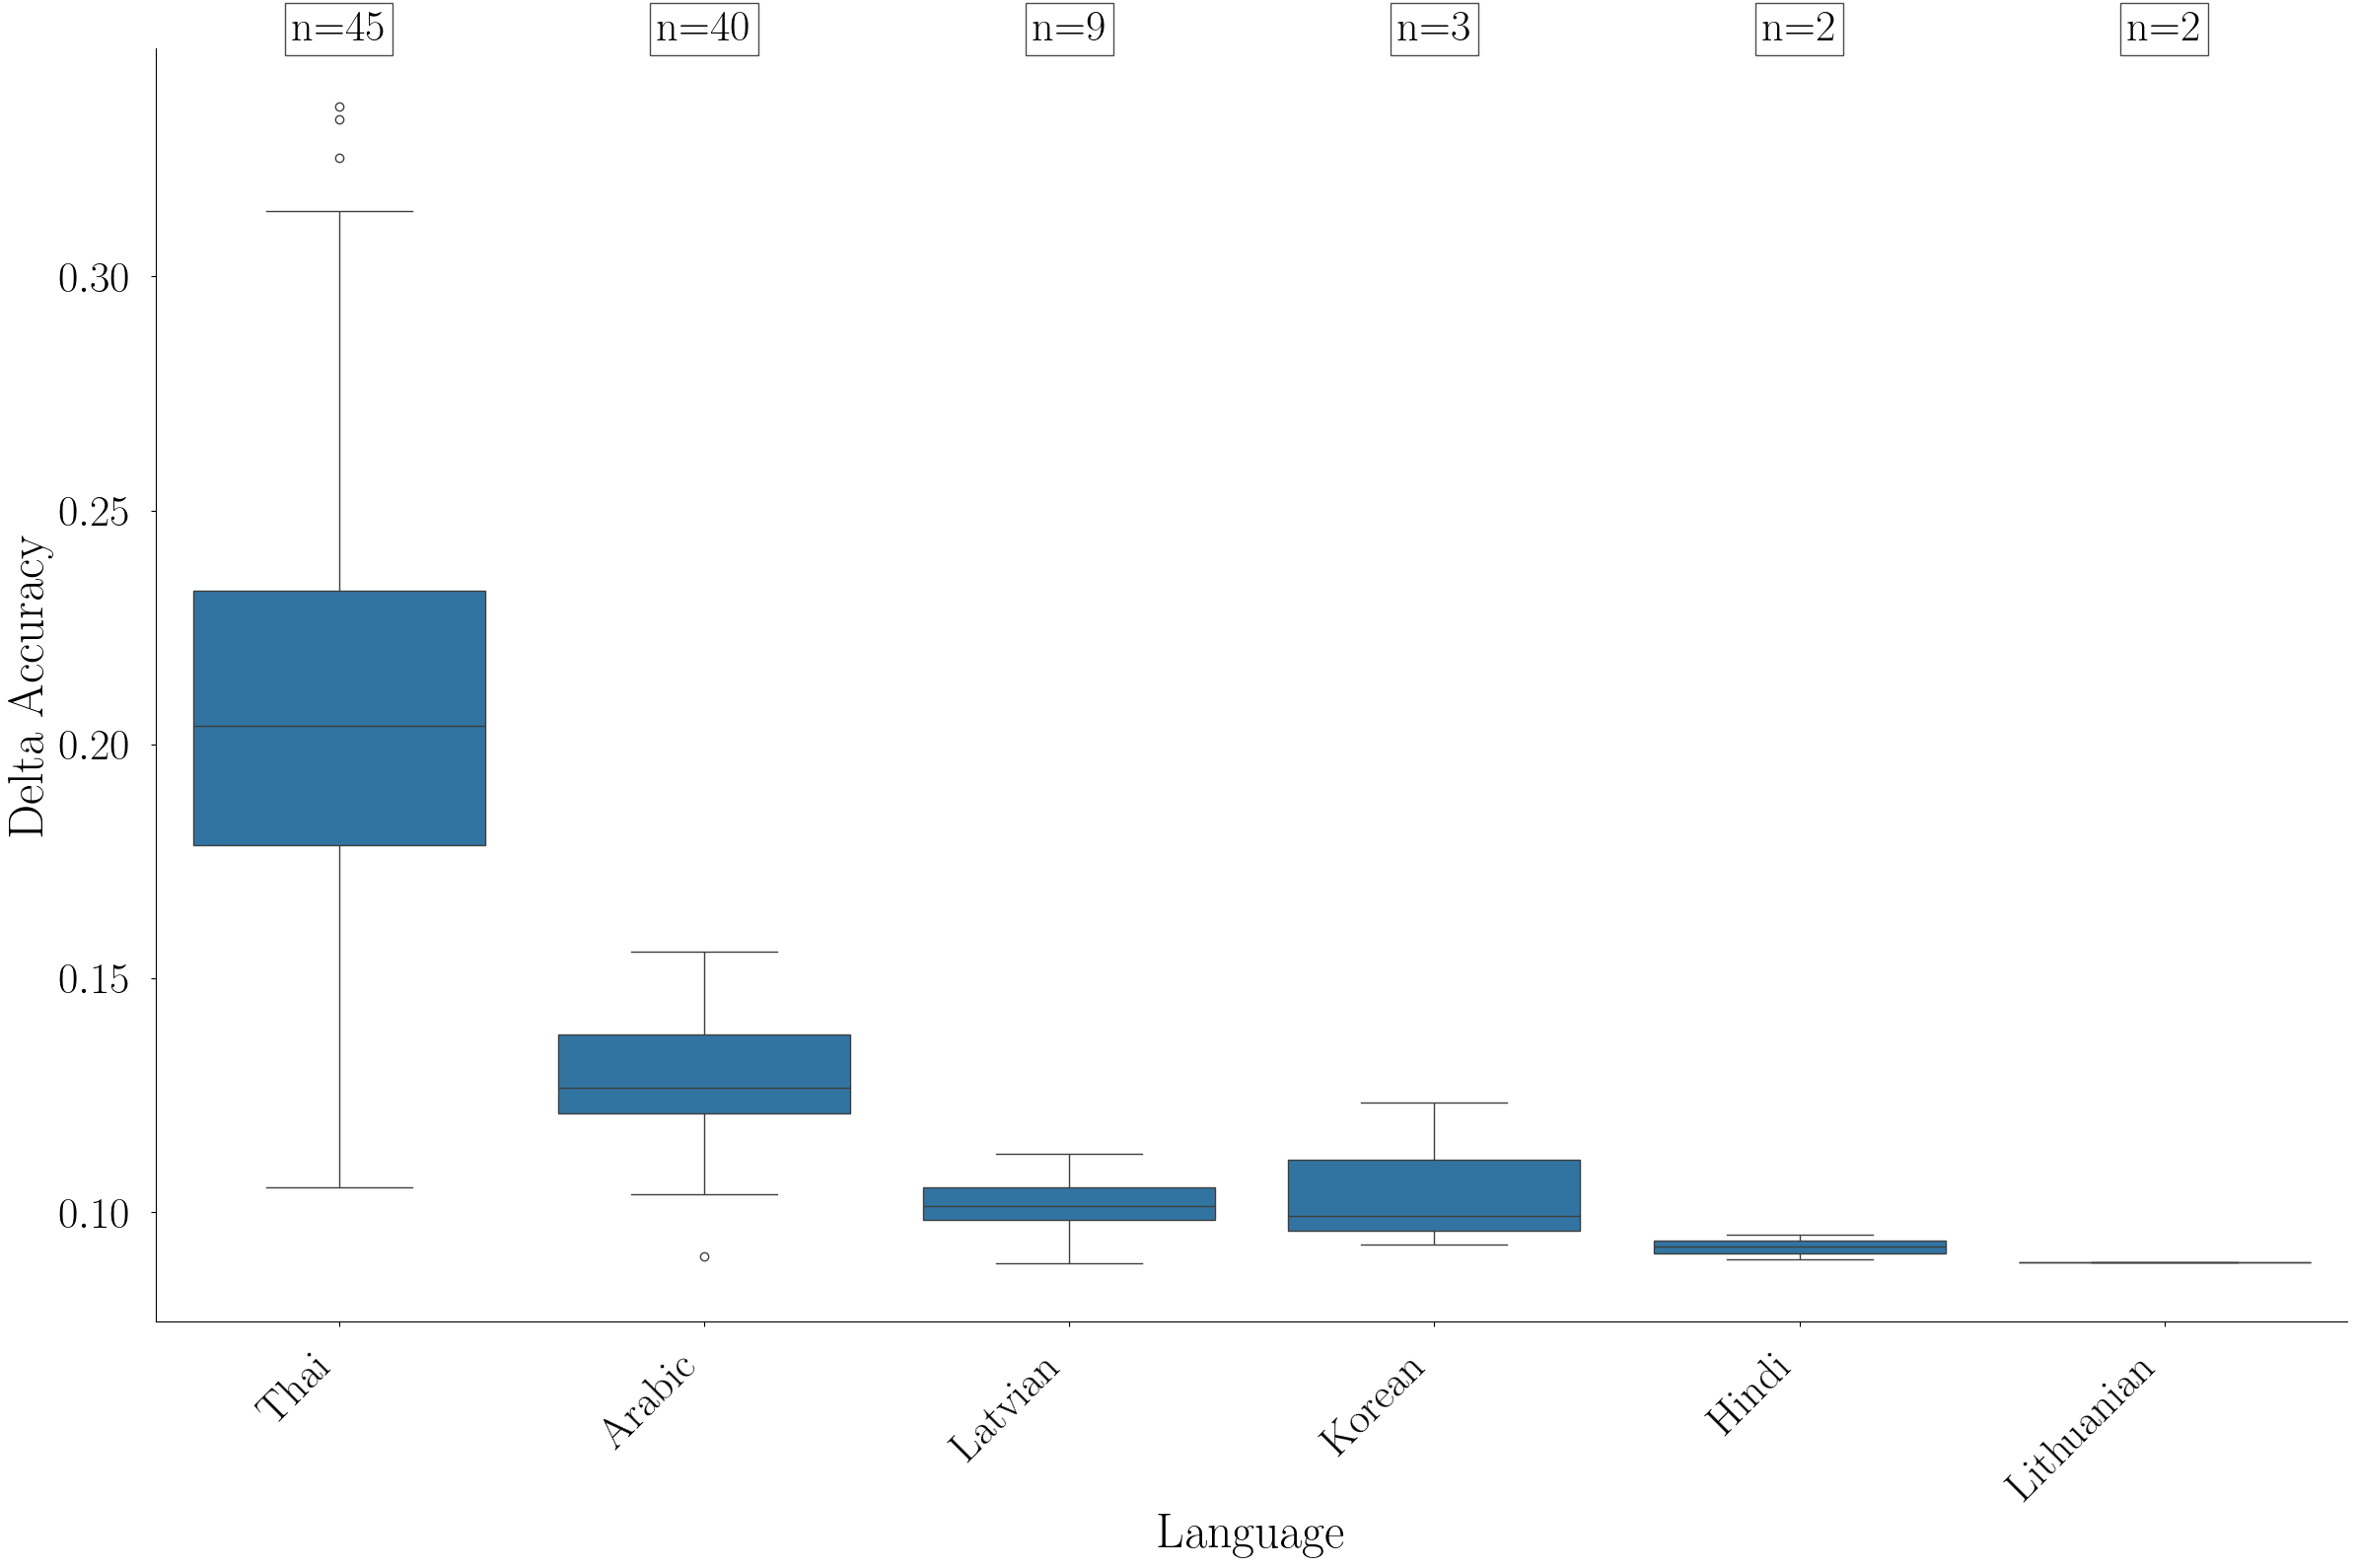


Summary Statistics for Outliers:
            count      mean       std       min       25%       50%       75%  \
language                                                                        
Arabic       40.0  0.128933  0.014882  0.090638  0.121115  0.126688  0.137921   
Hindi         2.0  0.092647  0.003772  0.089980  0.091314  0.092647  0.093981   
Korean        3.0  0.105250  0.016087  0.093089  0.096129  0.099169  0.111330   
Latvian       9.0  0.101255  0.007377  0.089045  0.098429  0.101368  0.105400   
Lithuanian    2.0  0.089325  0.000130  0.089233  0.089279  0.089325  0.089371   
Thai         45.0  0.210178  0.059681  0.105322  0.178461  0.203930  0.232756   

                 max  
language              
Arabic      0.155721  
Hindi       0.095315  
Korean      0.123491  
Latvian     0.112484  
Lithuanian  0.089417  
Thai        0.336332  


In [28]:
df_clean, outliers = analyze_and_remove_outliers(df)

In [29]:
train_data, val_data, test_data = split_train_val_test(df_clean)

train_data

,language,delta_accuracy,aligner,frozen_status,freeze_location
1841,Slovak,0.070015,Awesome,Frozen,Back
1168,Slovak,0.059049,Dict,Frozen,Front
971,Japanese,0.016110,Awesome,Vanilla,None
1618,Italian,0.007262,Dict,Vanilla,None
1728,Norwegian,0.017753,Dict,Frozen,Back
...,...,...,...,...,...
1941,Turkish,0.000697,Dict,Vanilla,None
2270,Hungarian,0.021150,Dict,Frozen,Front
369,Lithuanian,0.056416,Awesome,Frozen,Front
56,Bulgarian,0.018443,Dict,Frozen,Back


100%|██████████| 59/59 [00:00<00:00, 206.66it/s]


Final Test MSE for Outliers Removed (Random Forest): 0.00012947122778761373


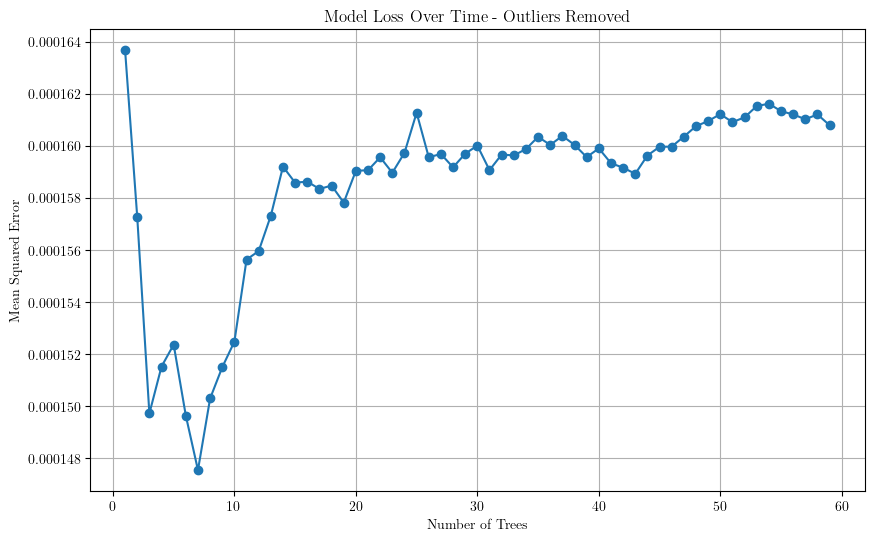

C:\Users\alith\AppData\Local\Temp\ipykernel_181880\3614062542.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels, fontsize=14)  # Increased font size for y-axis labels


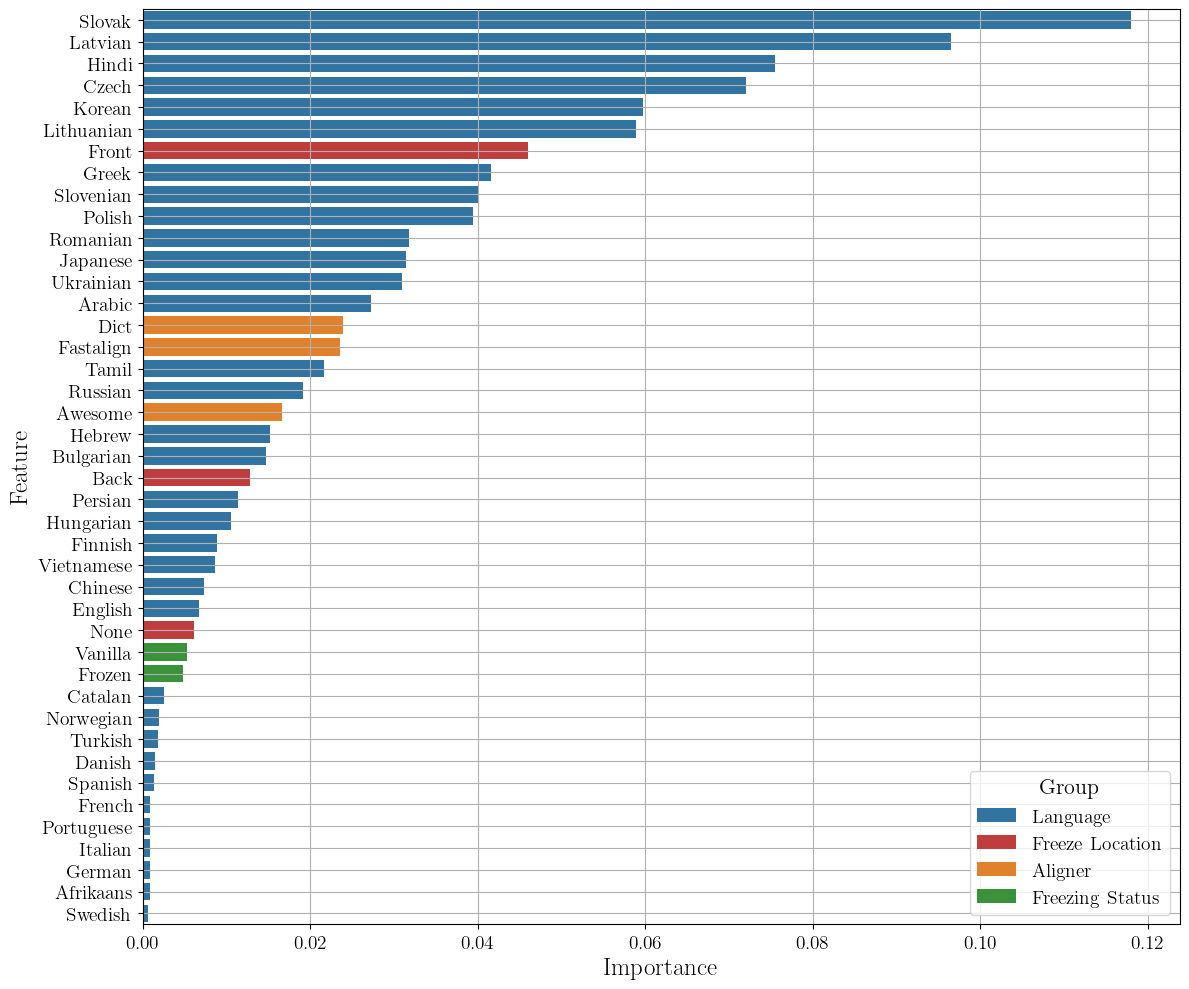

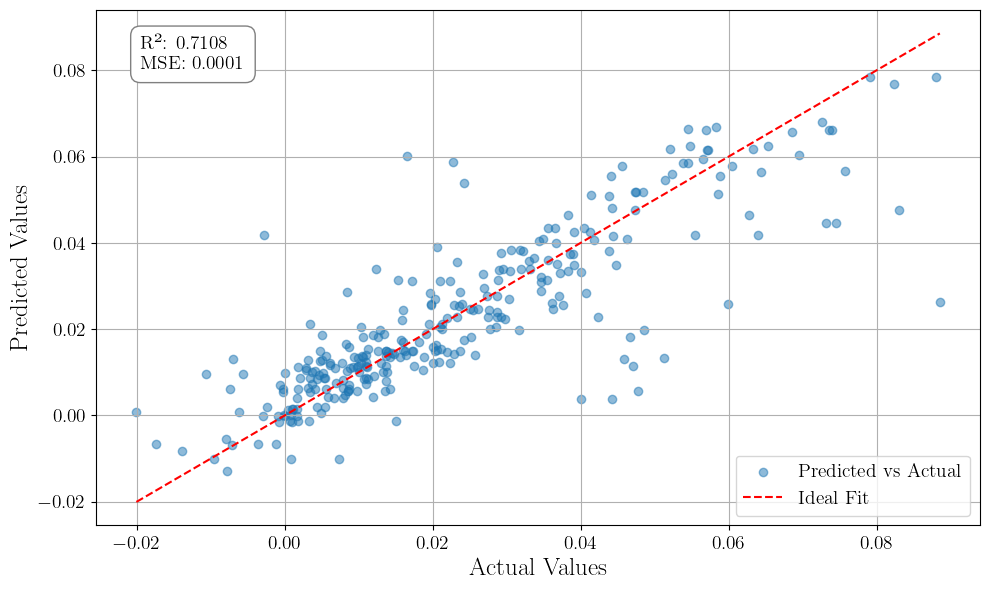

Unique feature names:
['language_Afrikaans' 'language_Arabic' 'language_Bulgarian'
 'language_Catalan' 'language_Chinese' 'language_Czech' 'language_Danish'
 'language_English' 'language_Finnish' 'language_French' 'language_German'
 'language_Greek' 'language_Hebrew' 'language_Hindi' 'language_Hungarian'
 'language_Italian' 'language_Japanese' 'language_Korean'
 'language_Latvian' 'language_Lithuanian' 'language_Norwegian'
 'language_Persian' 'language_Polish' 'language_Portuguese'
 'language_Romanian' 'language_Russian' 'language_Slovak'
 'language_Slovenian' 'language_Spanish' 'language_Swedish'
 'language_Tamil' 'language_Turkish' 'language_Ukrainian'
 'language_Vietnamese' 'aligner_Awesome' 'aligner_Dict'
 'aligner_FastAlign' 'frozen_status_Frozen' 'frozen_status_Vanilla'
 'freeze_location_Back' 'freeze_location_Front' 'freeze_location_None']

Unique groups:
['Language' 'Aligner' 'Freezing Status' 'Freeze Location']


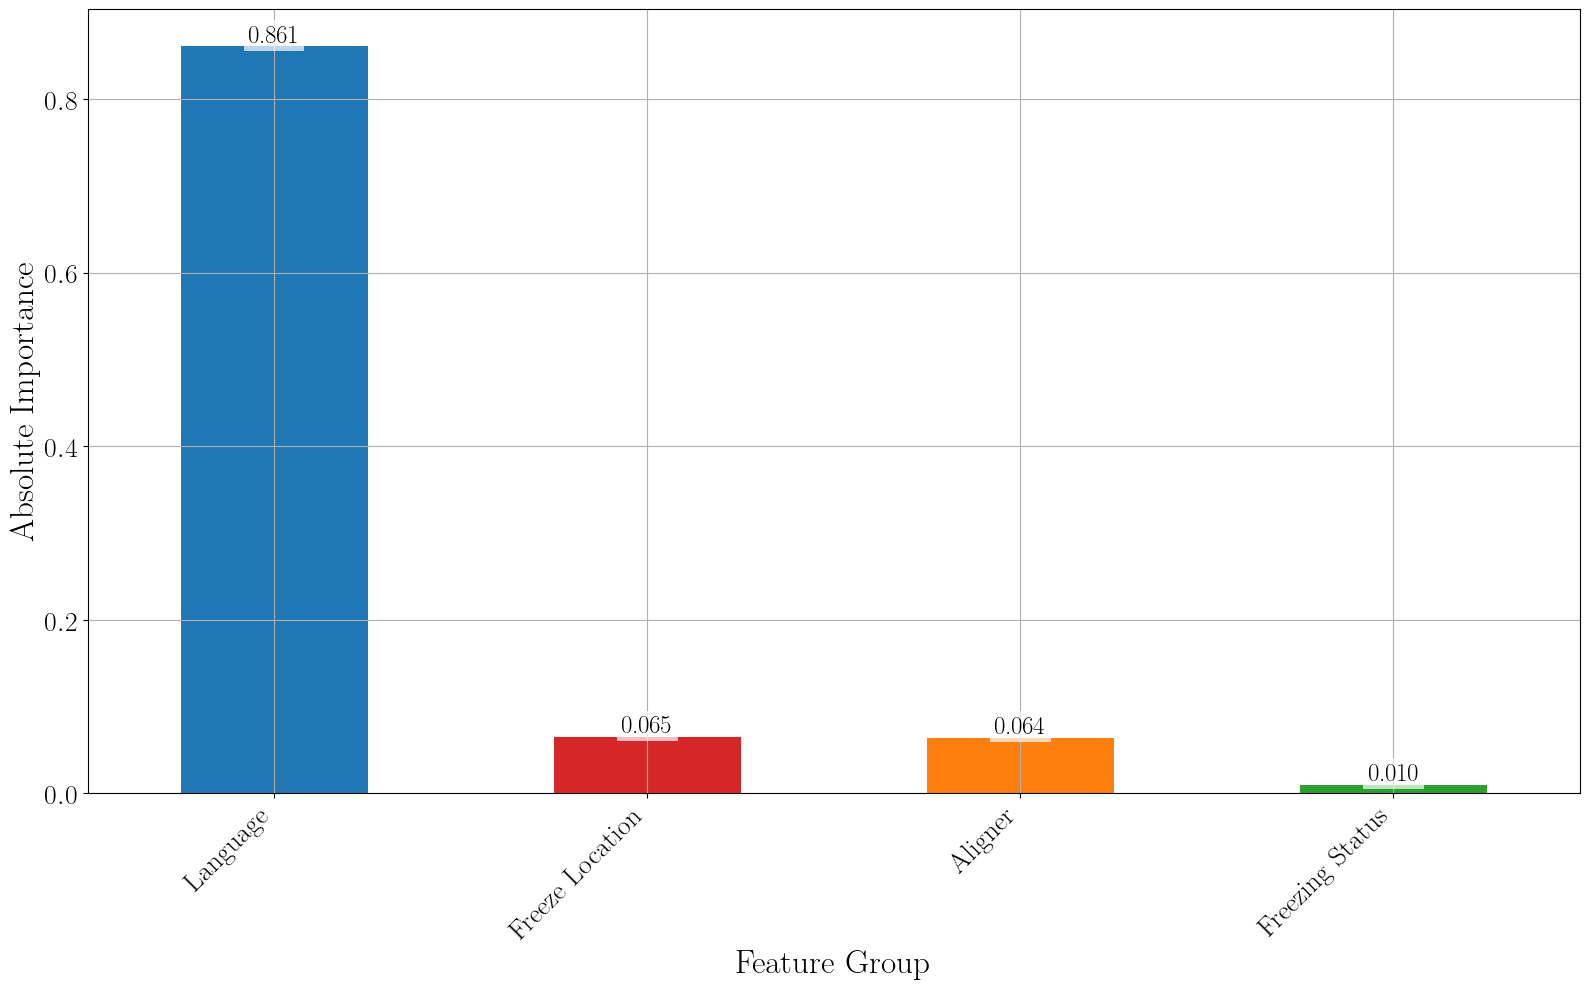


Ranked Aggregated Feature Importances
 Rank           Group  Importance
    1        Language    0.861028
    2 Freeze Location    0.064817
    3         Aligner    0.064101
    4 Freezing Status    0.010054

Ranked Individual Feature Importances
 Rank               Feature           Group  Importance
    1       language_Slovak        Language    0.117924
    2      language_Latvian        Language    0.096506
    3        language_Hindi        Language    0.075437
    4        language_Czech        Language    0.072020
    5       language_Korean        Language    0.059686
    6   language_Lithuanian        Language    0.058836
    7 freeze_location_Front Freeze Location    0.046011
    8        language_Greek        Language    0.041574
    9    language_Slovenian        Language    0.040162
   10       language_Polish        Language    0.039459
   11     language_Romanian        Language    0.031802
   12     language_Japanese        Language    0.031425
   13    language_Ukrain

In [30]:
coefficients, encoded_columns = perform_regression(train_data, val_data, test_data, title='Outliers Removed')

print("Feature Importances:")
print(coefficients)

In [31]:
import warnings

# Suppress all pandas warnings
warnings.filterwarnings("ignore", module="pandas")

# linguistic_features = {
#     'Afrikaans': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Low'},
#     'Arabic': {'script_type': 'Abjad', 'word_order': 'VSO', 'morphological_complexity': 'High'},
#     'Bulgarian': {'script_type': 'Cyrillic', 'word_order': 'SVO', 'morphological_complexity': 'Medium'},
#     'Catalan': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Medium'},
#     'Chinese': {'script_type': 'Chinese', 'word_order': 'SVO', 'morphological_complexity': 'Low'},
#     'Czech': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'High'},
#     'Danish': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Low'},
#     'English': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Low'},
#     'Finnish': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'High'},
#     'French': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Medium'},
#     'German': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Medium'},
#     'Greek': {'script_type': 'Greek', 'word_order': 'SVO', 'morphological_complexity': 'High'},
#     'Hebrew': {'script_type': 'Abjad', 'word_order': 'SVO', 'morphological_complexity': 'High'},
#     'Hindi': {'script_type': 'Devanagari', 'word_order': 'SOV', 'morphological_complexity': 'High'},
#     'Hungarian': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'High'},
#     'Italian': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Medium'},
#     'Japanese': {'script_type': 'Japanese', 'word_order': 'SOV', 'morphological_complexity': 'High'},
#     'Korean': {'script_type': 'Hangul', 'word_order': 'SOV', 'morphological_complexity': 'High'},
#     'Latvian': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'High'},
#     'Lithuanian': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'High'},
#     'Norwegian': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Low'},
#     'Persian': {'script_type': 'Arabic', 'word_order': 'SOV', 'morphological_complexity': 'Medium'},
#     'Polish': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'High'},
#     'Portuguese': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Medium'},
#     'Romanian': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Medium'},
#     'Russian': {'script_type': 'Cyrillic', 'word_order': 'SVO', 'morphological_complexity': 'High'},
#     'Slovak': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'High'},
#     'Slovenian': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'High'},
#     'Spanish': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Medium'},
#     'Swedish': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Low'},
#     'Tamil': {'script_type': 'Abugida', 'word_order': 'SOV', 'morphological_complexity': 'High'},
#     'Thai': {'script_type': 'Abugida', 'word_order': 'SVO', 'morphological_complexity': 'Low'},
#     'Turkish': {'script_type': 'Latin', 'word_order': 'SOV', 'morphological_complexity': 'High'},
#     'Ukrainian': {'script_type': 'Cyrillic', 'word_order': 'SVO', 'morphological_complexity': 'High'},
#     'Vietnamese': {'script_type': 'Latin', 'word_order': 'SVO', 'morphological_complexity': 'Low'}
# }


linguistic_features = {
    'Afrikaans': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Arabic': {'script_type': 'Abjad', 'word_order': 'VSO'},
    'Bulgarian': {'script_type': 'Cyrillic', 'word_order': 'SVO'},
    'Catalan': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Chinese': {'script_type': 'Chinese', 'word_order': 'SVO'},
    'Czech': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Danish': {'script_type': 'Latin', 'word_order': 'SVO'},
    'English': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Finnish': {'script_type': 'Latin', 'word_order': 'SVO'},
    'French': {'script_type': 'Latin', 'word_order': 'SVO'},
    'German': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Greek': {'script_type': 'Greek', 'word_order': 'SVO'},
    'Hebrew': {'script_type': 'Abjad', 'word_order': 'SVO'},
    'Hindi': {'script_type': 'Devanagari', 'word_order': 'SOV'},
    'Hungarian': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Italian': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Japanese': {'script_type': 'Japanese', 'word_order': 'SOV'},
    'Korean': {'script_type': 'Hangul', 'word_order': 'SOV'},
    'Latvian': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Lithuanian': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Norwegian': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Persian': {'script_type': 'Arabic', 'word_order': 'SOV'},
    'Polish': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Portuguese': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Romanian': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Russian': {'script_type': 'Cyrillic', 'word_order': 'SVO'},
    'Slovak': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Slovenian': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Spanish': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Swedish': {'script_type': 'Latin', 'word_order': 'SVO'},
    'Tamil': {'script_type': 'Abugida', 'word_order': 'SOV'},
    'Thai': {'script_type': 'Abugida', 'word_order': 'SVO'},
    'Turkish': {'script_type': 'Latin', 'word_order': 'SOV'},
    'Ukrainian': {'script_type': 'Cyrillic', 'word_order': 'SVO'},
    'Vietnamese': {'script_type': 'Latin', 'word_order': 'SVO'}
}

def add_linguistic_features(df):
    df = df.copy()
    df['script_type'] = df['language'].map(lambda x: linguistic_features.get(x, {}).get('script_type'))
    df['word_order'] = df['language'].map(lambda x: linguistic_features.get(x, {}).get('word_order'))
    # df['morphological_complexity'] = df['language'].map(lambda x: linguistic_features.get(x, {}).get('morphological_complexity'))
    return df


In [32]:
df_clean = add_linguistic_features(df_clean)

In [33]:
df_clean = add_language_distances_to_df(df_clean)

In [34]:
train_data, val_data, test_data = split_train_val_test(df_clean)

100%|██████████| 59/59 [00:00<00:00, 178.63it/s]



Final Test MSE for Outliers Removed (Random Forest): 0.00012870136242163914


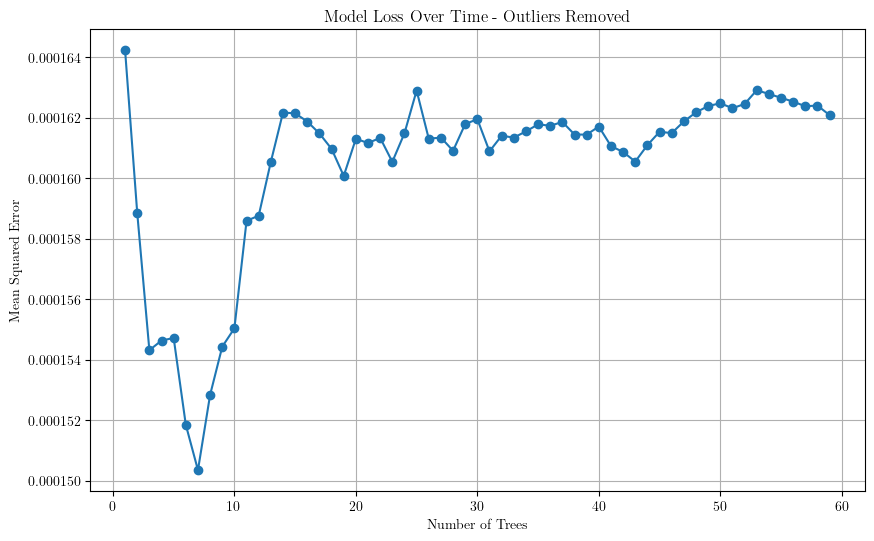

C:\Users\alith\AppData\Local\Temp\ipykernel_181880\3614062542.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels, fontsize=14)  # Increased font size for y-axis labels


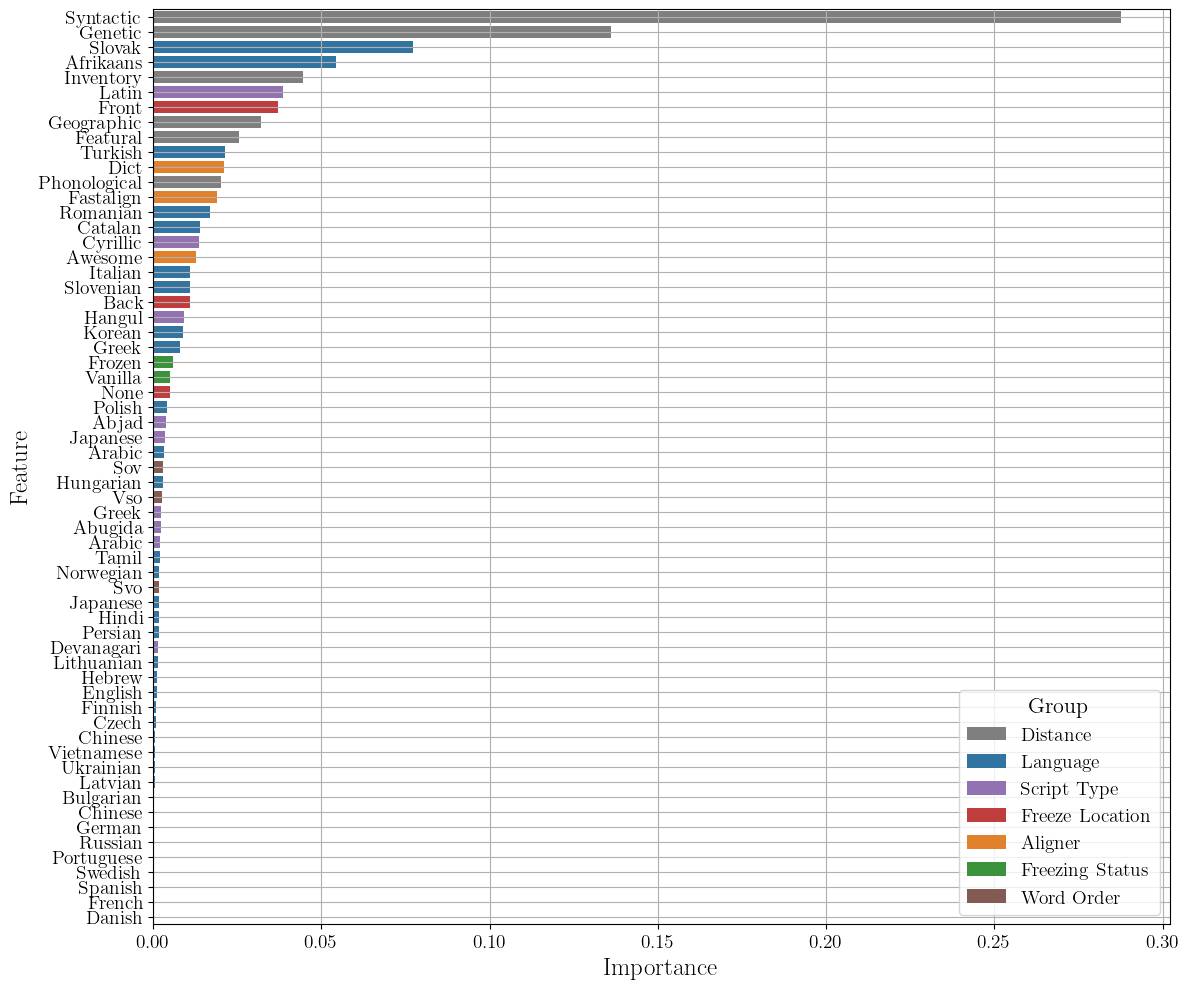

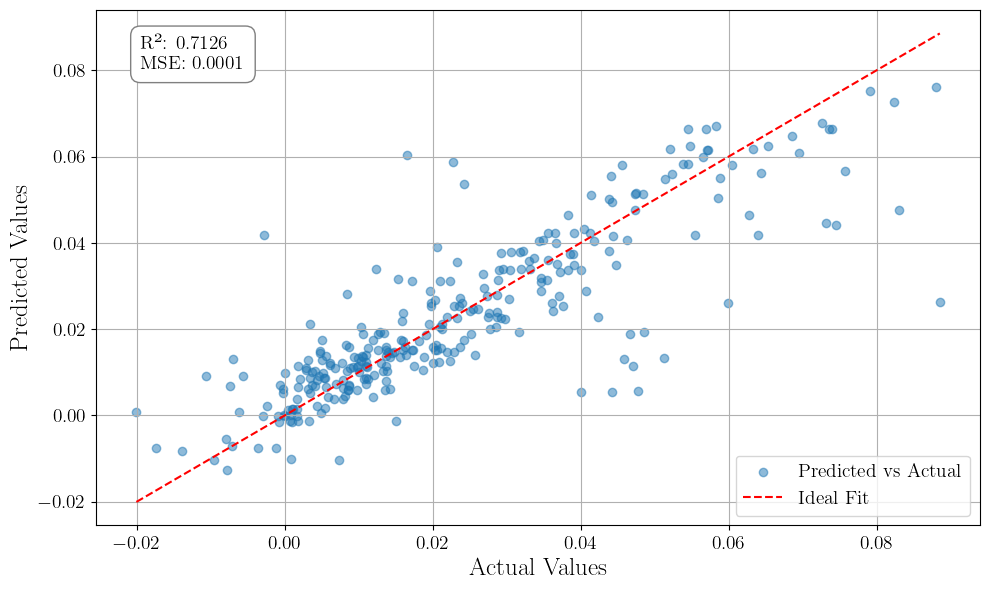

Unique feature names:
['syntactic' 'geographic' 'phonological' 'genetic' 'inventory' 'featural'
 'language_Afrikaans' 'language_Arabic' 'language_Bulgarian'
 'language_Catalan' 'language_Chinese' 'language_Czech' 'language_Danish'
 'language_English' 'language_Finnish' 'language_French' 'language_German'
 'language_Greek' 'language_Hebrew' 'language_Hindi' 'language_Hungarian'
 'language_Italian' 'language_Japanese' 'language_Korean'
 'language_Latvian' 'language_Lithuanian' 'language_Norwegian'
 'language_Persian' 'language_Polish' 'language_Portuguese'
 'language_Romanian' 'language_Russian' 'language_Slovak'
 'language_Slovenian' 'language_Spanish' 'language_Swedish'
 'language_Tamil' 'language_Turkish' 'language_Ukrainian'
 'language_Vietnamese' 'aligner_Awesome' 'aligner_Dict'
 'aligner_FastAlign' 'frozen_status_Frozen' 'frozen_status_Vanilla'
 'freeze_location_Back' 'freeze_location_Front' 'freeze_location_None'
 'script_type_Abjad' 'script_type_Abugida' 'script_type_Arabic'
 'sc

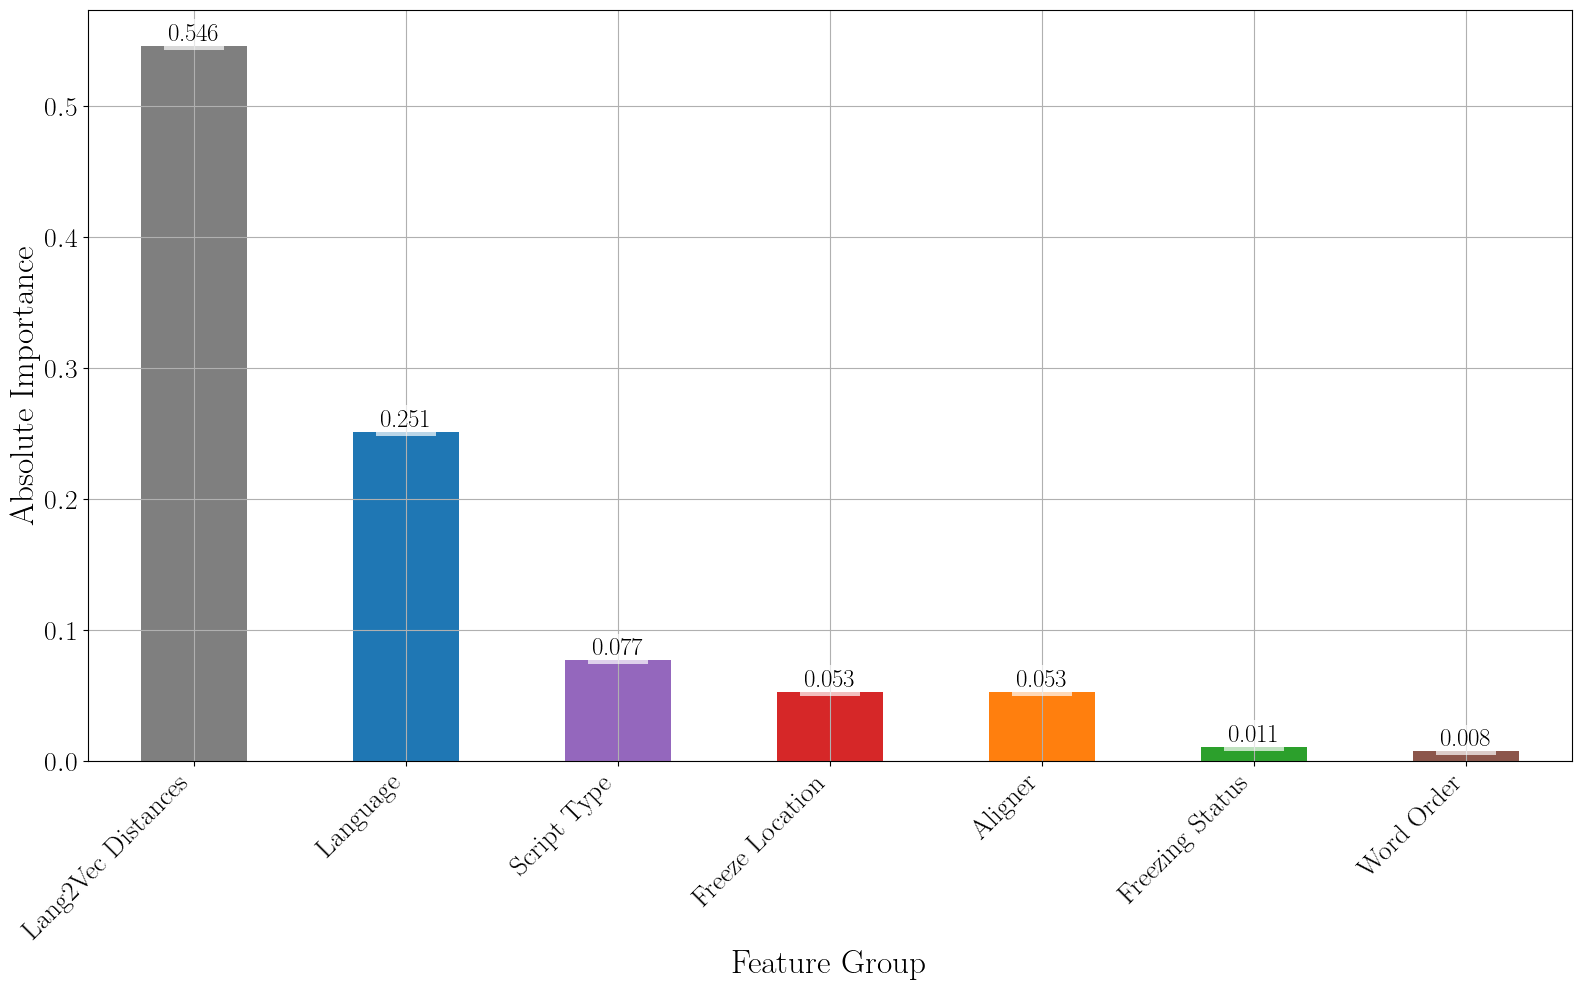


Ranked Aggregated Feature Importances
 Rank              Group  Importance
    1 Lang2Vec Distances    0.546326
    2           Language    0.251468
    3        Script Type    0.077309
    4    Freeze Location    0.053189
    5            Aligner    0.053129
    6    Freezing Status    0.010947
    7         Word Order    0.007633

Ranked Individual Feature Importances
 Rank               Feature              Group  Importance
    1             syntactic Lang2Vec Distances    0.287728
    2               genetic Lang2Vec Distances    0.136050
    3       language_Slovak           Language    0.077377
    4    language_Afrikaans           Language    0.054448
    5             inventory Lang2Vec Distances    0.044627
    6     script_type_Latin        Script Type    0.038519
    7 freeze_location_Front    Freeze Location    0.037254
    8            geographic Lang2Vec Distances    0.031955
    9              featural Lang2Vec Distances    0.025672
   10      language_Turkish         

In [35]:
coefficients, encoded_columns = perform_regression(train_data, val_data, test_data, title='Outliers Removed')

print("Feature Importances:")
print(coefficients)

In [36]:
df = add_language_distances_to_df(df)
df = add_linguistic_features(df)

train_data, val_data, test_data = split_train_val_test(df)

100%|██████████| 59/59 [00:00<00:00, 204.60it/s]


Final Test MSE for All Data (Random Forest): 0.00031636842898888367


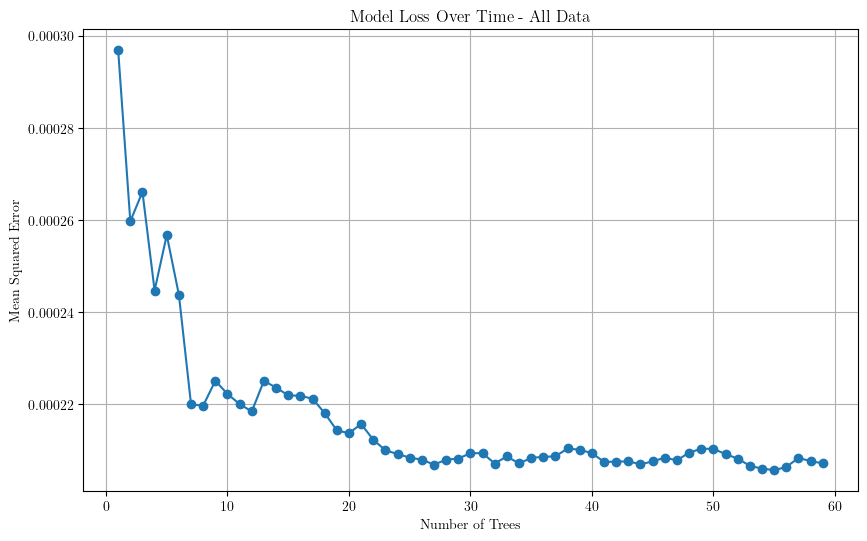

C:\Users\alith\AppData\Local\Temp\ipykernel_181880\3614062542.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels, fontsize=14)  # Increased font size for y-axis labels


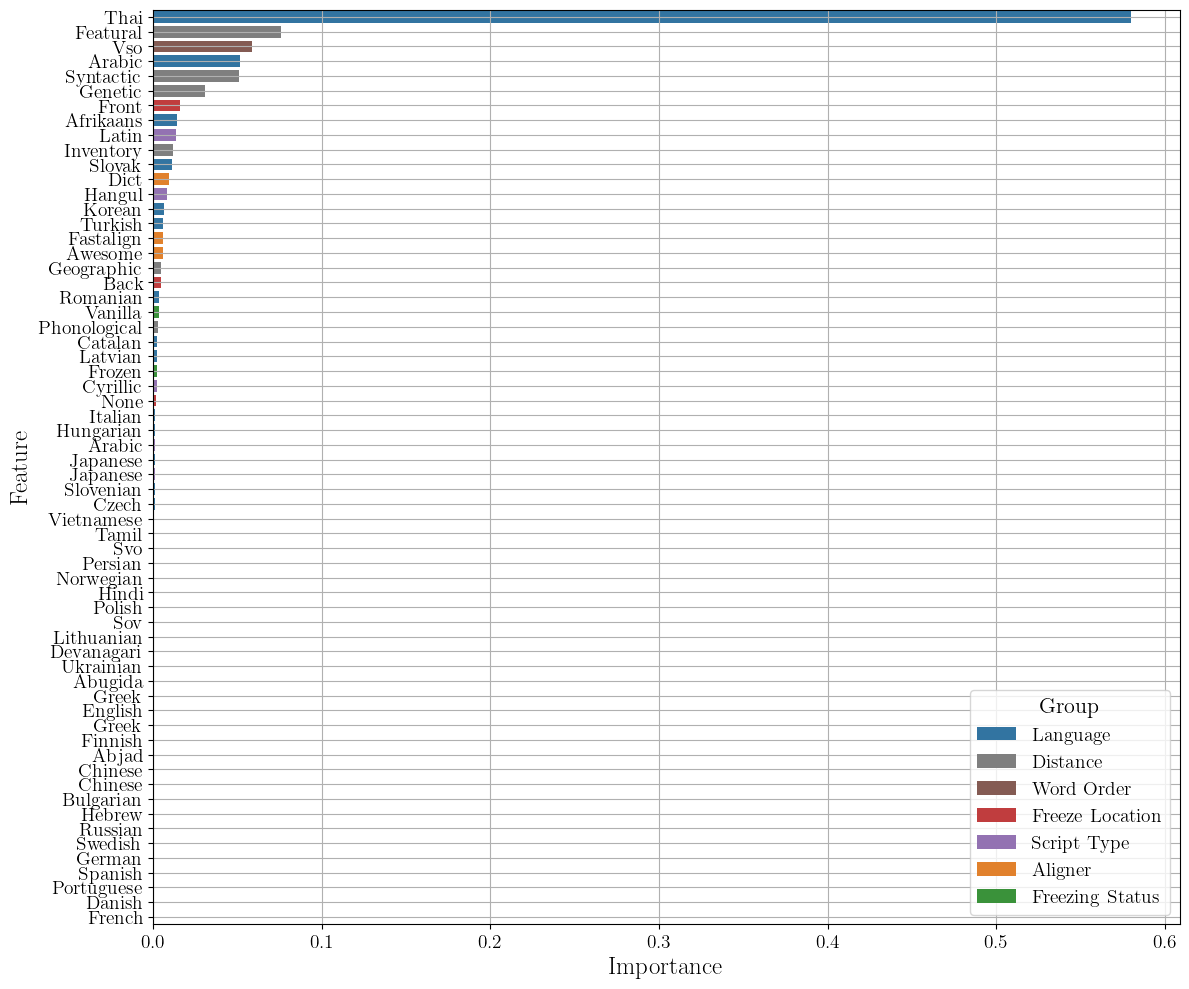

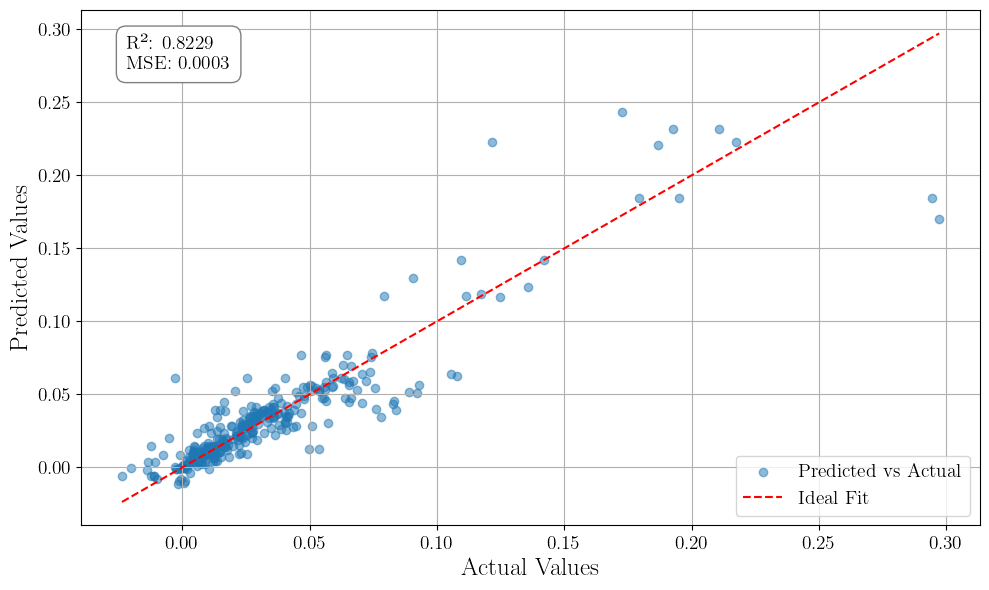

Unique feature names:
['syntactic' 'geographic' 'phonological' 'genetic' 'inventory' 'featural'
 'language_Afrikaans' 'language_Arabic' 'language_Bulgarian'
 'language_Catalan' 'language_Chinese' 'language_Czech' 'language_Danish'
 'language_English' 'language_Finnish' 'language_French' 'language_German'
 'language_Greek' 'language_Hebrew' 'language_Hindi' 'language_Hungarian'
 'language_Italian' 'language_Japanese' 'language_Korean'
 'language_Latvian' 'language_Lithuanian' 'language_Norwegian'
 'language_Persian' 'language_Polish' 'language_Portuguese'
 'language_Romanian' 'language_Russian' 'language_Slovak'
 'language_Slovenian' 'language_Spanish' 'language_Swedish'
 'language_Tamil' 'language_Thai' 'language_Turkish' 'language_Ukrainian'
 'language_Vietnamese' 'aligner_Awesome' 'aligner_Dict'
 'aligner_FastAlign' 'frozen_status_Frozen' 'frozen_status_Vanilla'
 'freeze_location_Back' 'freeze_location_Front' 'freeze_location_None'
 'script_type_Abjad' 'script_type_Abugida' 'script_t

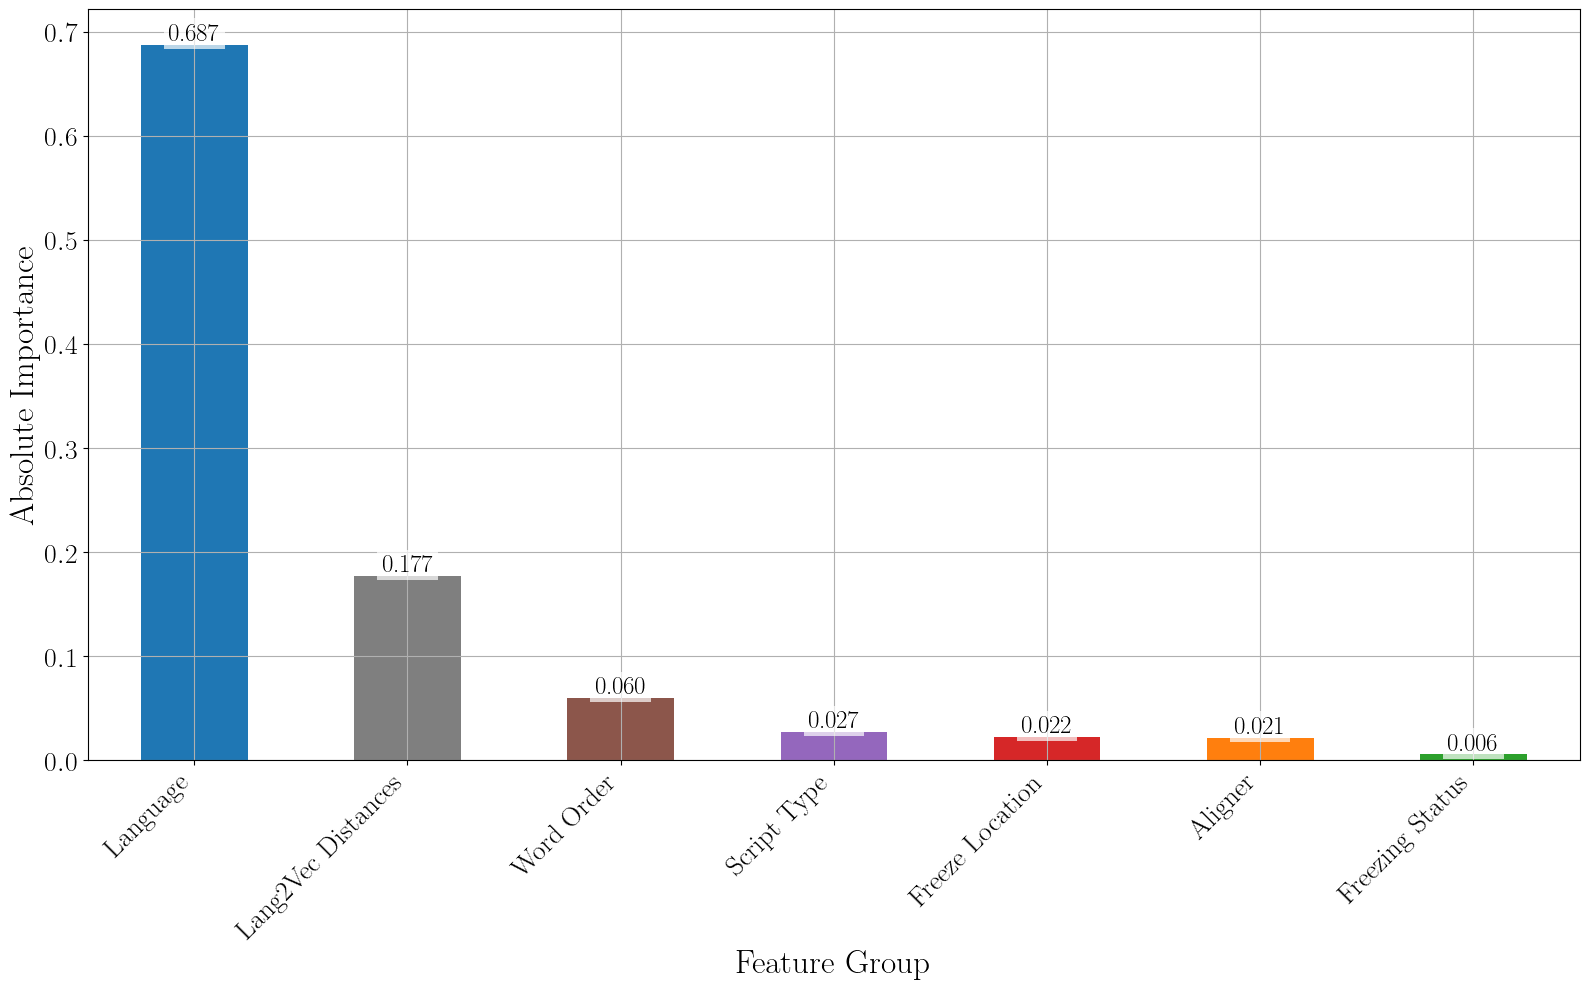


Ranked Aggregated Feature Importances
 Rank              Group  Importance
    1           Language    0.687256
    2 Lang2Vec Distances    0.176926
    3         Word Order    0.059552
    4        Script Type    0.026980
    5    Freeze Location    0.022291
    6            Aligner    0.021445
    7    Freezing Status    0.005549

Ranked Individual Feature Importances
 Rank               Feature              Group  Importance
    1         language_Thai           Language    0.579898
    2              featural Lang2Vec Distances    0.075630
    3        word_order_VSO         Word Order    0.058811
    4       language_Arabic           Language    0.051662
    5             syntactic Lang2Vec Distances    0.050744
    6               genetic Lang2Vec Distances    0.030699
    7 freeze_location_Front    Freeze Location    0.015777
    8    language_Afrikaans           Language    0.013942
    9     script_type_Latin        Script Type    0.013374
   10             inventory Lang2Vec

In [37]:
coefficients, encoded_columns = perform_regression(train_data, val_data, test_data, title='All Data')

print("Feature Importances:")
print(coefficients)

In [38]:
df[df['language'] == 'Thai'].sort_values('delta_accuracy', ascending=False)

,language,delta_accuracy,aligner,frozen_status,freeze_location,syntactic,geographic,phonological,genetic,inventory,featural,script_type,word_order
2602,Thai,0.336332,Dict,Frozen,Back,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO
2587,Thai,0.333512,Dict,Vanilla,None,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO
2586,Thai,0.325276,Awesome,Vanilla,None,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO
2601,Thai,0.314041,Awesome,Frozen,Back,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO
2592,Thai,0.297211,Awesome,Frozen,Front,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO
2585,Thai,0.297211,FastAlign,Vanilla,None,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO
2600,Thai,0.294884,FastAlign,Frozen,Back,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO
2593,Thai,0.294257,Dict,Frozen,Front,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO
2591,Thai,0.278546,FastAlign,Frozen,Front,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO
607,Thai,0.241395,Dict,Frozen,Back,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO


In [39]:
df_clean.groupby('language').count()

,delta_accuracy,aligner,frozen_status,freeze_location,script_type,word_order,syntactic,geographic,phonological,genetic,inventory,featural
language,,,,,,,,,,,,
Afrikaans,45,45,45,45,45,45,45,45,45,45,45,45
Arabic,5,5,5,5,5,5,5,5,5,5,5,5
Bulgarian,45,45,45,45,45,45,45,45,45,45,45,45
Catalan,45,45,45,45,45,45,45,45,45,45,45,45
Chinese,45,45,45,45,45,45,45,45,45,45,45,45
Czech,45,45,45,45,45,45,45,45,45,45,45,45
Danish,45,45,45,45,45,45,45,45,45,45,45,45
English,45,45,45,45,45,45,45,45,45,45,45,45
Finnish,45,45,45,45,45,45,45,45,45,45,45,45


In [40]:
df_clean.head()

,language,delta_accuracy,aligner,frozen_status,freeze_location,script_type,word_order,syntactic,geographic,phonological,genetic,inventory,featural
1,Afrikaans,0.014406,FastAlign,Vanilla,None,Latin,SVO,0.63,0.4,0.5687,0.6,0.5144,0.6
2,Afrikaans,0.012618,Awesome,Vanilla,None,Latin,SVO,0.63,0.4,0.5687,0.6,0.5144,0.6
3,Afrikaans,0.002086,Dict,Vanilla,None,Latin,SVO,0.63,0.4,0.5687,0.6,0.5144,0.6
7,Afrikaans,0.011128,FastAlign,Frozen,Front,Latin,SVO,0.63,0.4,0.5687,0.6,0.5144,0.6
8,Afrikaans,0.011227,Awesome,Frozen,Front,Latin,SVO,0.63,0.4,0.5687,0.6,0.5144,0.6


In [41]:
nli_csv_path = './distilMBERT_nli_data/distilbert-base-multilingual-cased__xnli__opus100.csv'

In [42]:
nli_df = read_and_process_csv(nli_csv_path, model_name='distilMBERT')
nli_df = nli_df[~nli_df.isna().any(axis=1)]

In [43]:
nli_df

,model,method,language,seed,accuracy
0,distilMBERT,Before FastAlign,English,31,0.773852
1,distilMBERT,Before FastAlign,Arabic,31,0.618363
2,distilMBERT,Before FastAlign,Bulgarian,31,0.656287
3,distilMBERT,Before FastAlign,German,31,0.672455
4,distilMBERT,Before FastAlign,Greek,31,0.640319
...,...,...,...,...,...
792,distilMBERT,Before - Back Freeze Dict,Russian,17,0.635729
793,distilMBERT,Before - Back Freeze Dict,Thai,17,0.505389
794,distilMBERT,Before - Back Freeze Dict,Turkish,17,0.615569
795,distilMBERT,Before - Back Freeze Dict,Vietnamese,17,0.657086


In [44]:
nli_df = process_dataframe(nli_df, group_by_columns=['model', 'seed', 'language'])
nli_df

C:\Users\alith\AppData\Local\Temp\ipykernel_181880\2421398949.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(group_by_columns, group_keys=False).apply(calculate_delta_accuracy)


,model,method,language,seed,accuracy,delta_accuracy
0,distilMBERT,Fine-tuning Only,Arabic,17,0.597206,NaN
1,distilMBERT,Before FastAlign,Arabic,17,0.611377,0.014172
2,distilMBERT,Before Awesome,Arabic,17,0.619361,0.022156
3,distilMBERT,Before Dict,Arabic,17,0.598603,0.001397
4,distilMBERT,Before - Front Freeze FastAlign,Arabic,17,0.592415,-0.004790
...,...,...,...,...,...,...
645,distilMBERT,Before - Front Freeze Awesome,Vietnamese,66,0.656886,0.098403
646,distilMBERT,Before - Front Freeze Dict,Vietnamese,66,0.661078,0.102595
647,distilMBERT,Before - Back Freeze FastAlign,Vietnamese,66,0.657485,0.099002
648,distilMBERT,Before - Back Freeze Awesome,Vietnamese,66,0.663673,0.105190


In [45]:
nli_df.dropna(subset=['accuracy'], inplace=True)

# Drop rows with NaNs in 'delta_accuracy' column (if applicable)
nli_df.dropna(subset=['delta_accuracy'], inplace=True)

nli_df.drop('model', axis=1, inplace=True)

nli_df.drop('accuracy', axis=1, inplace=True)

nli_df.drop('seed', axis=1, inplace=True)

nli_df

,method,language,delta_accuracy
1,Before FastAlign,Arabic,0.014172
2,Before Awesome,Arabic,0.022156
3,Before Dict,Arabic,0.001397
4,Before - Front Freeze FastAlign,Arabic,-0.004790
5,Before - Front Freeze Awesome,Arabic,0.005589
...,...,...,...
645,Before - Front Freeze Awesome,Vietnamese,0.098403
646,Before - Front Freeze Dict,Vietnamese,0.102595
647,Before - Back Freeze FastAlign,Vietnamese,0.099002
648,Before - Back Freeze Awesome,Vietnamese,0.105190


In [46]:
nli_df = split_method_column(nli_df)

In [47]:
# nli_df['task'] = 'NLI'

In [48]:
nli_df

,language,delta_accuracy,aligner,frozen_status,freeze_location
1,Arabic,0.014172,FastAlign,Vanilla,None
2,Arabic,0.022156,Awesome,Vanilla,None
3,Arabic,0.001397,Dict,Vanilla,None
4,Arabic,-0.004790,FastAlign,Frozen,Front
5,Arabic,0.005589,Awesome,Frozen,Front
...,...,...,...,...,...
645,Vietnamese,0.098403,Awesome,Frozen,Front
646,Vietnamese,0.102595,Dict,Frozen,Front
647,Vietnamese,0.099002,FastAlign,Frozen,Back
648,Vietnamese,0.105190,Awesome,Frozen,Back


In [49]:
nli_df = add_language_distances_to_df(nli_df)

In [50]:
nli_df = add_linguistic_features(nli_df)

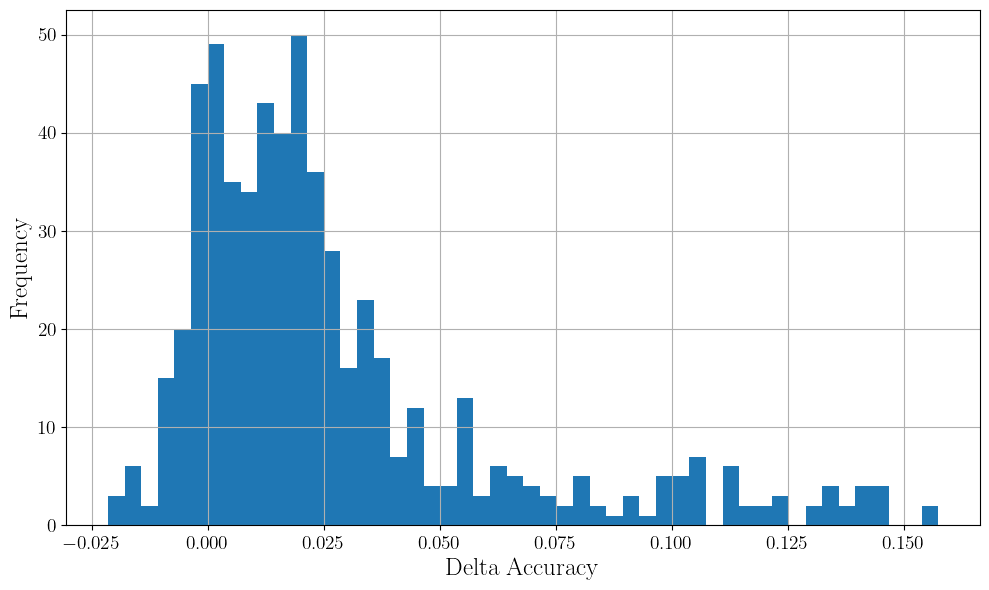

Number of outliers removed: 55
Shape of data before removing outliers: (585, 13)
Shape of data after removing outliers: (530, 13)


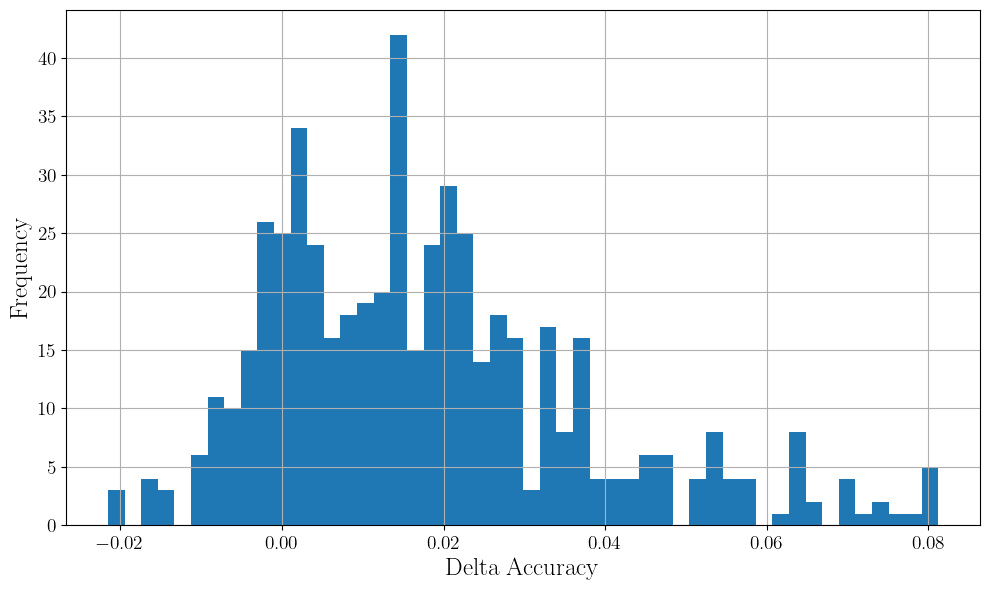


Statistics before removing outliers:
count    585.000000
mean       0.027314
std        0.034922
min       -0.021557
25%        0.003992
50%        0.018164
75%        0.034930
max        0.157485
Name: delta_accuracy, dtype: float64

Statistics after removing outliers:
count    530.000000
mean       0.018032
std        0.019721
min       -0.021557
25%        0.002794
50%        0.014770
75%        0.027096
max        0.081238
Name: delta_accuracy, dtype: float64

Outlier Analysis:

Top 10 Languages in Outliers:
language
Thai          37
Vietnamese    18
Name: count, dtype: int64

Word Aligners in Outliers:
aligner
Awesome      19
FastAlign    18
Dict         18
Name: count, dtype: int64

Freezing Status in Outliers:
frozen_status
Frozen     34
Vanilla    21
Name: count, dtype: int64

Freeze Location in Outliers:
freeze_location
None     21
Back     21
Front    13
Name: count, dtype: int64

Top 10 Highest Delta Accuracy Outliers:
    language  aligner frozen_status freeze_location  de

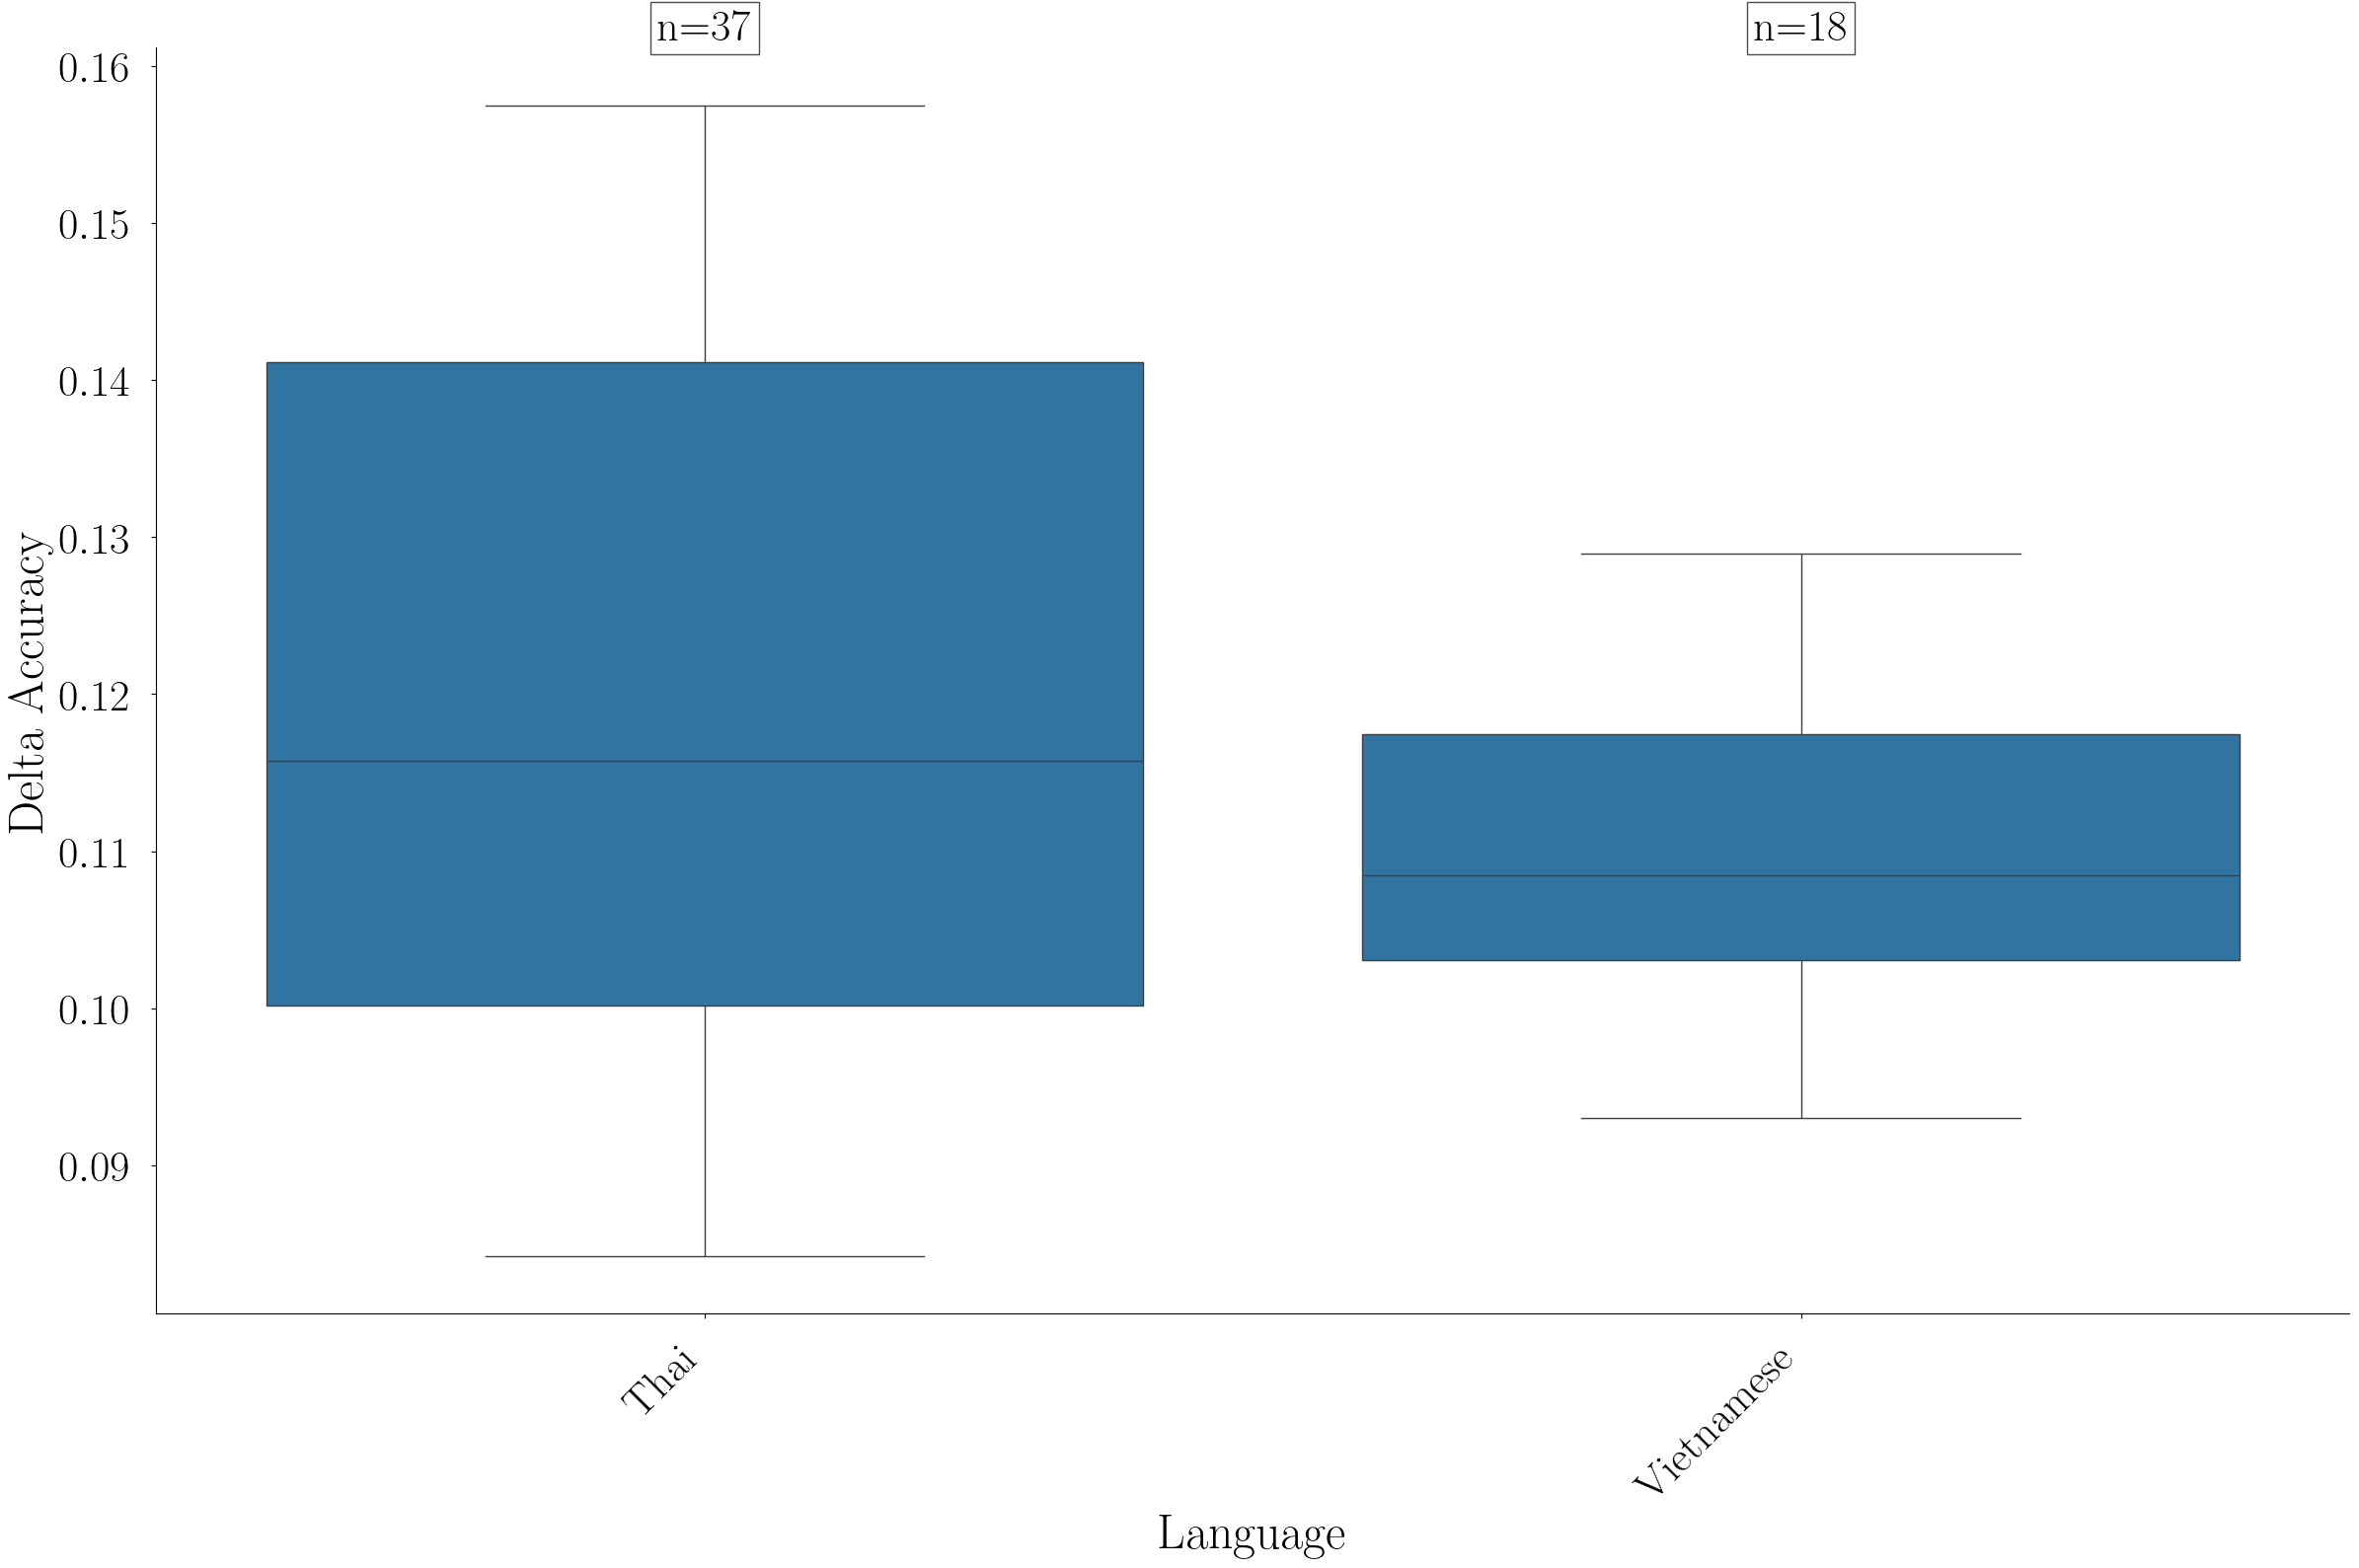


Summary Statistics for Outliers:
            count      mean       std       min       25%       50%       75%  \
language                                                                        
Thai         37.0  0.119960  0.022228  0.084232  0.100200  0.115768  0.141118   
Vietnamese   18.0  0.110169  0.010566  0.093014  0.103094  0.108483  0.117465   

                 max  
language              
Thai        0.157485  
Vietnamese  0.128942  


In [51]:
clean_nli_df, nli_outliers = analyze_and_remove_outliers(nli_df)

In [52]:
nli_df[nli_df['language'] == 'Thai'].sort_values('delta_accuracy', ascending=False)

,language,delta_accuracy,aligner,frozen_status,freeze_location,syntactic,geographic,phonological,genetic,inventory,featural,script_type,word_order
233,Thai,0.157485,Dict,Vanilla,None,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO
239,Thai,0.157485,Dict,Frozen,Back,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO
362,Thai,0.146507,Awesome,Vanilla,None,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO
368,Thai,0.146507,Awesome,Frozen,Back,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO
232,Thai,0.143912,Awesome,Vanilla,None,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO
238,Thai,0.143912,Awesome,Frozen,Back,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO
499,Thai,0.141916,Dict,Frozen,Back,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO
493,Thai,0.141916,Dict,Vanilla,None,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO
369,Thai,0.141118,Dict,Frozen,Back,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO
363,Thai,0.141118,Dict,Vanilla,None,0.56,0.5,0.39,1.0,0.4147,0.5,Abugida,SVO


In [53]:
train_data, val_data, test_data = split_train_val_test(nli_df)

100%|██████████| 59/59 [00:00<00:00, 187.53it/s]


Final Test MSE for All Data (Random Forest): 0.00012271169413415075


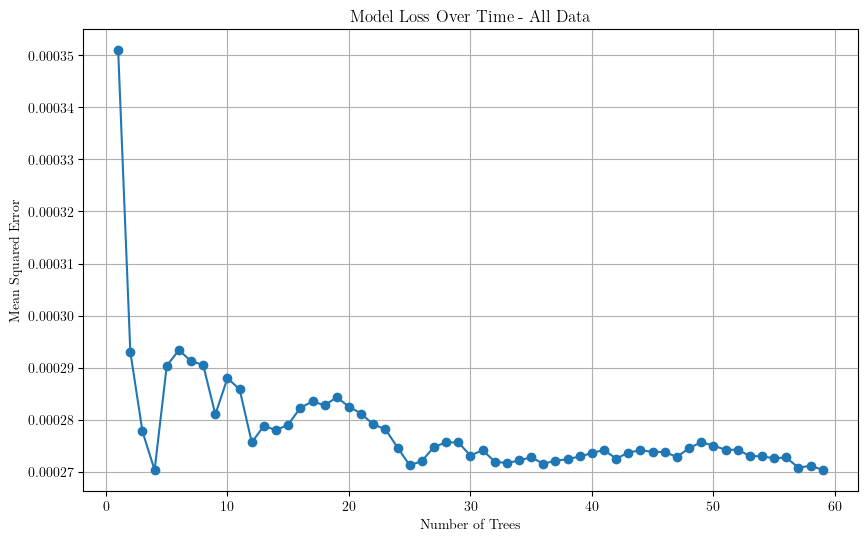

C:\Users\alith\AppData\Local\Temp\ipykernel_181880\3614062542.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels, fontsize=14)  # Increased font size for y-axis labels


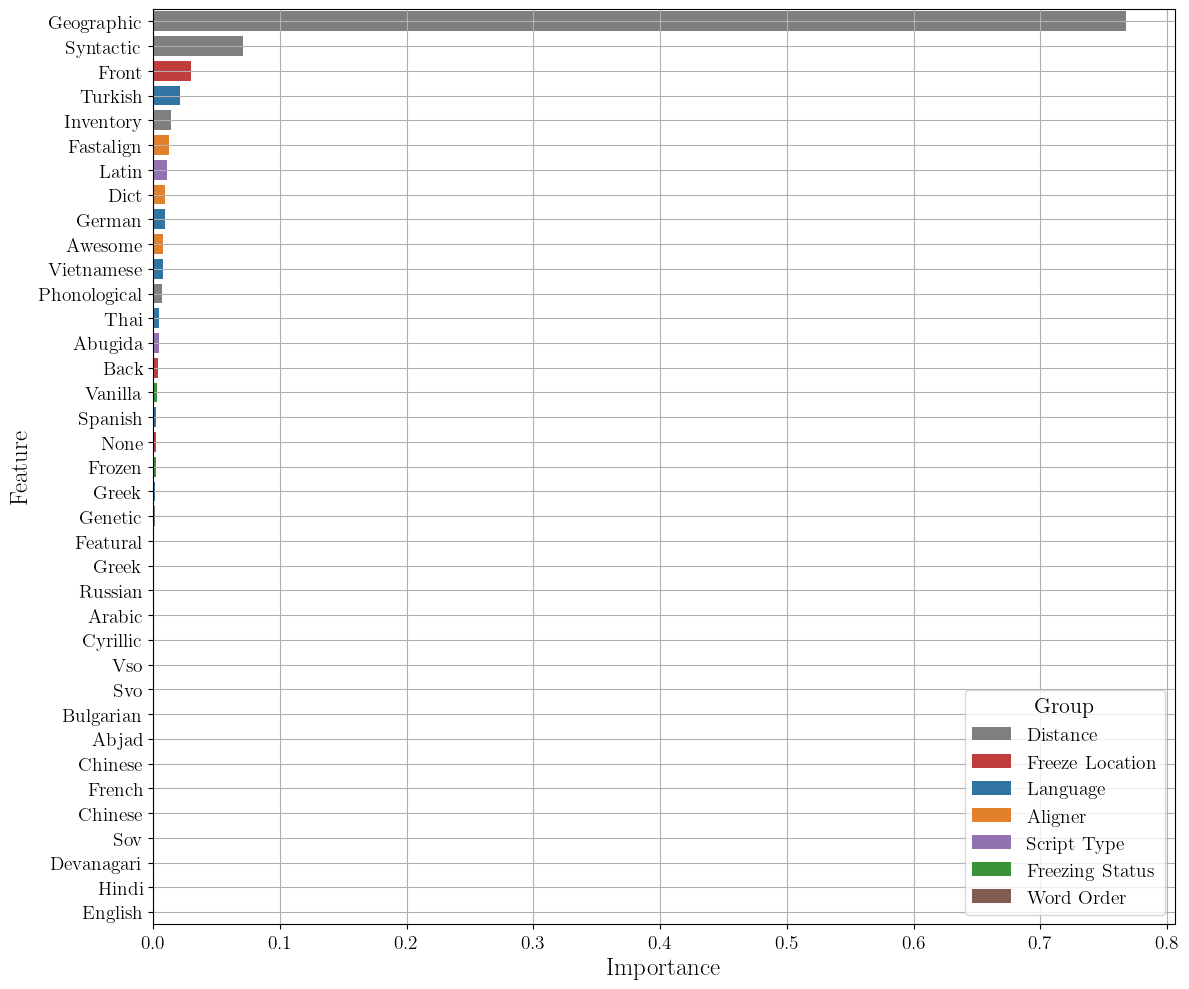

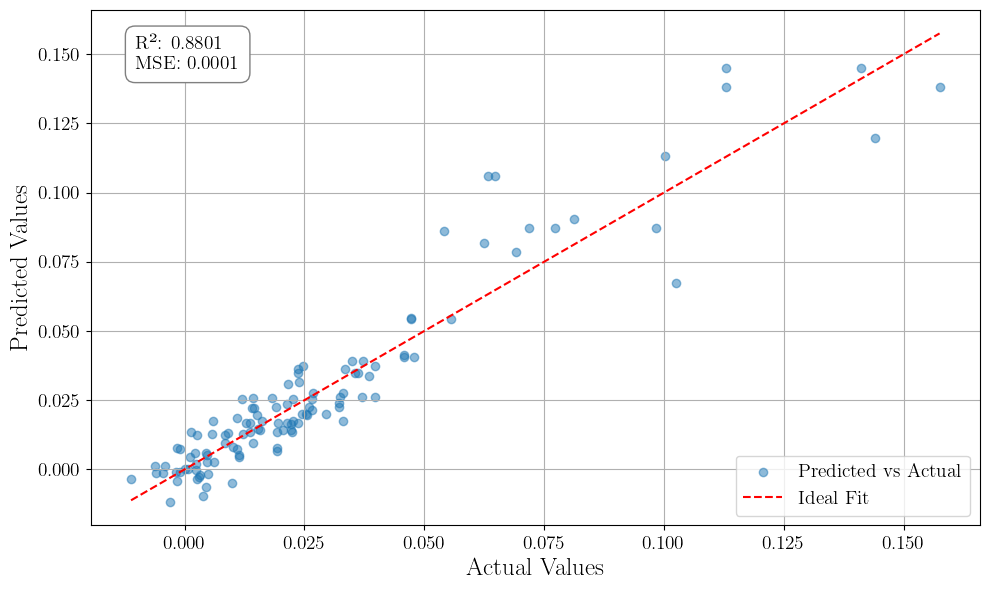

Unique feature names:
['syntactic' 'geographic' 'phonological' 'genetic' 'inventory' 'featural'
 'language_Arabic' 'language_Bulgarian' 'language_Chinese'
 'language_English' 'language_French' 'language_German' 'language_Greek'
 'language_Hindi' 'language_Russian' 'language_Spanish' 'language_Thai'
 'language_Turkish' 'language_Vietnamese' 'aligner_Awesome' 'aligner_Dict'
 'aligner_FastAlign' 'frozen_status_Frozen' 'frozen_status_Vanilla'
 'freeze_location_Back' 'freeze_location_Front' 'freeze_location_None'
 'script_type_Abjad' 'script_type_Abugida' 'script_type_Chinese'
 'script_type_Cyrillic' 'script_type_Devanagari' 'script_type_Greek'
 'script_type_Latin' 'word_order_SOV' 'word_order_SVO' 'word_order_VSO']

Unique groups:
['Lang2Vec Distances' 'Language' 'Aligner' 'Freezing Status'
 'Freeze Location' 'Script Type' 'Word Order']


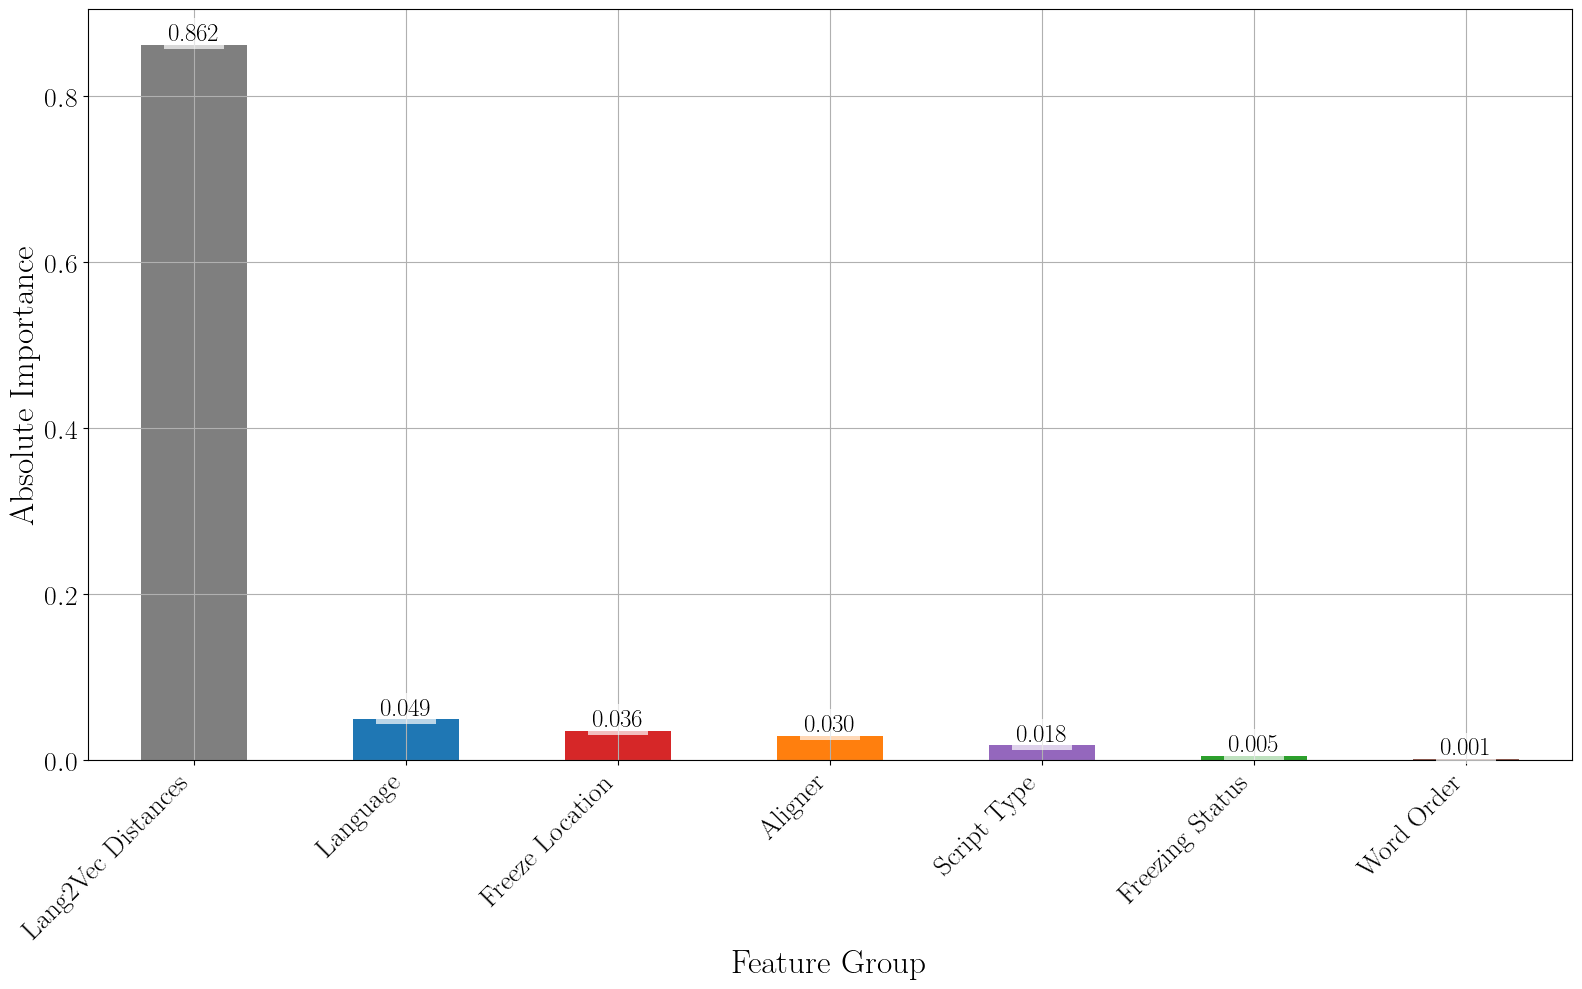


Ranked Aggregated Feature Importances
 Rank              Group  Importance
    1 Lang2Vec Distances    0.861717
    2           Language    0.049066
    3    Freeze Location    0.035590
    4            Aligner    0.029524
    5        Script Type    0.017693
    6    Freezing Status    0.005370
    7         Word Order    0.001041

Ranked Individual Feature Importances
 Rank               Feature              Group  Importance
    1            geographic Lang2Vec Distances    0.767858
    2             syntactic Lang2Vec Distances    0.070766
    3 freeze_location_Front    Freeze Location    0.029557
    4      language_Turkish           Language    0.021090
    5             inventory Lang2Vec Distances    0.014159
    6     aligner_FastAlign            Aligner    0.012346
    7     script_type_Latin        Script Type    0.011242
    8          aligner_Dict            Aligner    0.009404
    9       language_German           Language    0.009357
   10       aligner_Awesome         

In [54]:
coefficients, encoded_columns = perform_regression(train_data, val_data, test_data, title='All Data')

print("Feature Importances:")
print(coefficients)

In [55]:
train_data, val_data, test_data = split_train_val_test(clean_nli_df)

100%|██████████| 59/59 [00:00<00:00, 350.09it/s]



Final Test MSE for Outliers Removed (Random Forest): 5.05486153158173e-05


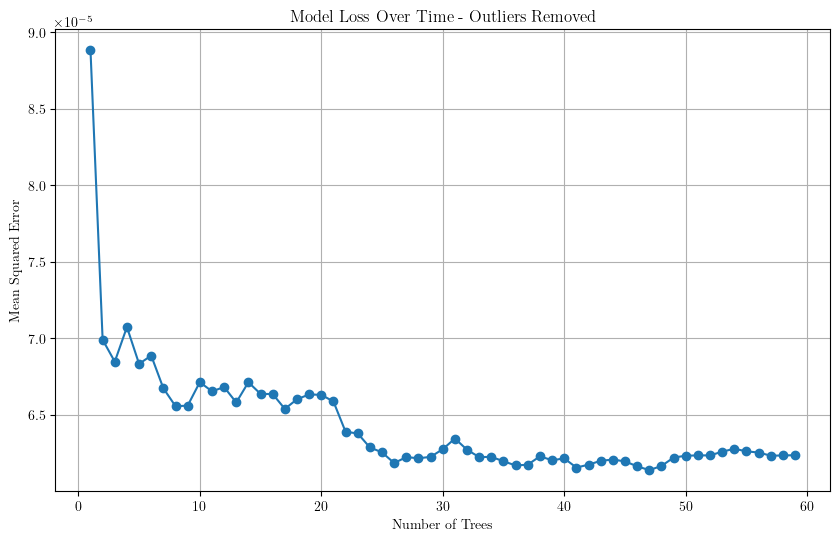

C:\Users\alith\AppData\Local\Temp\ipykernel_181880\3614062542.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels, fontsize=14)  # Increased font size for y-axis labels


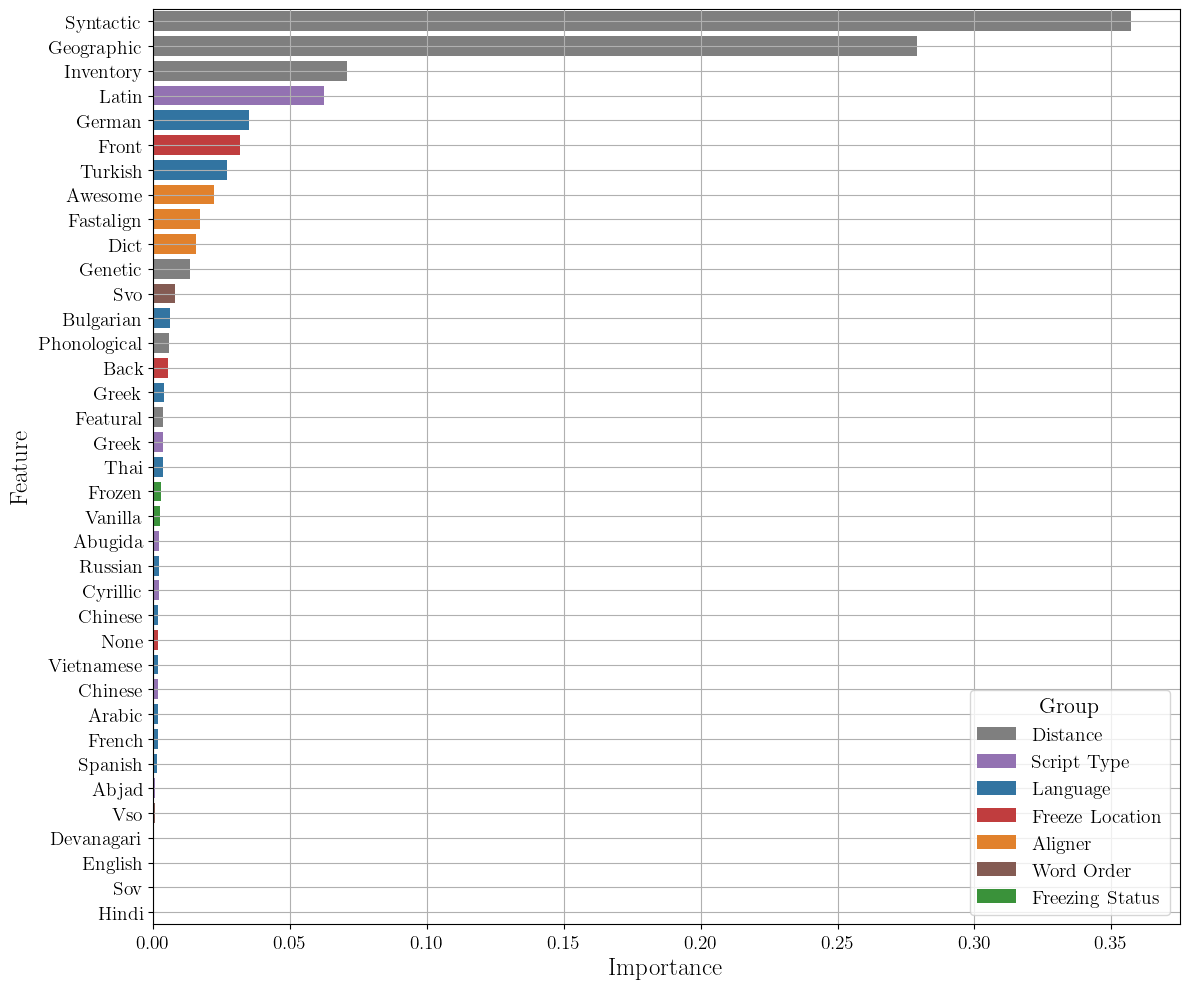

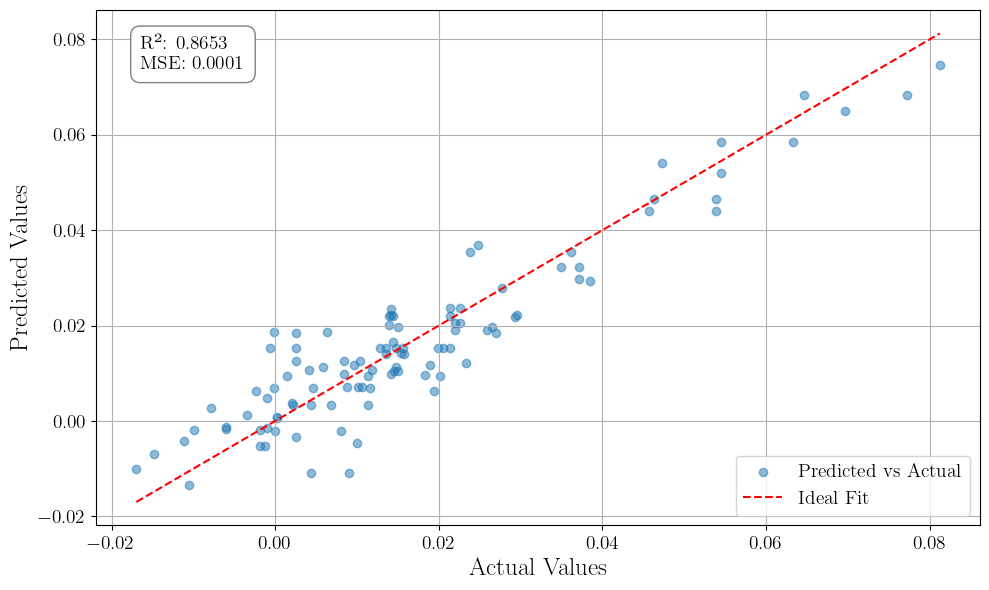

Unique feature names:
['syntactic' 'geographic' 'phonological' 'genetic' 'inventory' 'featural'
 'language_Arabic' 'language_Bulgarian' 'language_Chinese'
 'language_English' 'language_French' 'language_German' 'language_Greek'
 'language_Hindi' 'language_Russian' 'language_Spanish' 'language_Thai'
 'language_Turkish' 'language_Vietnamese' 'aligner_Awesome' 'aligner_Dict'
 'aligner_FastAlign' 'frozen_status_Frozen' 'frozen_status_Vanilla'
 'freeze_location_Back' 'freeze_location_Front' 'freeze_location_None'
 'script_type_Abjad' 'script_type_Abugida' 'script_type_Chinese'
 'script_type_Cyrillic' 'script_type_Devanagari' 'script_type_Greek'
 'script_type_Latin' 'word_order_SOV' 'word_order_SVO' 'word_order_VSO']

Unique groups:
['Lang2Vec Distances' 'Language' 'Aligner' 'Freezing Status'
 'Freeze Location' 'Script Type' 'Word Order']


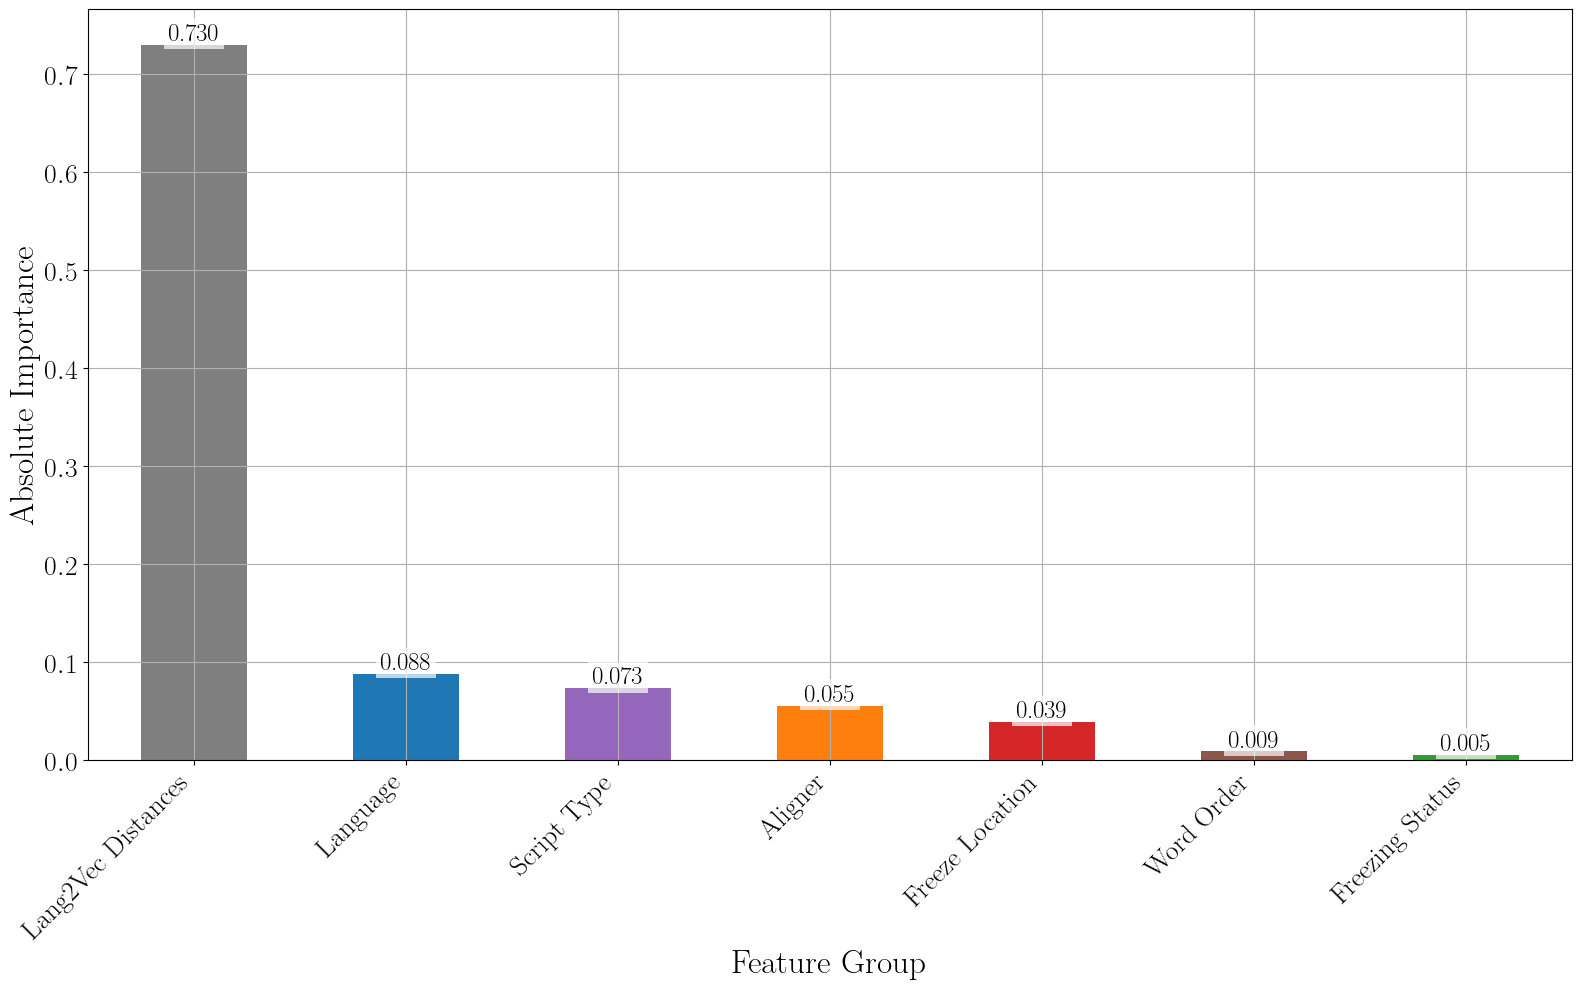


Ranked Aggregated Feature Importances
 Rank              Group  Importance
    1 Lang2Vec Distances    0.729851
    2           Language    0.087888
    3        Script Type    0.073376
    4            Aligner    0.055469
    5    Freeze Location    0.039053
    6         Word Order    0.008883
    7    Freezing Status    0.005480

Ranked Individual Feature Importances
 Rank               Feature              Group  Importance
    1             syntactic Lang2Vec Distances    0.357211
    2            geographic Lang2Vec Distances    0.278973
    3             inventory Lang2Vec Distances    0.070825
    4     script_type_Latin        Script Type    0.062478
    5       language_German           Language    0.035028
    6 freeze_location_Front    Freeze Location    0.031579
    7      language_Turkish           Language    0.026994
    8       aligner_Awesome            Aligner    0.022380
    9     aligner_FastAlign            Aligner    0.017300
   10          aligner_Dict         

In [56]:
coefficients, encoded_columns = perform_regression(train_data, val_data, test_data, title='Outliers Removed')

print("Feature Importances:")
print(coefficients)

In [57]:
xlmr_nli_df = read_and_process_csv('./raw_results/xlm-roberta-base__opus100.csv', model_name='XLM-R')

In [58]:
xlmr_nli_df = process_dataframe(xlmr_nli_df, group_by_columns=['model', 'seed', 'language'])

C:\Users\alith\AppData\Local\Temp\ipykernel_181880\2421398949.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(group_by_columns, group_keys=False).apply(calculate_delta_accuracy)


In [59]:
xlmr_nli_df.dropna(subset=['accuracy'], inplace=True)

# Drop rows with NaNs in 'delta_accuracy' column (if applicable)
xlmr_nli_df.dropna(subset=['delta_accuracy'], inplace=True)

xlmr_nli_df.drop('model', axis=1, inplace=True)

xlmr_nli_df.drop('accuracy', axis=1, inplace=True)

xlmr_nli_df.drop('seed', axis=1, inplace=True)

xlmr_nli_df

,method,language,delta_accuracy
175,Before FastAlign,English,0.001180
176,Before FastAlign,Afrikaans,0.002683
177,Before FastAlign,Arabic,0.044768
178,Before FastAlign,Bulgarian,0.004515
179,Before FastAlign,Catalan,0.000534
...,...,...,...
2445,Before - Back Freeze Dict,Thai,-0.000538
2446,Before - Back Freeze Dict,Turkish,0.005514
2447,Before - Back Freeze Dict,Ukrainian,-0.003323
2448,Before - Back Freeze Dict,Vietnamese,-0.002509


In [60]:
xlmr_nli_df = split_method_column(xlmr_nli_df)

In [61]:
xlmr_nli_df = add_language_distances_to_df(xlmr_nli_df)

In [62]:
xlmr_nli_df = add_linguistic_features(xlmr_nli_df)

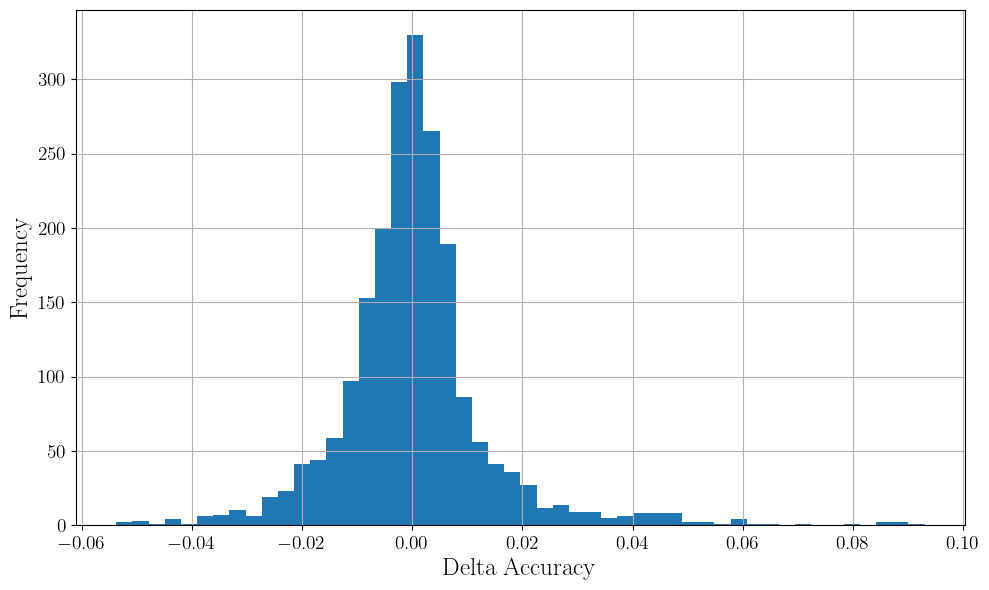

Number of outliers removed: 176
Shape of data before removing outliers: (2100, 13)
Shape of data after removing outliers: (1924, 13)


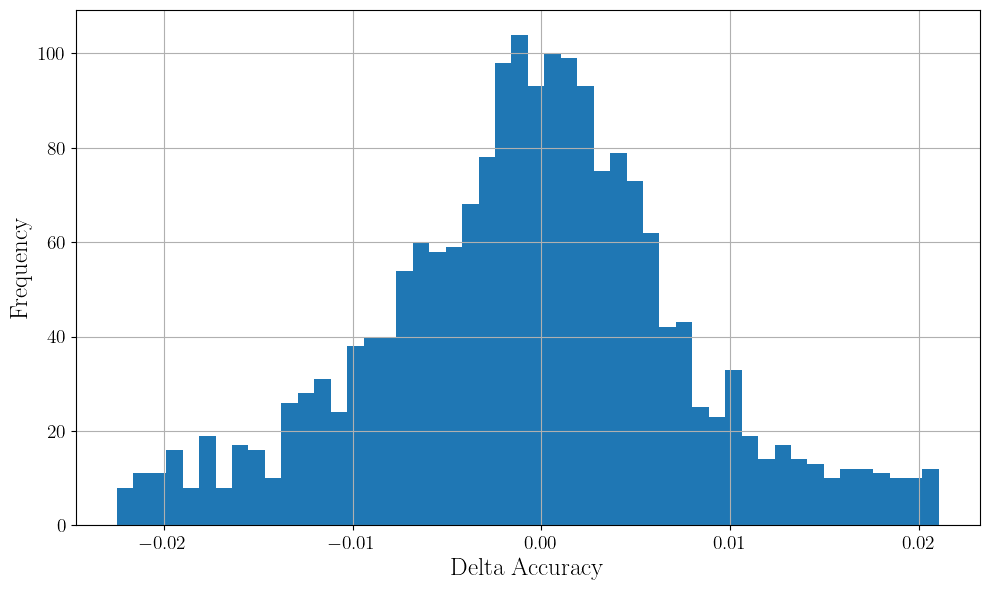


Statistics before removing outliers:
count    2100.000000
mean        0.000249
std         0.013726
min        -0.053782
25%        -0.006006
50%        -0.000299
75%         0.004986
max         0.093057
Name: delta_accuracy, dtype: float64

Statistics after removing outliers:
count    1924.000000
mean       -0.000695
std         0.008262
min        -0.022482
25%        -0.005647
50%        -0.000423
75%         0.004242
max         0.021072
Name: delta_accuracy, dtype: float64

Outlier Analysis:

Top 10 Languages in Outliers:
language
Hindi        36
Japanese     31
Arabic       30
Persian      16
Tamil        15
Hebrew       14
Korean        7
Slovak        7
Slovenian     5
Russian       4
Name: count, dtype: int64

Word Aligners in Outliers:
aligner
Dict         67
Awesome      56
FastAlign    53
Name: count, dtype: int64

Freezing Status in Outliers:
frozen_status
Vanilla    97
Frozen     79
Name: count, dtype: int64

Freeze Location in Outliers:
freeze_location
None     97
Back

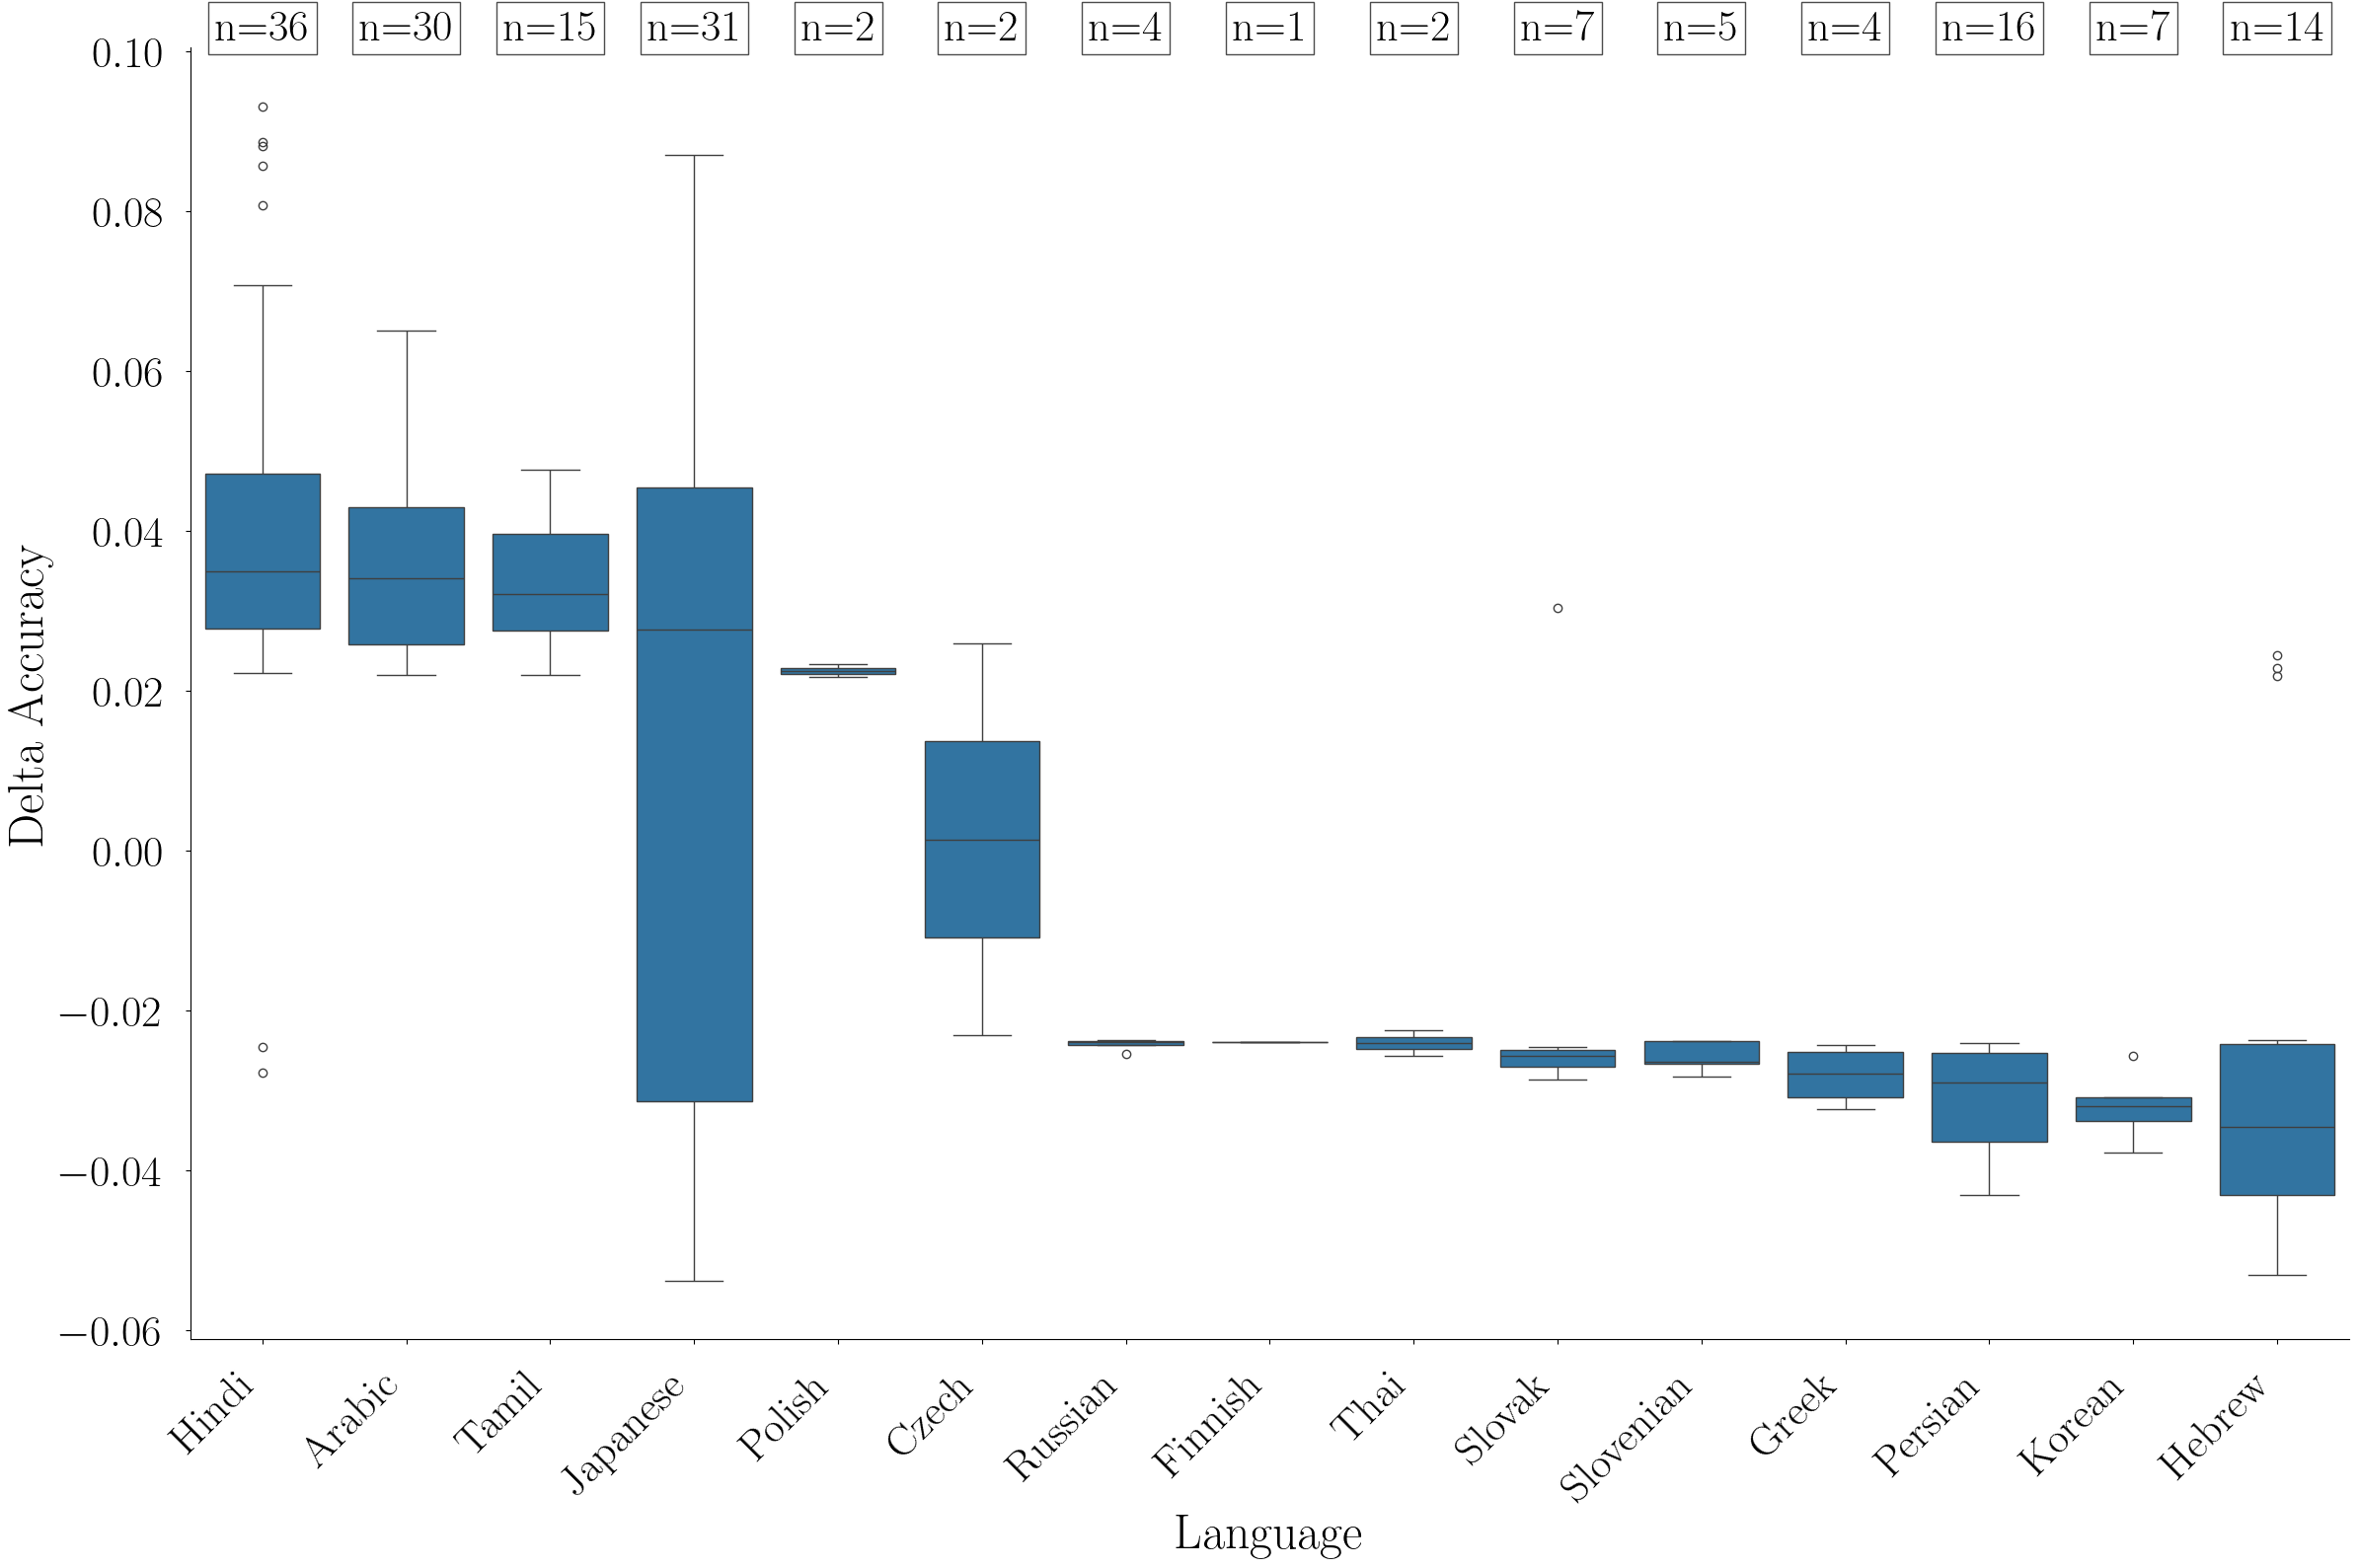


Summary Statistics for Outliers:
           count      mean       std       min       25%       50%       75%  \
language                                                                       
Arabic      30.0  0.036174  0.011297  0.021918  0.025811  0.033996  0.042965   
Czech        2.0  0.001375  0.034697 -0.023160 -0.010892  0.001375  0.013643   
Finnish      1.0 -0.023952       NaN -0.023952 -0.023952 -0.023952 -0.023952   
Greek        4.0 -0.028152  0.003829 -0.032409 -0.030829 -0.027923 -0.025245   
Hebrew      14.0 -0.024951  0.027301 -0.053101 -0.043095 -0.034641 -0.024272   
Hindi       36.0  0.040670  0.026276 -0.027745  0.027766  0.034857  0.047178   
Japanese    31.0  0.012290  0.042797 -0.053782 -0.031418  0.027620  0.045381   
Korean       7.0 -0.032139  0.003709 -0.037767 -0.033870 -0.032029 -0.030873   
Persian     16.0 -0.031136  0.006484 -0.043064 -0.036483 -0.029023 -0.025339   
Polish       2.0  0.022469  0.001127  0.021672  0.022070  0.022469  0.022868   
Russia

In [63]:
clean_nli_df, nli_outliers = analyze_and_remove_outliers(xlmr_nli_df)

In [64]:
train_data, val_data, test_data = split_train_val_test(xlmr_nli_df)

100%|██████████| 59/59 [00:00<00:00, 170.79it/s]



Final Test MSE for All Data (Random Forest): 0.00013958488811777515


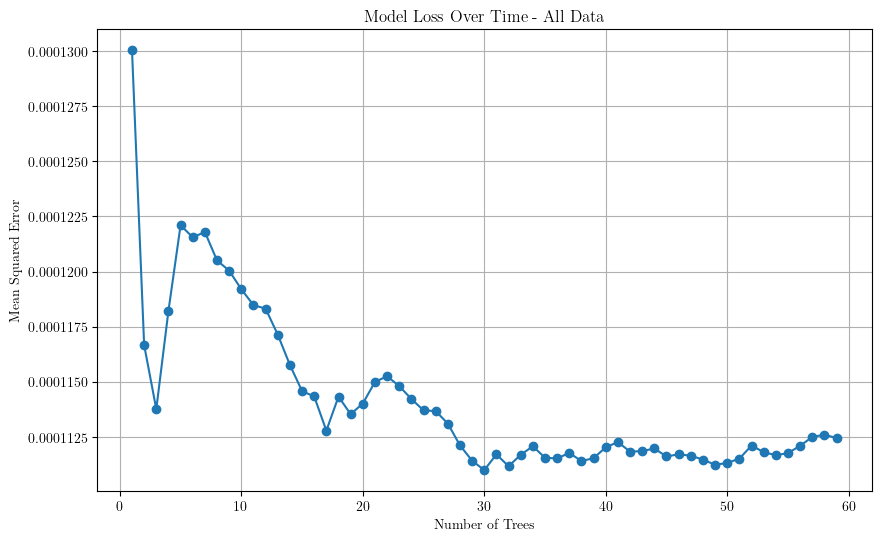

C:\Users\alith\AppData\Local\Temp\ipykernel_181880\3614062542.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels, fontsize=14)  # Increased font size for y-axis labels


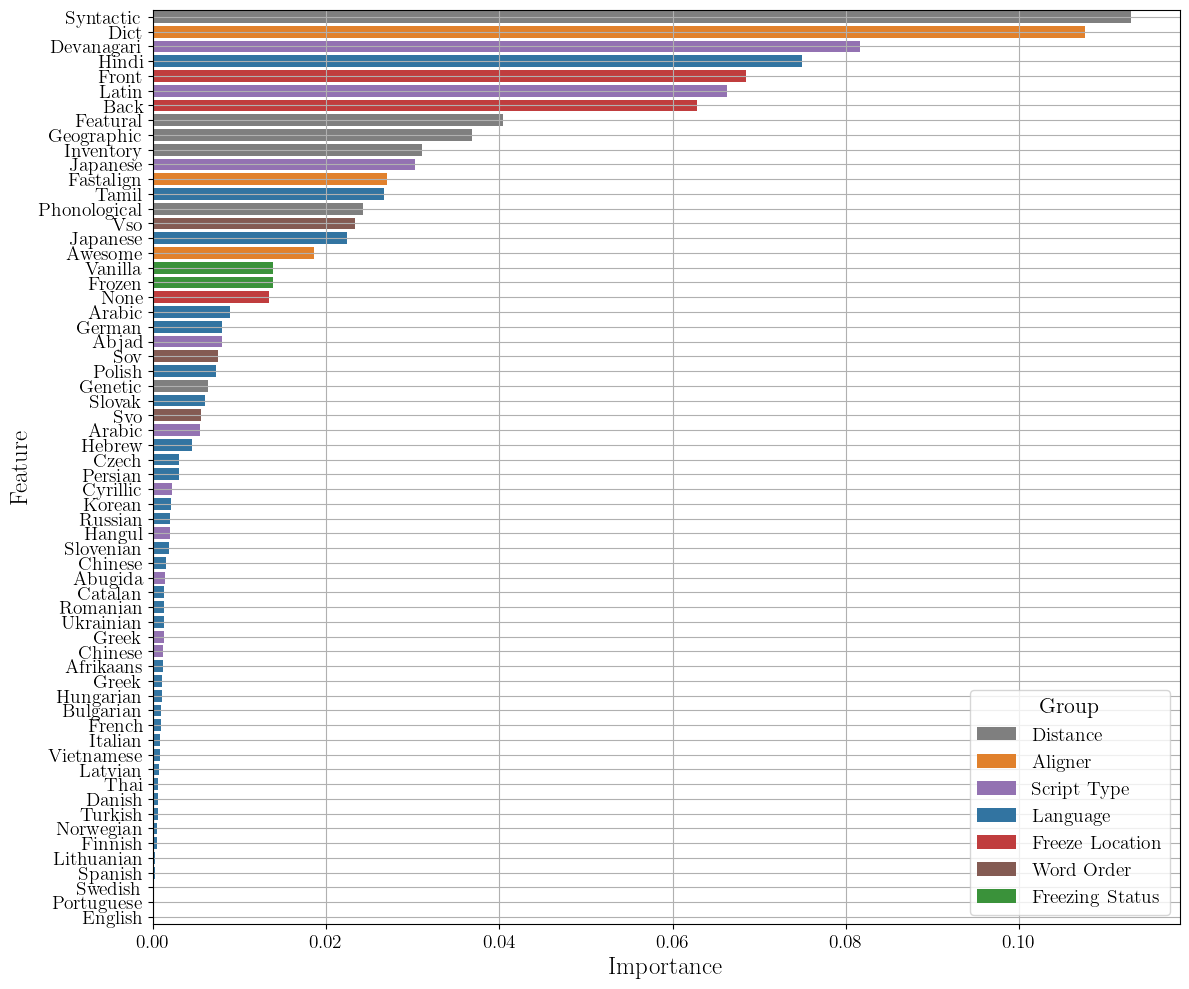

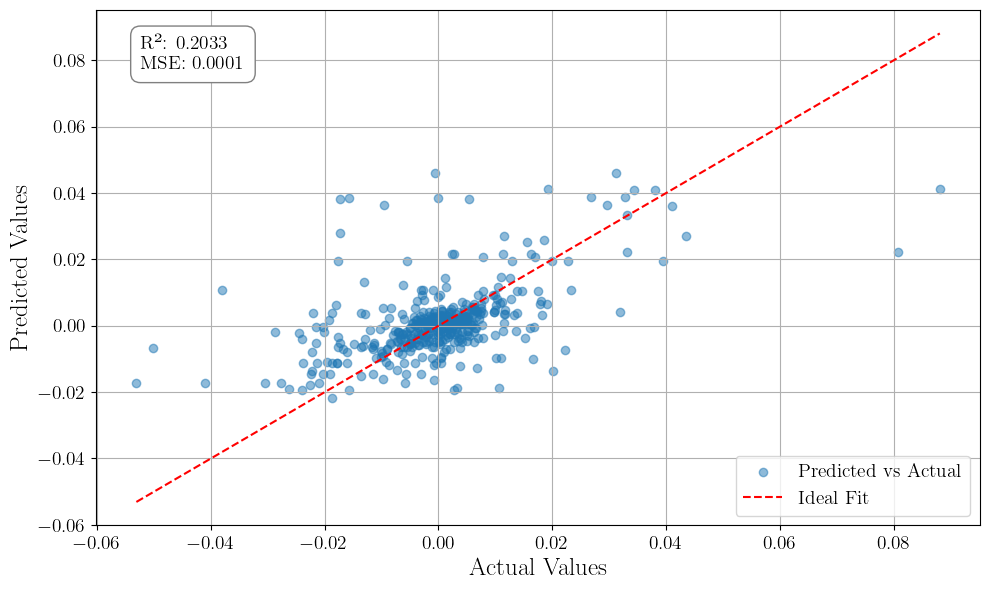

Unique feature names:
['syntactic' 'geographic' 'phonological' 'genetic' 'inventory' 'featural'
 'language_Afrikaans' 'language_Arabic' 'language_Bulgarian'
 'language_Catalan' 'language_Chinese' 'language_Czech' 'language_Danish'
 'language_English' 'language_Finnish' 'language_French' 'language_German'
 'language_Greek' 'language_Hebrew' 'language_Hindi' 'language_Hungarian'
 'language_Italian' 'language_Japanese' 'language_Korean'
 'language_Latvian' 'language_Lithuanian' 'language_Norwegian'
 'language_Persian' 'language_Polish' 'language_Portuguese'
 'language_Romanian' 'language_Russian' 'language_Slovak'
 'language_Slovenian' 'language_Spanish' 'language_Swedish'
 'language_Tamil' 'language_Thai' 'language_Turkish' 'language_Ukrainian'
 'language_Vietnamese' 'aligner_Awesome' 'aligner_Dict'
 'aligner_FastAlign' 'frozen_status_Frozen' 'frozen_status_Vanilla'
 'freeze_location_Back' 'freeze_location_Front' 'freeze_location_None'
 'script_type_Abjad' 'script_type_Abugida' 'script_t

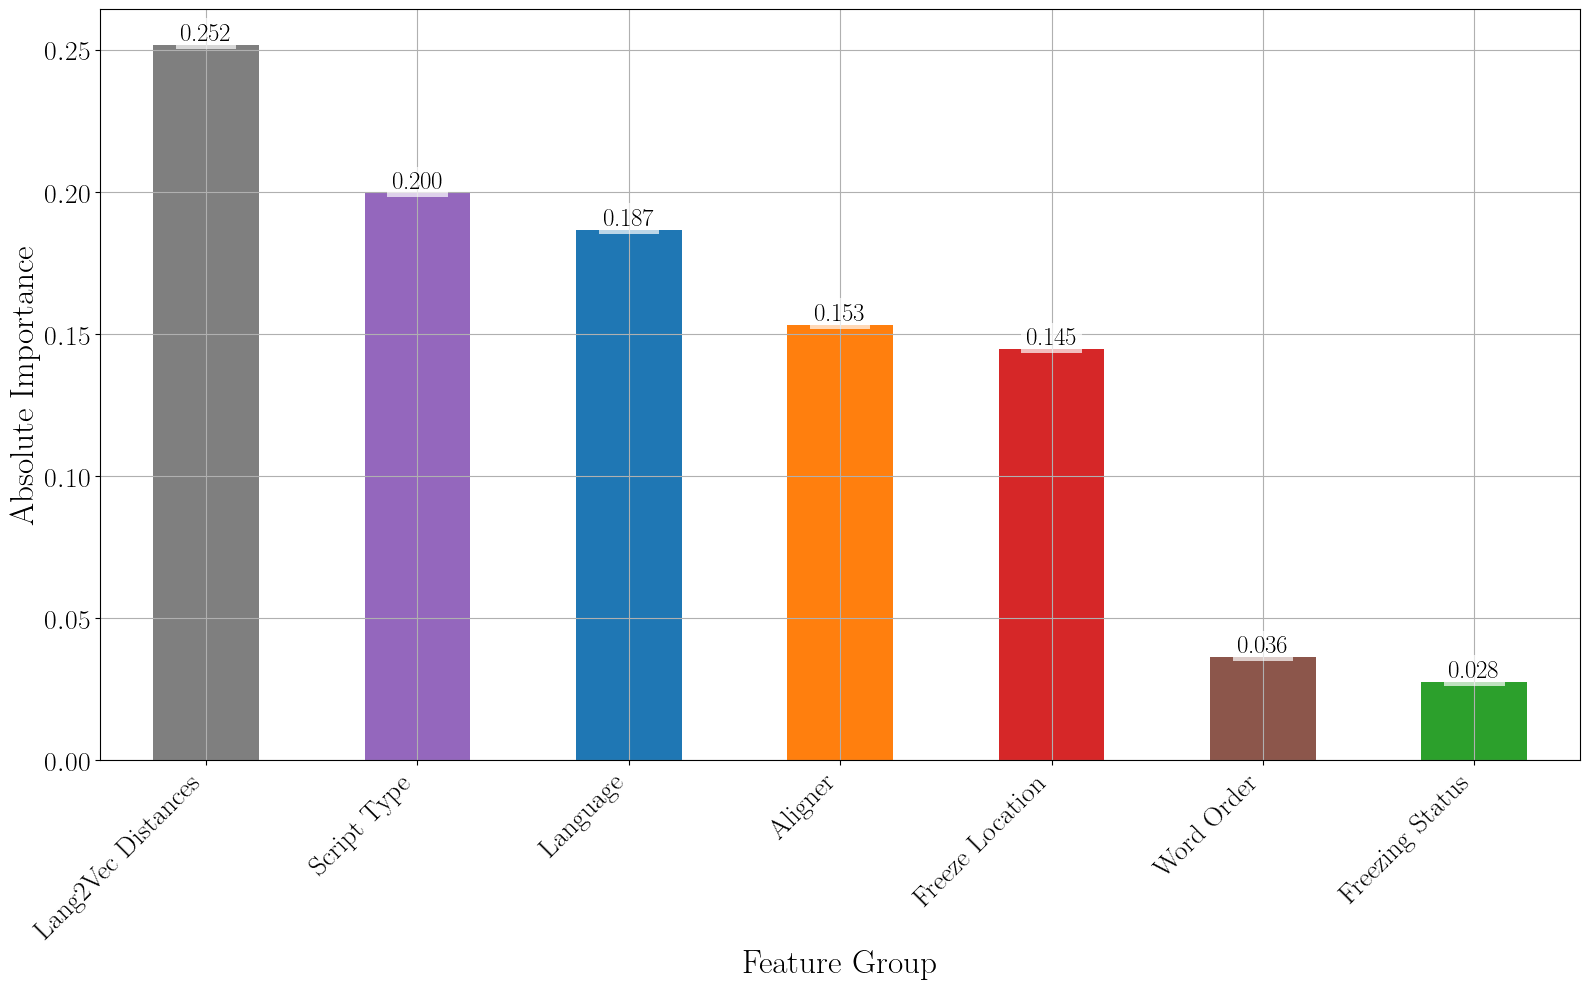


Ranked Aggregated Feature Importances
 Rank              Group  Importance
    1 Lang2Vec Distances    0.251798
    2        Script Type    0.199632
    3           Language    0.186713
    4            Aligner    0.153220
    5    Freeze Location    0.144704
    6         Word Order    0.036321
    7    Freezing Status    0.027612

Ranked Individual Feature Importances
 Rank                Feature              Group  Importance
    1              syntactic Lang2Vec Distances    0.112925
    2           aligner_Dict            Aligner    0.107619
    3 script_type_Devanagari        Script Type    0.081637
    4         language_Hindi           Language    0.074979
    5  freeze_location_Front    Freeze Location    0.068485
    6      script_type_Latin        Script Type    0.066323
    7   freeze_location_Back    Freeze Location    0.062825
    8               featural Lang2Vec Distances    0.040416
    9             geographic Lang2Vec Distances    0.036860
   10              invento

In [65]:
coefficients, encoded_columns = perform_regression(train_data, val_data, test_data, title='All Data')

print("Feature Importances:")
print(coefficients)

In [66]:
train_data, val_data, test_data = split_train_val_test(clean_nli_df)

100%|██████████| 59/59 [00:00<00:00, 184.03it/s]



Final Test MSE for Outliers Removed (Random Forest): 7.554070775417692e-05


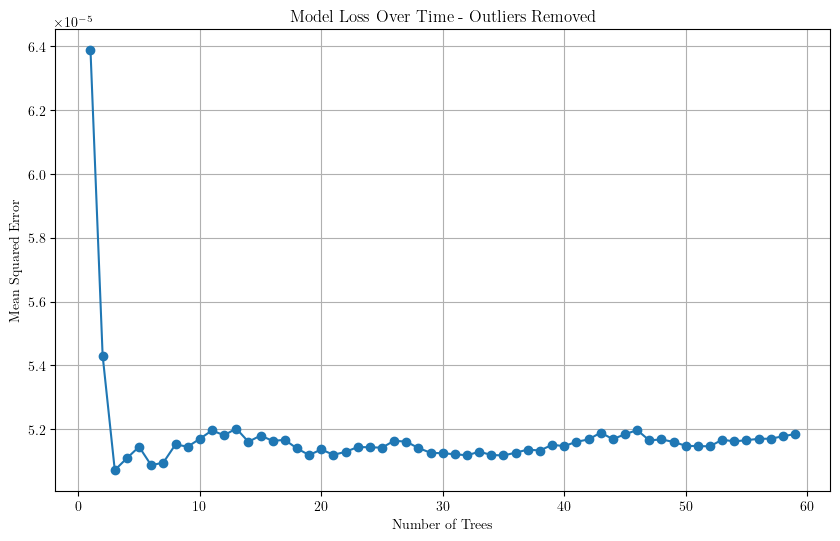

C:\Users\alith\AppData\Local\Temp\ipykernel_181880\3614062542.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels, fontsize=14)  # Increased font size for y-axis labels


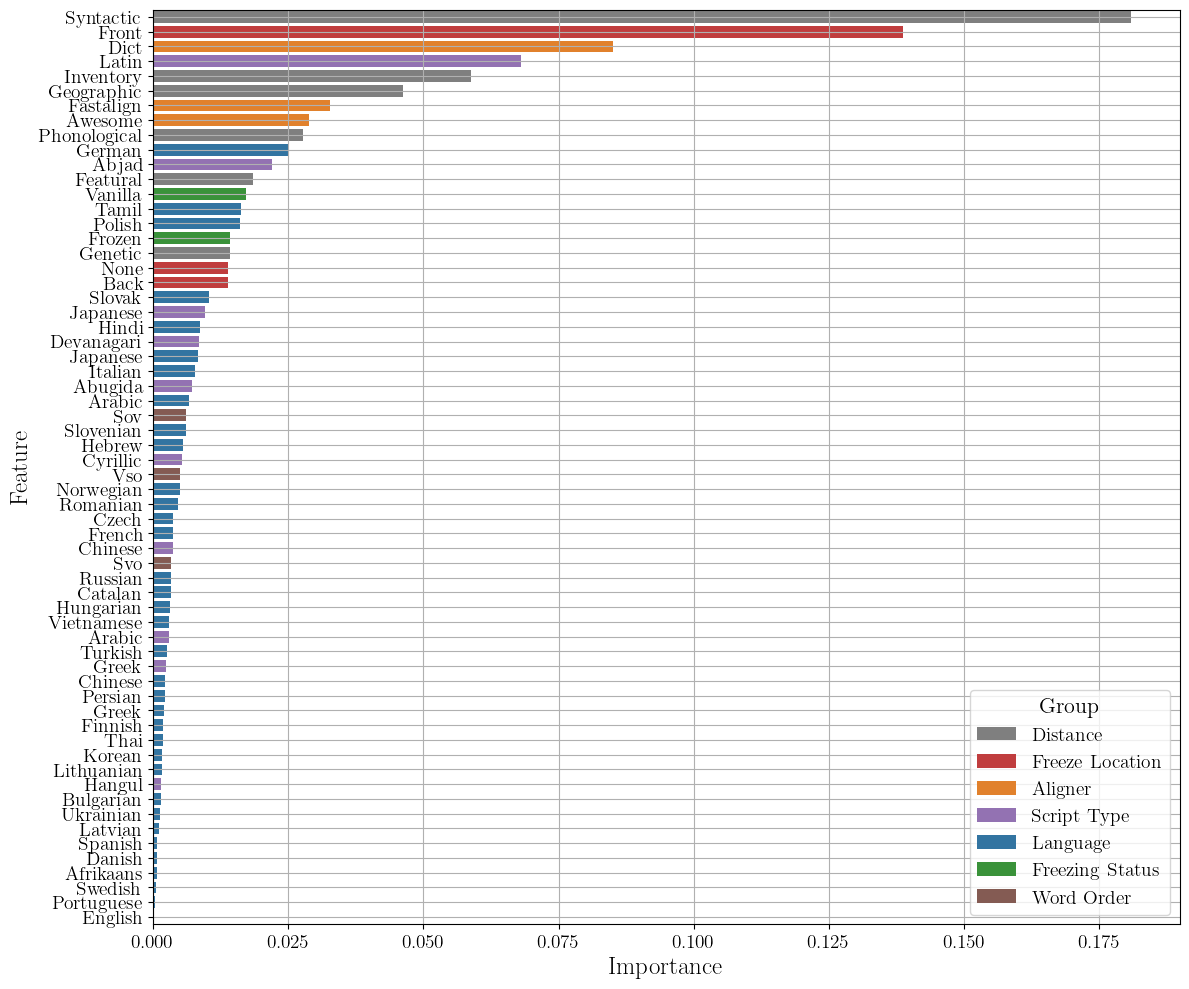

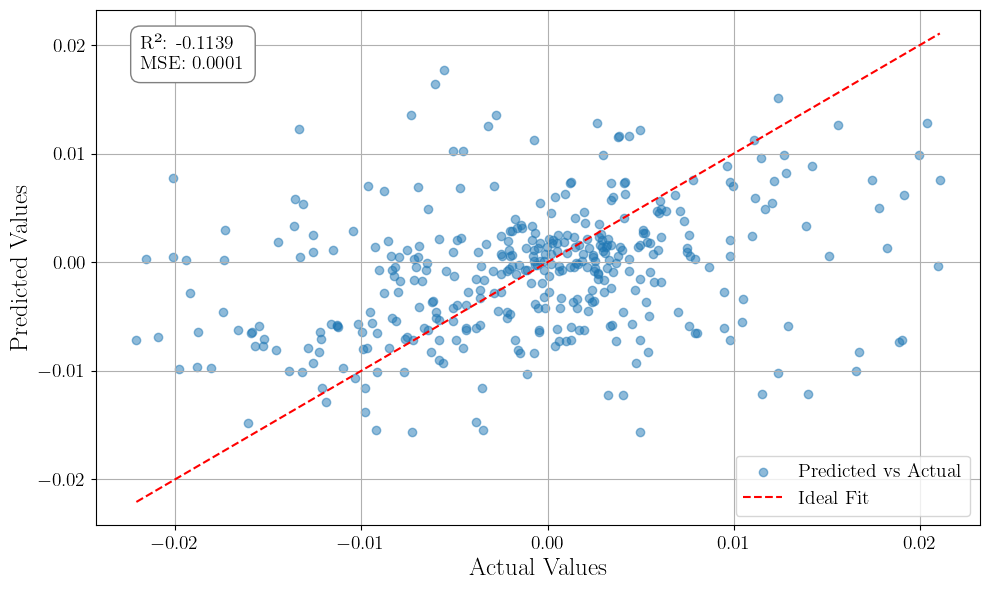

Unique feature names:
['syntactic' 'geographic' 'phonological' 'genetic' 'inventory' 'featural'
 'language_Afrikaans' 'language_Arabic' 'language_Bulgarian'
 'language_Catalan' 'language_Chinese' 'language_Czech' 'language_Danish'
 'language_English' 'language_Finnish' 'language_French' 'language_German'
 'language_Greek' 'language_Hebrew' 'language_Hindi' 'language_Hungarian'
 'language_Italian' 'language_Japanese' 'language_Korean'
 'language_Latvian' 'language_Lithuanian' 'language_Norwegian'
 'language_Persian' 'language_Polish' 'language_Portuguese'
 'language_Romanian' 'language_Russian' 'language_Slovak'
 'language_Slovenian' 'language_Spanish' 'language_Swedish'
 'language_Tamil' 'language_Thai' 'language_Turkish' 'language_Ukrainian'
 'language_Vietnamese' 'aligner_Awesome' 'aligner_Dict'
 'aligner_FastAlign' 'frozen_status_Frozen' 'frozen_status_Vanilla'
 'freeze_location_Back' 'freeze_location_Front' 'freeze_location_None'
 'script_type_Abjad' 'script_type_Abugida' 'script_t

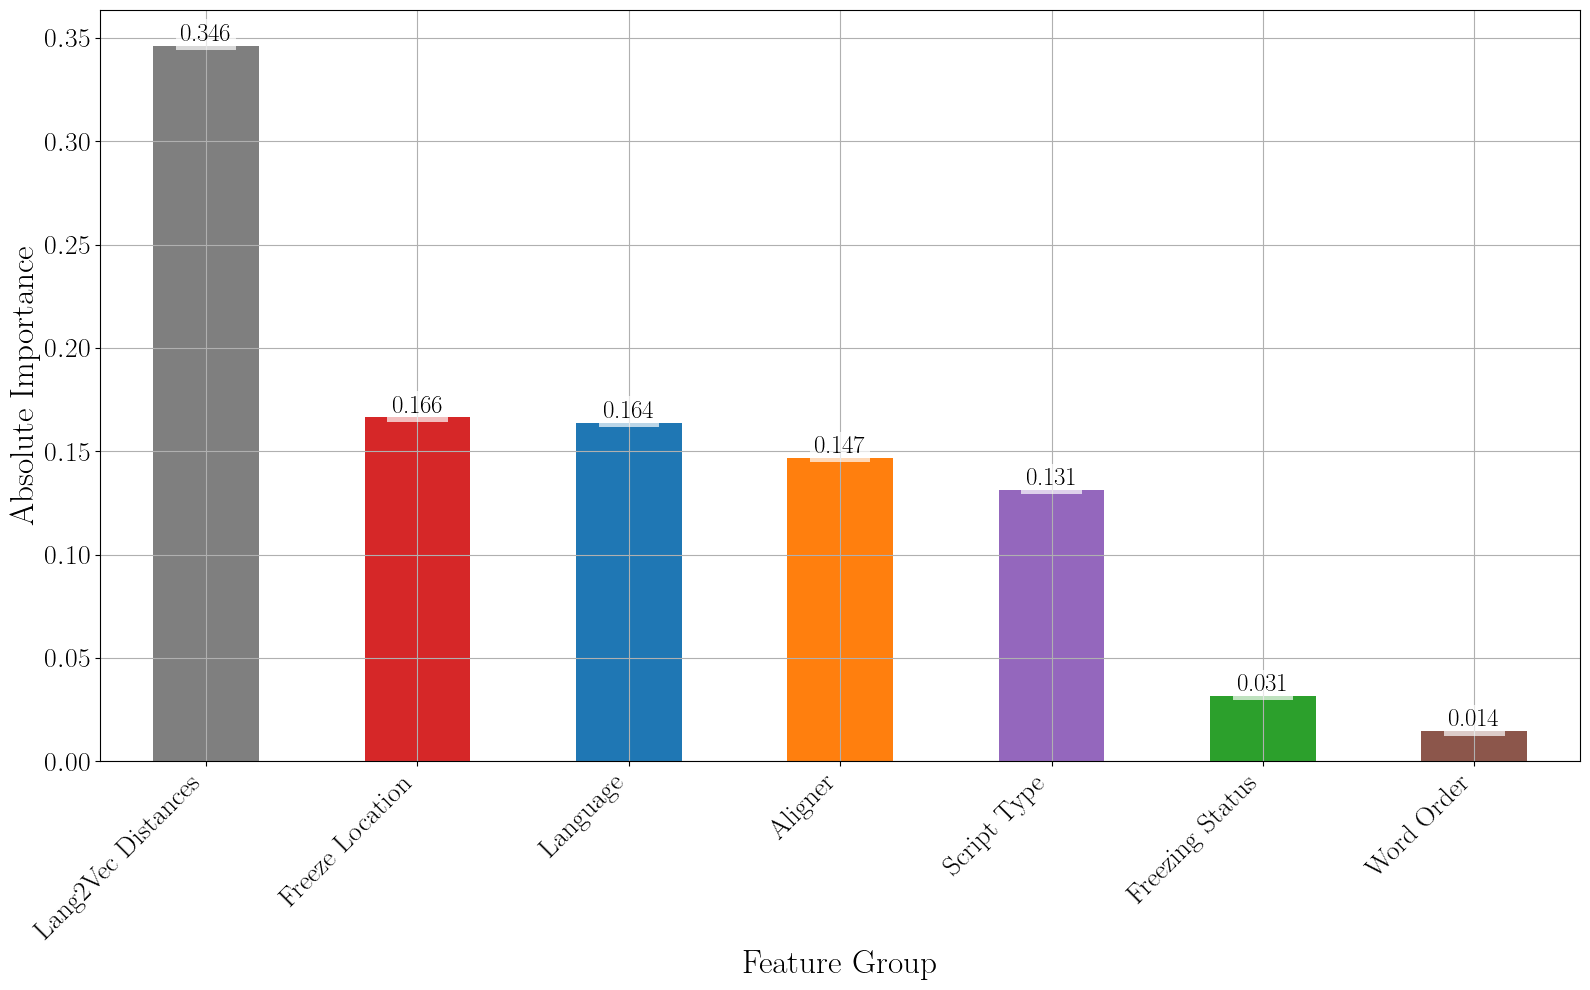


Ranked Aggregated Feature Importances
 Rank              Group  Importance
    1 Lang2Vec Distances    0.346186
    2    Freeze Location    0.166335
    3           Language    0.163732
    4            Aligner    0.146613
    5        Script Type    0.131224
    6    Freezing Status    0.031459
    7         Word Order    0.014452

Ranked Individual Feature Importances
 Rank               Feature              Group  Importance
    1             syntactic Lang2Vec Distances    0.180868
    2 freeze_location_Front    Freeze Location    0.138773
    3          aligner_Dict            Aligner    0.085105
    4     script_type_Latin        Script Type    0.068125
    5             inventory Lang2Vec Distances    0.058857
    6            geographic Lang2Vec Distances    0.046222
    7     aligner_FastAlign            Aligner    0.032738
    8       aligner_Awesome            Aligner    0.028770
    9          phonological Lang2Vec Distances    0.027693
   10       language_German         

In [67]:
coefficients, encoded_columns = perform_regression(train_data, val_data, test_data, title='Outliers Removed')

print("Feature Importances:")
print(coefficients)

In [68]:
clean_nli_df.drop('morphological_complexity', axis=1, inplace=True)

nan_counts = clean_nli_df.isna().sum()

print("NaN counts in each column:")
print(nan_counts)

KeyError: "['morphological_complexity'] not found in axis"

In [ ]:
# Drop rows with NaN values
clean_nli_df_no_nans = clean_nli_df.dropna()

In [ ]:
print(f"\nShape before dropping NaNs: {clean_nli_df.shape}")
print(f"Shape after dropping NaNs: {clean_nli_df_no_nans.shape}")

# Calculate how many rows were dropped
rows_dropped = clean_nli_df.shape[0] - clean_nli_df_no_nans.shape[0]
print(f"Number of rows dropped: {rows_dropped}")

In [ ]:
clean_nli_df_no_nans['language'].unique()

In [ ]:
df_clean['language'].unique()

,model,method,language,seed,accuracy
1,distilMBERT,Before FastAlign,Afrikaans,31,0.861202
2,distilMBERT,Before FastAlign,Arabic,31,0.640894
3,distilMBERT,Before FastAlign,Bulgarian,31,0.875413
4,distilMBERT,Before FastAlign,Catalan,31,0.879494
5,distilMBERT,Before FastAlign,Czech,31,0.849067
...,...,...,...,...,...
3320,distilMBERT,Before - Back Freeze Dict,Thai,17,0.544291
3321,distilMBERT,Before - Back Freeze Dict,Turkish,17,0.703042
3322,distilMBERT,Before - Back Freeze Dict,Ukrainian,17,0.850023
3323,distilMBERT,Before - Back Freeze Dict,Vietnamese,17,0.565705
